## 1. Imports and Data Loading

In [2]:
import numpy as np
import random
import os
import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
results_dir = 'experiment_results'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

tf.keras.backend.clear_session()

import pandas as pd
%matplotlib inline
df = pd.read_csv('datasets/local_cache/dataset_12500_samples_65_features.csv')

# Drop features with high label leakage
cols_to_drop = [
 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt',
 'ack_flag_cnt', 'urg_flag_cnt', 'cwe_flag_cnt', 'ece_flag_cnt',
 'fwd_header_length', 'bwd_header_length',
 'active_mean', 'active_std', 'active_max', 'active_min',
 'idle_mean', 'idle_std', 'idle_max', 'idle_min',
 'subflow_fwd_bytes'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print(f" Data loaded: {len(df)} samples, {len(df.columns)} features")

 Data loaded: 12500 samples, 48 features


In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

print(" Random seeds set for reproducibility")

 Random seeds set for reproducibility


## 3. Configuration

In [4]:
CFG = {
    # Training parameters
    'local_epochs': 1,
    'lr': 1e-3,
    'loss_weights': {'traffic': 1, 'duration': 1, 'bandwidth': 1},
    'test_size': 0.2,
    
    # Client configuration
    'n_clients_flat': 600,
    'n_clusters': 3,
    'clients_per_cluster': 200,
    'client_frac': 1.0,
    
    # Hierarchical FL
    'global_aggregator_cluster': 1,  # Cluster 1 performs global aggregation
    
    # Data distribution (TWO-LEVEL SPLIT)
    'cluster_split': 'equal',      # How to split data among clusters ('equal' or 'dirichlet')
    'client_split': 'dirichlet',   # How to split data among clients within clusters (always 'dirichlet')
    'alpha_client': 0.4,           # Dirichlet α for client-level distribution
    'alpha_cluster': 0.4,          # Dirichlet α for cluster-level distribution (when cluster_split='dirichlet')
}

print("Configuration:")
print(f"  Training: local_epochs={CFG['local_epochs']}, lr={CFG['lr']}")
print(f"  Clients: {CFG['n_clients_flat']} total ({CFG['n_clusters']} clusters × {CFG['clients_per_cluster']} clients)")
print(f"  Participation: {CFG['client_frac']*100}%")
print(f"\n  Data Distribution (Two-Level):")
print(f"    Level 1 (Clusters): {CFG['cluster_split']} split")
print(f"    Level 2 (Clients): {CFG['client_split']} split (α={CFG['alpha_client']})")
print(f"    Cluster α: {CFG['alpha_cluster']} (used when cluster_split='dirichlet')")

Configuration:
  Training: local_epochs=1, lr=0.001
  Clients: 600 total (3 clusters × 200 clients)
  Participation: 100.0%

  Data Distribution (Two-Level):
    Level 1 (Clusters): equal split
    Level 2 (Clients): dirichlet split (α=0.4)
    Cluster α: 0.4 (used when cluster_split='dirichlet')


## 4. Feature Selection for Each Task

In [5]:
# Define features to exclude for each task (prevent label leakage)
exclude_traffic = [
 'src_ip', 'dst_ip', 'src_port', 'dst_port', # identity → leakage
 'protocol', # not useful for QUIC-only
 'label', 'flow_duration', 'flow_bytes_per_s', 'bandwidth_bps'
]

exclude_duration = [
 'src_ip', 'dst_ip', 'src_port', 'dst_port',
 'protocol',
 'label', 'flow_duration', 'flow_bytes_per_s', 'bandwidth_bps'
]

exclude_bandwidth = [
 'src_ip', 'dst_ip', 'src_port', 'dst_port',
 'protocol',
 'label', 'flow_duration', 'flow_bytes_per_s', 'bandwidth_bps'
]

Xcols_traffic = [col for col in df.columns if col not in exclude_traffic]
Xcols_duration = [col for col in df.columns if col not in exclude_duration]
Xcols_bandwidth = [col for col in df.columns if col not in exclude_bandwidth]

print(f" Traffic features: {len(Xcols_traffic)}")
print(f" Duration features: {len(Xcols_duration)}")
print(f" Bandwidth features: {len(Xcols_bandwidth)}")

 Traffic features: 39
 Duration features: 39
 Bandwidth features: 39


## 5. Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

n = len(df)
indices = np.arange(n)
train_idx, test_idx = train_test_split(
 indices, 
 test_size=CFG['test_size'], 
 random_state=seed, 
 shuffle=True
)

train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

print(f" Train samples: {len(train_df)}")
print(f" Test samples: {len(test_df)}")

 Train samples: 10000
 Test samples: 2500


## 6. Winsorization (Outlier Handling)

In [7]:
from scipy.stats.mstats import winsorize

all_features = list(set(Xcols_traffic + Xcols_duration + Xcols_bandwidth))

# Calculate winsorization bounds from training data
winsor_bounds = {}
for col in all_features:
    if col in train_df.columns:
     lower = train_df[col].quantile(0.01)
     upper = train_df[col].quantile(0.99)
     winsor_bounds[col] = (lower, upper)

# Apply winsorization
for col, (lower, upper) in winsor_bounds.items():
 lower_limit = (train_df[col] < lower).mean()
 upper_limit = (train_df[col] > upper).mean()
 
 for df_temp in [train_df, test_df]:
     df_temp[col] = winsorize(df_temp[col], limits=(lower_limit, upper_limit))

## 7. Target Variable Processing

In [8]:
# Create quantile-based labels for duration and bandwidth (5 classes each)
y_dur_raw_train = train_df['flow_duration'].values
y_bw_raw_train = train_df['bandwidth_bps'].values

# Log-transform
bw_log = np.log1p(y_bw_raw_train)
dur_log = np.log1p(y_dur_raw_train)

# Compute 5-bin quantiles (20%, 40%, 60%, 80%)
bw_quantiles = np.quantile(bw_log, [0.20, 0.40, 0.60, 0.80])
dur_quantiles = np.quantile(dur_log, [0.20, 0.40, 0.60, 0.80])

def create_quantile_labels(raw_values, quantiles):
 """Create 5-class labels (0-4) using quantile thresholds"""
 v = np.log1p(raw_values)
 labels = np.digitize(v, quantiles, right=False) # returns 0..4
 return labels

print(" Quantile thresholds computed for duration and bandwidth")

 Quantile thresholds computed for duration and bandwidth


## 8. Label Encoding and Feature Scaling

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Create labels for all tasks
y_dur_train = create_quantile_labels(train_df['flow_duration'].values, dur_quantiles)
y_dur_test = create_quantile_labels(test_df['flow_duration'].values, dur_quantiles)

y_bw_train = create_quantile_labels(train_df['bandwidth_bps'].values, bw_quantiles)
y_bw_test = create_quantile_labels(test_df['bandwidth_bps'].values, bw_quantiles)

# Traffic classification (label encoding)
le_traf = LabelEncoder()
y_traf_train = le_traf.fit_transform(train_df['label'])
y_traf_test = le_traf.transform(test_df['label'])

# Standardize features
feature_scaler = StandardScaler()
train_df[all_features] = feature_scaler.fit_transform(train_df[all_features])
test_df[all_features] = feature_scaler.transform(test_df[all_features])

print(" Labels created and features standardized")
print(f" Traffic classes: {len(np.unique(y_traf_train))}")
print(f" Duration classes: {len(np.unique(y_dur_train))}")
print(f" Bandwidth classes: {len(np.unique(y_bw_train))}")

 Labels created and features standardized
 Traffic classes: 5
 Duration classes: 5
 Bandwidth classes: 5


## 9. Prepare Feature Matrices

In [10]:
# Extract feature matrices for each task
X_traffic_train = train_df[Xcols_traffic].values
X_duration_train = train_df[Xcols_duration].values
X_bandwidth_train = train_df[Xcols_bandwidth].values

X_traffic_test = test_df[Xcols_traffic].values
X_duration_test = test_df[Xcols_duration].values
X_bandwidth_test = test_df[Xcols_bandwidth].values

print(" Feature matrices extracted")
print(f" Traffic: {X_traffic_train.shape}")
print(f" Duration: {X_duration_train.shape}")
print(f" Bandwidth: {X_bandwidth_train.shape}")

 Feature matrices extracted
 Traffic: (10000, 39)
 Duration: (10000, 39)
 Bandwidth: (10000, 39)


## 10. Feature Padding (Uniform Dimensionality)

In [11]:
# Pad all feature matrices to the same dimension
max_dim = max(X_traffic_train.shape[1], X_duration_train.shape[1], X_bandwidth_train.shape[1])

def pad_features(X, target_size):
    """Pad features with zeros to reach target size"""
    if X.shape[1] < target_size:
        padding = np.zeros((X.shape[0], target_size - X.shape[1]))
        return np.concatenate([X, padding], axis=1)
    return X

X_traffic_train = pad_features(X_traffic_train, max_dim)
X_duration_train = pad_features(X_duration_train, max_dim)
X_bandwidth_train = pad_features(X_bandwidth_train, max_dim)

X_traffic_test = pad_features(X_traffic_test, max_dim)
X_duration_test = pad_features(X_duration_test, max_dim)
X_bandwidth_test = pad_features(X_bandwidth_test, max_dim)

print(f"✓ All features padded to dimension: {max_dim}")
print(f"  Traffic: {X_traffic_train.shape}")
print(f"  Duration: {X_duration_train.shape}")
print(f"  Bandwidth: {X_bandwidth_train.shape}")

✓ All features padded to dimension: 39
  Traffic: (10000, 39)
  Duration: (10000, 39)
  Bandwidth: (10000, 39)


## 11. Mutual Information Analysis (Feature Leakage Check)

In [12]:
from sklearn.feature_selection import mutual_info_classif
import sys

def find_high_mi_features(X_cols, y_train, train_df, task_name, seed, threshold=0.2):
    """Find features with high mutual information (potential label leakage)"""
    X_train = train_df[X_cols].values
    
    try:
        mi_scores = mutual_info_classif(
            X_train,
            y_train,
            discrete_features=False,
            random_state=seed
        )
    except Exception as e:
        print(f"Error calculating MI for {task_name}: {e}", file=sys.stderr)
        return []
    
    mi_results = dict(zip(X_cols, mi_scores))
    
    problematic = []
    for feat, mi in mi_results.items():
        if mi > threshold:
            problematic.append((feat, mi))
    
    if problematic:
        print(f"\n{task_name} - Found {len(problematic)} features with MI > {threshold}:")
        problematic.sort(key=lambda x: x[1], reverse=True)
        for feat, mi in problematic[:10]:  # Show top 10
            print(f"  • {feat}: {mi:.4f}")
        if len(problematic) > 10:
            print(f"  ... and {len(problematic) - 10} more")
    else:
        print(f"\n{task_name} - No features found with MI > {threshold}")
    
    return problematic

print("Analyzing mutual information between features and labels...")

problematic_dur = find_high_mi_features(
    Xcols_duration, y_dur_train, train_df, 'Duration', seed
)

problematic_bw = find_high_mi_features(
    Xcols_bandwidth, y_bw_train, train_df, 'Bandwidth', seed
)

problematic_tf = find_high_mi_features(
    Xcols_traffic, y_traf_train, train_df, 'Traffic', seed
)

all_diagnostics = {
    'duration': problematic_dur,
    'bandwidth': problematic_bw,
    'traffic': problematic_tf
}

print("\n✓ Mutual information analysis complete")
print("  Note: High MI features may indicate correlation with labels")

Analyzing mutual information between features and labels...

Duration - Found 30 features with MI > 0.2:
  • bwd_packets_per_s: 0.9275
  • flow_packets_per_s: 0.9051
  • fwd_packets_per_s: 0.8397
  • flow_iat_mean: 0.7458
  • flow_iat_max: 0.7057
  • flow_iat_std: 0.6616
  • fwd_iat_total: 0.5753
  • fwd_iat_std: 0.5706
  • fwd_iat_max: 0.5513
  • fwd_iat_mean: 0.5258
  ... and 20 more

Bandwidth - Found 30 features with MI > 0.2:
  • bwd_packets_per_s: 1.2198
  • flow_packets_per_s: 1.1862
  • fwd_packets_per_s: 1.0154
  • flow_iat_mean: 0.7372
  • flow_iat_max: 0.6862
  • flow_iat_std: 0.6665
  • fwd_iat_std: 0.5595
  • fwd_iat_mean: 0.5562
  • fwd_iat_max: 0.5272
  • fwd_iat_total: 0.5123
  ... and 20 more

Traffic - Found 35 features with MI > 0.2:
  • bwd_pkt_len_min: 1.1980
  • bwd_seg_size_min: 1.1928
  • fwd_seg_size_min: 1.0199
  • fwd_pkt_len_min: 1.0194
  • bwd_pkt_len_max: 0.9857
  • fwd_pkt_len_max: 0.7743
  • flow_rate_entropy: 0.6934
  • bwd_pkt_len_mean: 0.6692
  • tota

## 12. Client Partitioning

In [13]:
def build_client_partitions(cluster_split='equal', client_split='dirichlet', verbose=True):
    """
    Build client partitions with TWO-LEVEL data distribution:
    - Level 1: Distribute data among CLUSTERS (equal or dirichlet)
    - Level 2: Distribute each cluster's data among CLIENTS (dirichlet)
    
    Args:
        cluster_split: 'equal' or 'dirichlet' - how to split data among clusters
        client_split: 'dirichlet' - how to split data among clients within clusters
        verbose: Print statistics
    
    Returns:
        client_indices_flat: List of client data indices
        client_index_to_cluster: Dict mapping client idx to cluster id
    """
    n_clients = CFG['n_clients_flat']
    n_clusters = CFG['n_clusters']
    clients_per_cluster = CFG['clients_per_cluster']
    alpha_client = CFG['alpha_client']
    alpha_cluster = CFG['alpha_cluster']
    min_size = 50
    rng = np.random.default_rng(seed)
    
    train_indices = np.arange(len(y_traf_train))
    labels = np.unique(y_traf_train)
    
    # Cluster_level_split
    
    if cluster_split == 'equal':
        # Equal split: each cluster gets 1/n_clusters of data
        samples_per_cluster = len(train_indices) // n_clusters
        cluster_indices = []
        
        for cluster_id in range(n_clusters):
            start_idx = cluster_id * samples_per_cluster
            end_idx = start_idx + samples_per_cluster if cluster_id < n_clusters - 1 else len(train_indices)
            cluster_indices.append(train_indices[start_idx:end_idx])
    
    elif cluster_split == 'dirichlet':
        # Dirichlet split: non-IID distribution among clusters
        cluster_bins = [[] for _ in range(n_clusters)]
        label_indices = {}
        
        for lbl in labels:
            label_indices[lbl] = train_indices[y_traf_train == lbl]
        
        for lbl in labels:
            idxs = label_indices[lbl]
            rng.shuffle(idxs)
            proportions = rng.dirichlet([alpha_cluster] * n_clusters)
            cuts = (np.cumsum(proportions) * len(idxs)).astype(int)
            parts = np.split(idxs, cuts[:-1])
            
            for cluster_id, part in enumerate(parts):
                cluster_bins[cluster_id].extend(part.tolist())
        
        cluster_indices = [np.array(sorted(set(cluster_bins[i])), dtype=int) for i in range(n_clusters)]
    
    else:
        raise ValueError(f"Unknown cluster_split: {cluster_split}")

    # Client_level_split
    
    client_indices_flat = []
    client_index_to_cluster = {}
    
    for cluster_id, cluster_data_indices in enumerate(cluster_indices):
        # Get labels for this cluster's data
        cluster_labels = y_traf_train[cluster_data_indices]
        unique_cluster_labels = np.unique(cluster_labels)
        
        # Build client bins for this cluster using Dirichlet
        client_bins = [[] for _ in range(clients_per_cluster)]
        
        for lbl in unique_cluster_labels:
            # Get indices within cluster that have this label
            lbl_mask = cluster_labels == lbl
            lbl_indices = cluster_data_indices[lbl_mask]
            
            if len(lbl_indices) > 0:
                rng.shuffle(lbl_indices)
                proportions = rng.dirichlet([alpha_client] * clients_per_cluster)
                cuts = (np.cumsum(proportions) * len(lbl_indices)).astype(int)
                parts = np.split(lbl_indices, cuts[:-1])
                
                for local_client_id, part in enumerate(parts):
                    client_bins[local_client_id].extend(part.tolist())
        
        # Create clients for this cluster
        for local_client_id in range(clients_per_cluster):
            client_data = np.array(sorted(set(client_bins[local_client_id])), dtype=int)
            
            # Ensure minimum size
            if len(client_data) < min_size:
                need = min_size - len(client_data)
                # Sample from cluster's data
                available = list(set(cluster_data_indices) - set(client_data))
                if len(available) >= need:
                    extra = rng.choice(available, size=need, replace=False)
                else:
                    extra = rng.choice(cluster_data_indices, size=need, replace=True)
                client_data = np.concatenate([client_data, extra])
                client_data = np.unique(client_data).astype(int)
            
            global_client_id = cluster_id * clients_per_cluster + local_client_id
            client_indices_flat.append(client_data.astype(int))
            client_index_to_cluster[global_client_id] = cluster_id
    
    # Statistics
    
    if verbose:
        print(f"\n✓ Created {len(client_indices_flat)} clients")
        print(f"  Cluster split: {cluster_split}")
        print(f"  Client split: {client_split}")
        print(f"  Sample sizes: min={min([len(c) for c in client_indices_flat])}, "
              f"max={max([len(c) for c in client_indices_flat])}, "
              f"avg={np.mean([len(c) for c in client_indices_flat]):.1f}")
        
        print("\n  Cluster distribution:")
        for cluster_id in range(n_clusters):
            cluster_clients = [i for i in range(n_clients) if client_index_to_cluster[i] == cluster_id]
            cluster_samples = sum(len(client_indices_flat[i]) for i in cluster_clients)
            print(f"    Cluster {cluster_id}: {len(cluster_clients)} clients, {cluster_samples} samples")
        
        print("\n  Sample client label distributions:")
        for i in range(min(3, len(client_indices_flat))):
            indices = client_indices_flat[i]
            labels_count = {}
            for lbl in labels:
                count = np.sum(y_traf_train[indices] == lbl)
                if count > 0:
                    labels_count[int(lbl)] = int(count)
            print(f"    Client {i} (Cluster {client_index_to_cluster[i]}): {labels_count}")
    
    return client_indices_flat, client_index_to_cluster
# Build clients with specified split type
client_indices_flat, client_index_to_cluster = build_client_partitions(
    cluster_split=CFG['cluster_split'],  # ✓ NEW: equal or dirichlet for clusters
    client_split=CFG['client_split'],    # ✓ NEW: dirichlet for clients
    verbose=True
)



✓ Created 600 clients
  Cluster split: equal
  Client split: dirichlet
  Sample sizes: min=50, max=92, avg=50.2

  Cluster distribution:
    Cluster 0: 200 clients, 10016 samples
    Cluster 1: 200 clients, 10067 samples
    Cluster 2: 200 clients, 10061 samples

  Sample client label distributions:
    Client 0 (Cluster 0): {0: 16, 1: 9, 2: 9, 3: 7, 4: 9}
    Client 1 (Cluster 0): {0: 16, 1: 11, 2: 8, 3: 9, 4: 6}
    Client 2 (Cluster 0): {0: 8, 1: 12, 2: 5, 3: 13, 4: 12}


In [14]:
class ClientData:
    """Container for client data and metadata"""
    def __init__(self, data_dict, cluster_id):
        self.ds = data_dict
        self.cluster_id = cluster_id


# Create client objects
clients = []

for i, indices in enumerate(client_indices_flat):

    # ensure numpy integer index array
    indices = np.asarray(indices, dtype=np.int32)

    # Slice features
    X_traffic_client   = X_traffic_train[indices].astype(np.float32).copy()
    X_duration_client  = X_duration_train[indices].astype(np.float32).copy()
    X_bandwidth_client = X_bandwidth_train[indices].astype(np.float32).copy()

    # Slice labels
    y_traffic_client   = y_traf_train[indices].astype(np.int32).copy()
    y_duration_client  = y_dur_train[indices].astype(np.int32).copy()
    y_bandwidth_client = y_bw_train[indices].astype(np.int32).copy()

    # Package
    client_data_dict = {
        'traffic':   (X_traffic_client,   y_traffic_client),
        'duration':  (X_duration_client,  y_duration_client),
        'bandwidth': (X_bandwidth_client, y_bandwidth_client)
    }

    # Cluster ID lookup
    cluster_id = client_index_to_cluster[i]

    # Create client object
    clients.append(ClientData(client_data_dict, cluster_id))


# Diagnostics
print("\nClient data structures created")
print(f" Total clients: {len(clients)}")
print(f" Clusters: {CFG['n_clusters']}")

print("\nClient 0 data shapes:")
print(f" Traffic:   X={clients[0].ds['traffic'][0].shape},   y={clients[0].ds['traffic'][1].shape}")
print(f" Duration:  X={clients[0].ds['duration'][0].shape},  y={clients[0].ds['duration'][1].shape}")
print(f" Bandwidth: X={clients[0].ds['bandwidth'][0].shape}, y={clients[0].ds['bandwidth'][1].shape}")



Client data structures created
 Total clients: 600
 Clusters: 3

Client 0 data shapes:
 Traffic:   X=(50, 39),   y=(50,)
 Duration:  X=(50, 39),  y=(50,)
 Bandwidth: X=(50, 39), y=(50,)


## 14. Test Data Preparation

In [15]:
test_data = {
 'traffic': (X_traffic_test.astype(np.float32), y_traf_test.astype(int)),
 'duration': (X_duration_test.astype(np.float32), y_dur_test.astype(int)),
 'bandwidth': (X_bandwidth_test.astype(np.float32), y_bw_test.astype(int))
}

print("\n Test data prepared")
print(f" Traffic: {test_data['traffic'][0].shape}")
print(f" Duration: {test_data['duration'][0].shape}")
print(f" Bandwidth: {test_data['bandwidth'][0].shape}")


 Test data prepared
 Traffic: (2500, 39)
 Duration: (2500, 39)
 Bandwidth: (2500, 39)


In [16]:
# Save preprocessed test data for PyBullet simulation inference
import pickle
import os

# Create test data dict with all preprocessed arrays
preprocessed_test_data = {
    'X_traffic': X_traffic_test.astype(np.float32),
    'X_duration': X_duration_test.astype(np.float32),
    'X_bandwidth': X_bandwidth_test.astype(np.float32),
    'y_traffic': y_traf_test.astype(np.int32),
    'y_duration': y_dur_test.astype(np.int32),
    'y_bandwidth': y_bw_test.astype(np.int32),
    'n_samples': len(y_traf_test),
    'input_dim': X_traffic_test.shape[1],
    'n_classes': {
        'traffic': len(np.unique(y_traf_test)),
        'duration': len(np.unique(y_dur_test)),
        'bandwidth': len(np.unique(y_bw_test))
    },
    'traffic_label_encoder_classes': le_traf.classes_.tolist()  # Save label mapping
}

# Save to trained_models directory
save_path = 'trained_models/preprocessed_test_data.pkl'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

with open(save_path, 'wb') as f:
    pickle.dump(preprocessed_test_data, f)

print(f"✓ Preprocessed test data saved to: {save_path} with samples: {preprocessed_test_data['n_samples']}, dimensions {preprocessed_test_data['input_dim']}, classes: {preprocessed_test_data['n_classes']}")

✓ Preprocessed test data saved to: trained_models/preprocessed_test_data.pkl
  Samples: 2500
  Input dim: 39
  Classes: {'traffic': 5, 'duration': 5, 'bandwidth': 5}
  Traffic labels: ['discord', 'facebook-web', 'google-services', 'instagram', 'youtube']


## 15. Data Distribution Summary

In [17]:
def print_distribution(labels, name, mapping=None):
    """Print class distribution with optional name mapping."""
    print(f"\n{name} Distribution:")
    unique, counts = np.unique(labels, return_counts=True)

    for u, c in zip(unique, counts):
        if mapping:
            label_name = mapping.get(u, f"Class {u}")
            print(f" {label_name} ({u}): {c}")
        else:
            print(f" Class {u}: {c}")


duration_map = {
    0: "Very Short",
    1: "Short",
    2: "Medium",
    3: "Long",
    4: "Very Long"
}

bandwidth_map = {
    0: "Very Low",
    1: "Low",
    2: "Medium",
    3: "High",
    4: "Very High"
}

print("DATA DISTRIBUTION SUMMARY")

print("\nUnique Classes:")
print(f" Traffic classes: {len(np.unique(y_traf_train))}")
print(f" Duration classes: {len(np.unique(y_dur_train))}")
print(f" Bandwidth classes: {len(np.unique(y_bw_train))}")

print_distribution(y_dur_train, "Duration (Train)", duration_map)
print_distribution(y_bw_train, "Bandwidth (Train)", bandwidth_map)
print_distribution(y_traf_train, "Traffic (Train)")


DATA DISTRIBUTION SUMMARY

Unique Classes:
 Traffic classes: 5
 Duration classes: 5
 Bandwidth classes: 5

Duration (Train) Distribution:
 Very Short (0): 2000
 Short (1): 2000
 Medium (2): 2000
 Long (3): 2000
 Very Long (4): 2000

Bandwidth (Train) Distribution:
 Very Low (0): 2000
 Low (1): 2000
 Medium (2): 2000
 High (3): 2000
 Very High (4): 2000

Traffic (Train) Distribution:
 Class 0: 1999
 Class 1: 1991
 Class 2: 2006
 Class 3: 1984
 Class 4: 2020


## 16. Model Architecture (FedMTL)

In [18]:
class FedMTLModel(keras.Model):
    """
    Federated Multi-Task Learning Model

    Architecture:
    - Shared layers: 2 dense layers (256 → 128) with dropout
    - Task-specific layers: 1 dense layer per task
    - Task heads: 3 classification heads (traffic, duration, bandwidth)
    """
    def __init__(self, in_dims, n_classes, dropout=0.1):
        super().__init__()
        self.tasks = ['traffic', 'duration', 'bandwidth']

        # Shared layers (learned across all tasks)
        self.shared_dense1 = keras.layers.Dense(256, activation='relu', name='shared_dense1')
        self.shared_drop1  = keras.layers.Dropout(dropout)
        self.shared_dense2 = keras.layers.Dense(128, activation='relu', name='shared_dense2')
        self.shared_drop2  = keras.layers.Dropout(dropout)

        # Task-specific layers
        self.task_dense = {
            'traffic':   keras.layers.Dense(64, activation='relu', name='task_traffic_dense'),
            'duration':  keras.layers.Dense(32, activation='relu', name='task_duration_dense'),
            'bandwidth': keras.layers.Dense(64, activation='relu', name='task_bandwidth_dense'),
        }

        # Task heads (output logits)
        self.task_heads = {
            'traffic':   keras.layers.Dense(n_classes['traffic'],   name='traffic_output'),
            'duration':  keras.layers.Dense(n_classes['duration'],  name='duration_output'),
            'bandwidth': keras.layers.Dense(n_classes['bandwidth'], name='bandwidth_output'),
        }

    def call(self, x, task, training=False):
        """Forward pass for a specific task"""
        # Shared layers
        x = self.shared_dense1(x)
        x = self.shared_drop1(x, training=training)
        x = self.shared_dense2(x)
        x = self.shared_drop2(x, training=training)

        # Task-specific branch
        x = self.task_dense[task](x)

        # Final classification head
        return self.task_heads[task](x)

    def build_all(self, input_dim):
        """Build all task heads with a dummy forward pass"""
        tf.random.set_seed(seed)
        dummy = tf.random.normal((1, input_dim))

        for task in self.tasks:
            _ = self.call(dummy, task=task, training=False)

        self.built = True


# Register in Keras custom objects
tf.keras.utils.get_custom_objects().update({'FedMTLModel': FedMTLModel})

## 17. Flower Client Implementation

In [19]:
class MTLFlowerClient(fl.client.NumPyClient):
    """
    Flower client for Multi-Task Learning

    Handles:
    - Local training on multiple tasks
    - Parameter synchronization with server
    - Task-specific evaluation
    """

    def __init__(self, model, client_data, cfg, cluster_id):
        self.model = model
        self.client_data = client_data 
        self.cfg = cfg
        self.cluster_id = cluster_id

        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.cfg['lr'])

        # Loss functions (all classification)
        self.loss_fns = {
            'traffic': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'bandwidth': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        }

        # Task-specific loss weights
        self.loss_weights = cfg['loss_weights']

    # -------- Utility --------
    def _ensure_model_built(self):
        """Make sure the Keras model is built before use."""
        if self.model.built:
            return

        # Try to build from local data
        x = None
        for task in ['traffic', 'duration', 'bandwidth']:
            if task in self.client_data:
                X_task, _ = self.client_data[task]
                if len(X_task) > 0:
                    x = tf.convert_to_tensor(X_task[:1], dtype=tf.float32)
                    break

        # If this client has absolutely no data, fall back to cfg['max_dim'] if available
        if x is None:
            if 'max_dim' in self.cfg:
                input_dim = self.cfg['max_dim']
            else:
                # Try to infer from any task across this client
                all_dims = [
                    v[0].shape[1] for v in self.client_data.values()
                    if v[0].shape[0] > 0
                ]
                input_dim = all_dims[0] if all_dims else 1
            x = tf.random.normal((1, input_dim))

        for t in ['traffic', 'duration', 'bandwidth']:
            _ = self.model(x, task=t, training=False)
        self.model.built = True

    # -------- Flower API --------
    def get_parameters(self, config):
        """Return current model weights"""
        self._ensure_model_built()
        return self.model.get_weights()

    def fit(self, parameters, config):
        """Local training on client data"""
        self._ensure_model_built()

        # Set global weights
        self.model.set_weights(parameters)

        # Local training loop
        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                total_loss = 0.0
                used_tasks = []

                # Loop through all available tasks
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.client_data:
                        continue

                    X_task, y_task = self.client_data[task]
                    if len(X_task) == 0:
                        continue

                    # Convert data to tensors
                    X_task_tf = tf.convert_to_tensor(X_task, dtype=tf.float32)
                    y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int32)

                    # Forward pass
                    logits = self.model(X_task_tf, task=task, training=True)

                    # Compute loss and apply task weight
                    task_loss = self.loss_fns[task](y_task_tf, logits)
                    weighted_loss = task_loss * self.loss_weights[task]

                    total_loss += weighted_loss
                    used_tasks.append(task)

                if len(used_tasks) > 0:
                    # Normalize by sum of weights of tasks that are actually present
                    norm = sum(self.loss_weights[t] for t in used_tasks)
                    total_loss = total_loss / norm

                    # Apply gradients
                    grads = tape.gradient(total_loss, self.model.trainable_weights)
                    if grads is not None and any(g is not None for g in grads):
                        self.optimizer.apply_gradients(
                            zip(grads, self.model.trainable_weights)
                        )
                else:
                    total_loss = tf.constant(0.0, dtype=tf.float32)

        # Return updated weights and metadata
        num_examples = sum(len(data[1]) for data in self.client_data.values())
        avg_loss = float(total_loss.numpy()) if isinstance(total_loss, tf.Tensor) else float(total_loss)

        return self.model.get_weights(), num_examples, {
            "loss": avg_loss,
            "num_tasks": len(self.client_data),
            "cluster_id": self.cluster_id,
            "num_examples": num_examples
        }

    def evaluate(self, parameters, config):
        """Evaluate model on client data"""
        self._ensure_model_built()
        self.model.set_weights(parameters)

        total_loss = 0.0
        total_samples = 0
        task_accuracies = {}
        used_tasks = []

        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data:
                continue

            X_task, y_task = self.client_data[task]
            if len(X_task) == 0:
                continue

            X_task_tf = tf.convert_to_tensor(X_task, dtype=tf.float32)
            y_task_tf = tf.convert_to_tensor(y_task, dtype=tf.int32)

            # Forward pass
            logits = self.model(X_task_tf, task=task, training=False)

            # Compute loss and apply weights
            task_loss = self.loss_fns[task](y_task_tf, logits)
            weighted_loss = task_loss * self.loss_weights[task]
            total_loss += weighted_loss

            # Classification evaluation
            predictions = tf.argmax(logits, axis=1)
            accuracy = tf.reduce_mean(
                tf.cast(
                    tf.equal(predictions, tf.cast(y_task_tf, tf.int64)),
                    tf.float32,
                )
            )
            task_accuracies[f"{task}_accuracy"] = float(accuracy)
            task_accuracies[f"{task}_loss"] = float(task_loss)

            total_samples += len(y_task)
            used_tasks.append(task)

        if len(used_tasks) > 0:
            norm = sum(self.loss_weights[t] for t in used_tasks)
            avg_loss = float(total_loss / norm)
            overall_accuracy = np.mean([
                task_accuracies[f"{task}_accuracy"]
                for task in used_tasks
            ])
        else:
            avg_loss = 0.0
            overall_accuracy = 0.0

        task_accuracies["accuracy"] = overall_accuracy

        return float(avg_loss), int(total_samples), task_accuracies


print("\nMTLFlowerClient implementation complete")
print("Features:")
print(" - Multi-task local training")
print(" - Weighted loss aggregation over active tasks")
print(" - Task-specific evaluation")
print(" - Parameter change tracking")



MTLFlowerClient implementation complete
Features:
 - Multi-task local training
 - Weighted loss aggregation over active tasks
 - Task-specific evaluation
 - Parameter change tracking


In [20]:
in_dims = {
 'traffic': max_dim,
 'duration': max_dim,
 'bandwidth': max_dim 
}

n_classes = {
 'traffic': len(np.unique(y_traf_train)),
 'duration': len(np.unique(y_dur_train)),
 'bandwidth': len(np.unique(y_bw_train))
}

print("MODEL CONFIGURATION SUMMARY")
print(f"\nInput dimensions:")
for task, dim in in_dims.items():
 print(f" {task}: {dim}")
print(f"\nNumber of classes:")
for task, n in n_classes.items():
 print(f" {task}: {n}")

print(f"\nTraining configuration:")
print(f" Local epochs: {CFG['local_epochs']}")
print(f" Learning rate: {CFG['lr']}")
print(f" Loss weights: {CFG['loss_weights']}")
print(f" Client participation: {CFG['client_frac']*100}%")

print(f"\nFederation structure:")
print(f" Total clients: {CFG['n_clients_flat']}")
print(f" Number of clusters: {CFG['n_clusters']}")
print(f" Clients per cluster: {CFG['clients_per_cluster']}")
print(f" Global aggregator: Cluster {CFG['global_aggregator_cluster']}")
print(f" Split type: {CFG['cluster_split']}")

MODEL CONFIGURATION SUMMARY

Input dimensions:
 traffic: 39
 duration: 39
 bandwidth: 39

Number of classes:
 traffic: 5
 duration: 5
 bandwidth: 5

Training configuration:
 Local epochs: 1
 Learning rate: 0.001
 Loss weights: {'traffic': 1, 'duration': 1, 'bandwidth': 1}
 Client participation: 100.0%

Federation structure:
 Total clients: 600
 Number of clusters: 3
 Clients per cluster: 200
 Global aggregator: Cluster 1
 Split type: equal


In [21]:
# Shutdown Ray to clear all workers and memory
if ray.is_initialized():
 ray.shutdown()
 print(" Ray shutdown complete")
else:
 print(" Ray not running")

 Ray not running


# CH COMPROMISATION EXPERIMENTS

## Test Plan:
1. **Baseline (100 rounds)**: Normal training to convergence
2. **CH Compromise After Convergence**: Train 100 rounds → Compromise CH → Continue 25 rounds (total 125)
3. **Transient CH Compromise**: Compromise CH during training (125 rounds total)

All tests use the same hierarchical architecture with 3 clusters and CH1 as global aggregator.

## 27c. Training-Only Strategies (Save Models, No Testing)


In [22]:
# ============================================================================
# KPI-ENABLED TRAINING STRATEGIES
# ============================================================================
# These strategies integrate comprehensive KPI tracking during training

class TrainingOnlyStrategyWithKPIs(fl.server.strategy.FedAvg):
    """
    Training strategy that saves models AND tracks comprehensive KPIs
    """
    def __init__(self, save_dir='trained_models', kpi_tracker=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        self.saved_models = []
        self.kpi_tracker = kpi_tracker
        os.makedirs(save_dir, exist_ok=True)
        
        # Start experiment timer
        if self.kpi_tracker:
            self.kpi_tracker.start_experiment()
        
    def aggregate_fit(self, server_round, results, failures):
        # Start round timing
        if self.kpi_tracker:
            self.kpi_tracker.start_round()
            
        if not results:
            return None, {}
        
        # Measure computational load during aggregation
        if self.kpi_tracker:
            self.kpi_tracker.measure_computational_load()
        
        # Standard FedAvg aggregation
        aggregated_params, metrics = super().aggregate_fit(server_round, results, failures)
        
        # Save model params after every round
        model_weights = fl.common.parameters_to_ndarrays(aggregated_params)
        save_path = os.path.join(self.save_dir, f'model_round_{server_round}.pkl')
        
        # Prepare save data with KPIs
        save_data = {
            'round': server_round,
            'weights': model_weights,
            'metrics': metrics
        }
        
        # Add KPI snapshot if tracker exists
        if self.kpi_tracker and self.kpi_tracker.kpis['round_durations']:
            save_data['kpi_snapshot'] = {
                'round_duration': self.kpi_tracker.kpis['round_durations'][-1] if self.kpi_tracker.kpis['round_durations'] else 0,
                'cumulative_time': self.kpi_tracker.kpis['cumulative_time'][-1] if self.kpi_tracker.kpis['cumulative_time'] else 0,
                'cpu_percent': self.kpi_tracker.kpis['computational_load']['cpu_percent'][-1] if self.kpi_tracker.kpis['computational_load']['cpu_percent'] else 0,
                'memory_mb': self.kpi_tracker.kpis['computational_load']['memory_rss_mb'][-1] if self.kpi_tracker.kpis['computational_load']['memory_rss_mb'] else 0,
            }
        
        with open(save_path, 'wb') as f:
            pickle.dump(save_data, f)
        
        self.saved_models.append(save_path)
        
        # Print training progress
        if metrics:
            avg_loss = metrics.get('loss', 0.0)
            print(f"[Round {server_round:3d}] Training Loss: {avg_loss:.4f} | Model saved")
        elif server_round % 20 == 0:
            print(f"[Round {server_round}] Model saved: {save_path}")
        
        return aggregated_params, metrics
    
    def aggregate_evaluate(self, server_round, results, failures):
        """Aggregate evaluation results and track KPIs"""
        if not results:
            return None, {}
        
        # Aggregate metrics
        total_loss = 0.0
        total_accuracy = 0.0
        total_samples = 0
        
        # Per-task accuracy aggregation
        task_totals = {
            'traffic_accuracy': 0.0,
            'duration_accuracy': 0.0,
            'bandwidth_accuracy': 0.0
        }
        
        for _, eval_res in results:
            num_examples = eval_res.num_examples
            total_loss += eval_res.loss * num_examples
            if 'accuracy' in eval_res.metrics:
                total_accuracy += eval_res.metrics['accuracy'] * num_examples
            
            # Aggregate per-task accuracies
            for task in ['traffic', 'duration', 'bandwidth']:
                task_key = f'{task}_accuracy'
                if task_key in eval_res.metrics:
                    task_totals[task_key] += eval_res.metrics[task_key] * num_examples
            
            total_samples += num_examples
        
        avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
        avg_accuracy = total_accuracy / total_samples if total_samples > 0 else 0.0
        
        # Calculate per-task averages
        aggregated_metrics = {'accuracy': avg_accuracy, 'loss': avg_loss}
        for task_key in task_totals:
            aggregated_metrics[task_key] = task_totals[task_key] / total_samples if total_samples > 0 else 0.0
        
        # Track KPIs
        if self.kpi_tracker:
            accuracies = {
                'global': avg_accuracy,
                'traffic': aggregated_metrics['traffic_accuracy'],
                'duration': aggregated_metrics['duration_accuracy'],
                'bandwidth': aggregated_metrics['bandwidth_accuracy'],
            }
            self.kpi_tracker.end_round(server_round, accuracies, phase='normal')
        
        # Print evaluation metrics
        if server_round % 10 == 0 or server_round == 1:
            print(f"[Round {server_round:3d}] Eval - Traffic: {aggregated_metrics['traffic_accuracy']:.4f}, "
                  f"Duration: {aggregated_metrics['duration_accuracy']:.4f}, "
                  f"Bandwidth: {aggregated_metrics['bandwidth_accuracy']:.4f}")
        
        return avg_loss, aggregated_metrics


class HierarchicalTrainingOnlyStrategyWithKPIs(fl.server.strategy.FedAvg):
    """
    Hierarchical training-only strategy with comprehensive KPI tracking
    """
    def __init__(self, save_dir='trained_models', kpi_tracker=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        self.saved_models = []
        self.global_aggregator_cluster = CFG['global_aggregator_cluster']
        self.kpi_tracker = kpi_tracker
        os.makedirs(save_dir, exist_ok=True)
        
        # Start experiment timer
        if self.kpi_tracker:
            self.kpi_tracker.start_experiment()
        
    def _ndarrays_weighted_average(self, param_list):
        if not param_list:
            return None
        total_weight = float(sum(w for _, w in param_list))
        if total_weight <= 0:
            total_weight = 1.0
        summed = [np.zeros_like(arr, dtype=arr.dtype) for arr in param_list[0][0]]
        for arrays, w in param_list:
            for i, arr in enumerate(arrays):
                summed[i] = summed[i] + (arr * (w / total_weight))
        return summed
    
    def aggregate_fit(self, server_round, results, failures):
        # Start round timing
        if self.kpi_tracker:
            self.kpi_tracker.start_round()
            
        if not results:
            return None, {}
        
        # Measure computational load during aggregation
        if self.kpi_tracker:
            self.kpi_tracker.measure_computational_load()
        
        # Tier 1: Aggregate within clusters
        cluster_to_pairs = {}
        cluster_client_counts = defaultdict(int)
        
        for client_proxy, fit_res in results:
            nds = fl.common.parameters_to_ndarrays(fit_res.parameters)
            weight = getattr(fit_res, 'num_examples', None)
            if weight is None:
                weight = int(fit_res.metrics.get('num_examples', 1)) if hasattr(fit_res, 'metrics') else 1
            cluster_id = int(fit_res.metrics.get('cluster_id', 0)) if hasattr(fit_res, 'metrics') else 0
            cluster_to_pairs.setdefault(cluster_id, []).append((nds, weight))
            cluster_client_counts[cluster_id] += 1
        
        cluster_params = {}
        cluster_weights = {}
        
        for cid, pairs in cluster_to_pairs.items():
            if pairs:
                cluster_params[cid] = self._ndarrays_weighted_average(pairs)
                cluster_weights[cid] = float(sum(w for _, w in pairs))
        
        # Tier 2: Global aggregation at CH1
        global_agg_cluster = self.global_aggregator_cluster
        
        if global_agg_cluster in cluster_params:
            global_pairs = []
            for cid in [0, 2]:
                if cid in cluster_params:
                    global_pairs.append((cluster_params[cid], cluster_weights[cid]))
            
            if global_agg_cluster in cluster_params:
                global_pairs.append((cluster_params[global_agg_cluster], cluster_weights[global_agg_cluster]))
            
            if global_pairs:
                global_params = self._ndarrays_weighted_average(global_pairs)
                aggregated_params = fl.common.ndarrays_to_parameters(global_params)
            else:
                aggregated_params = fl.common.ndarrays_to_parameters(cluster_params[global_agg_cluster])
        else:
            all_pairs = [(cluster_params[cid], cluster_weights[cid]) for cid in cluster_params.keys()]
            if all_pairs:
                global_params = self._ndarrays_weighted_average(all_pairs)
                aggregated_params = fl.common.ndarrays_to_parameters(global_params)
            else:
                return None, {}
        
        # Save model params after every round
        model_weights = fl.common.parameters_to_ndarrays(aggregated_params)
        save_path = os.path.join(self.save_dir, f'model_round_{server_round}.pkl')
        
        # Prepare comprehensive save data
        save_data = {
            'round': server_round,
            'weights': model_weights,
            'cluster_params': {cid: params for cid, params in cluster_params.items()},
            'cluster_client_counts': dict(cluster_client_counts),
            'metrics': {
                'participating_clusters': len(cluster_params),
                'cluster_weights': cluster_weights
            }
        }
        
        # Add KPI snapshot if tracker exists
        if self.kpi_tracker and self.kpi_tracker.kpis['round_durations']:
            save_data['kpi_snapshot'] = {
                'round_duration': self.kpi_tracker.kpis['round_durations'][-1] if self.kpi_tracker.kpis['round_durations'] else 0,
                'cumulative_time': self.kpi_tracker.kpis['cumulative_time'][-1] if self.kpi_tracker.kpis['cumulative_time'] else 0,
                'cpu_percent': self.kpi_tracker.kpis['computational_load']['cpu_percent'][-1] if self.kpi_tracker.kpis['computational_load']['cpu_percent'] else 0,
                'memory_mb': self.kpi_tracker.kpis['computational_load']['memory_rss_mb'][-1] if self.kpi_tracker.kpis['computational_load']['memory_rss_mb'] else 0,
                'participating_clients_per_cluster': dict(cluster_client_counts)
            }
        
        with open(save_path, 'wb') as f:
            pickle.dump(save_data, f)
        
        self.saved_models.append(save_path)
        
        # Print training progress
        print(f"[Round {server_round:3d}] Clusters: {len(cluster_params)} | Model saved")
        
        return aggregated_params, {}
    
    def aggregate_evaluate(self, server_round, results, failures):
        """Aggregate evaluation results and track KPIs"""
        if not results:
            return None, {}
        
        # Aggregate metrics
        total_loss = 0.0
        total_accuracy = 0.0
        total_samples = 0
        
        # Per-task accuracy aggregation
        task_totals = {
            'traffic_accuracy': 0.0,
            'duration_accuracy': 0.0,
            'bandwidth_accuracy': 0.0
        }
        
        # Per-cluster tracking
        cluster_metrics = defaultdict(lambda: {'samples': 0, 'accuracy': 0.0})
        
        for _, eval_res in results:
            num_examples = eval_res.num_examples
            total_loss += eval_res.loss * num_examples
            if 'accuracy' in eval_res.metrics:
                total_accuracy += eval_res.metrics['accuracy'] * num_examples
                
                # Track per-cluster if available
                if 'cluster_id' in eval_res.metrics:
                    cid = eval_res.metrics['cluster_id']
                    cluster_metrics[cid]['samples'] += num_examples
                    cluster_metrics[cid]['accuracy'] += eval_res.metrics['accuracy'] * num_examples
            
            # Aggregate per-task accuracies
            for task in ['traffic', 'duration', 'bandwidth']:
                task_key = f'{task}_accuracy'
                if task_key in eval_res.metrics:
                    task_totals[task_key] += eval_res.metrics[task_key] * num_examples
            
            total_samples += num_examples
        
        avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
        avg_accuracy = total_accuracy / total_samples if total_samples > 0 else 0.0
        
        # Calculate per-task averages
        aggregated_metrics = {'accuracy': avg_accuracy, 'loss': avg_loss}
        for task_key in task_totals:
            aggregated_metrics[task_key] = task_totals[task_key] / total_samples if total_samples > 0 else 0.0
        
        # Calculate per-cluster accuracies
        for cid, data in cluster_metrics.items():
            if data['samples'] > 0:
                aggregated_metrics[f'cluster_{cid}_accuracy'] = data['accuracy'] / data['samples']
        
        # Track KPIs
        if self.kpi_tracker:
            accuracies = {
                'global': avg_accuracy,
                'traffic': aggregated_metrics['traffic_accuracy'],
                'duration': aggregated_metrics['duration_accuracy'],
                'bandwidth': aggregated_metrics['bandwidth_accuracy'],
            }
            
            # Add per-cluster accuracies
            for cid in range(self.kpi_tracker.n_clusters):
                key = f'cluster_{cid}_accuracy'
                if key in aggregated_metrics:
                    accuracies[f'cluster_{cid}'] = aggregated_metrics[key]
            
            self.kpi_tracker.end_round(server_round, accuracies, phase='normal')
        
        # Print evaluation metrics
        if server_round % 10 == 0 or server_round == 1:
            print(f"[Round {server_round:3d}] Eval - Traffic: {aggregated_metrics['traffic_accuracy']:.4f}, "
                  f"Duration: {aggregated_metrics['duration_accuracy']:.4f}, "
                  f"Bandwidth: {aggregated_metrics['bandwidth_accuracy']:.4f}")
        
        return avg_loss, aggregated_metrics

In [23]:
import time
import sys
import pickle
import psutil
from scipy.stats import pearsonr
from collections import defaultdict

class ComprehensiveKPITracker:
    """
    Comprehensive KPI Tracker for Scalable FMTL Experiments
    
    Tracks all metrics from TIER 1 and TIER 2 categories:
    - Learning Performance
    - Model Architecture & Resources
    - Communication Efficiency
    - Attack Impact & Recovery
    - Cluster Health & Participation
    - CH Selection & Load
    """
    
    def __init__(self, cfg, model, n_clusters=3, clients_per_cluster=200):
        self.cfg = cfg
        self.model = model
        self.n_clusters = n_clusters
        self.clients_per_cluster = clients_per_cluster
        self.total_clients = n_clusters * clients_per_cluster
        
        # Initialize KPI storage
        self.kpis = {
            # ========== TIER 1: Learning Performance ==========
            'global_accuracy': [],           # Per-round global accuracy
            'per_cluster_accuracy': defaultdict(list),  # {cluster_id: [accuracies]}
            'per_task_accuracy': defaultdict(list),     # {task: [accuracies]}
            'convergence_round': None,       # Round when converged
            'convergence_time_seconds': None,  # 🆕 Wall-clock time to convergence
            'round_durations': [],           # 🆕 Duration of each round in seconds
            'cumulative_time': [],           # 🆕 Cumulative wall-clock time
            
            # ========== TIER 1: Model Architecture & Resources ==========
            'model_parameter_size_bytes': 0,
            'model_parameter_size_kb': 0.0,
            'model_architecture_overhead_bytes': 0,  # 🆕 sys.getsizeof + pickle
            'inference_latency_ms': 0.0,     # 🆕 Average inference time
            'inference_latency_std_ms': 0.0, # 🆕 Std dev of inference time
            'computational_load': {          # 🆕 Per-UAV computational metrics
                'cpu_percent': [],
                'memory_rss_mb': [],
            },
            
            # ========== TIER 1: Communication Efficiency ==========
            'communication_cost_per_round': [],  # Bytes per round
            'total_communication_bytes': 0,
            'communication_breakdown': {     # 🆕 By phase
                'normal': 0,
                'attack': 0,
                'recovery': 0,
            },
            'extra_cost_due_to_attack': 0,   # 🆕 Attack + recovery - baseline equivalent
            'per_cluster_communication': defaultdict(list),  # 🆕 {cluster_id: [bytes]}
            'bytes_per_federation_round': 0.0,  # 🆕 Average bytes per round
            
            # ========== TIER 2: Attack Impact & Recovery ==========
            'detection_time_rounds': 1,      # Rounds between attack and detection
            'recovery_time_breakdown': {     # Phase durations in rounds
                'detection': 1,
                'isolation': 7,
                'reintegration': 7,
            },
            'recovery_time_seconds': 0.0,    # 🆕 Real seconds for recovery
            'accuracy_degradation_during_attack': {  # 🆕 Pre-attack - attack round
                'global': 0.0,
                'traffic': 0.0,
                'duration': 0.0,
                'bandwidth': 0.0,
            },
            'time_to_restore_accuracy_rounds': 0,  # 🆕 First round >= 99% pre-attack
            'model_divergence_during_isolation': [],  # 🆕 L2 norm vs global weights
            'task_specific_attack_impact': {  # 🆕 Per-task drop percentages
                'traffic': 0.0,
                'duration': 0.0,
                'bandwidth': 0.0,
            },
            'per_task_recovery_curves': defaultdict(list),  # 🆕 {task: [accuracies]}
            
            # ========== TIER 2: Cluster Health & Participation ==========
            'participation_rate_per_cluster': defaultdict(list),  # {cluster_id: [rates]}
            'cluster_0_isolation_impact': {  # Impact on C1, C2 during C0 isolation
                'c1_accuracy_during_isolation': [],
                'c2_accuracy_during_isolation': [],
            },
            'gradual_reintegration_effect': {  # 🆕 Accuracy at 30%, 70%, 100%
                '30_percent': {'round': None, 'accuracy': 0.0},
                '70_percent': {'round': None, 'accuracy': 0.0},
                '100_percent': {'round': None, 'accuracy': 0.0},
            },
            'participation_accuracy_correlation': 0.0,  # 🆕 Pearson correlation
            
            # ========== TIER 2: CH Selection & Load ==========
            'ch_load_members_per_ch': {},    # {ch_id: num_members}
            'ch_duty_cycle': {},             # {ch_id: duty_cycle_estimate}
            'ch_selection_frequency': 0,     # 🆕 Number of re-elections in 125 rounds
            'ch_reelection_time_seconds': [],  # 🆕 Time for each re-election
            'new_ch0_characteristics': {     # 🆕 Properties of newly elected CH0
                'energy_residual': 0.0,
                'rssi_avg': 0.0,
            },
            'context_aware_selection_score': 0.0,  # 🆕 alpha*E + beta*RSSI
        }
        
        # Timing state
        self._round_start_time = None
        self._experiment_start_time = None
        self._attack_start_round = None
        self._recovery_start_round = None
        self._recovery_end_round = None
        
        # Compute initial model metrics
        self._compute_model_metrics()
        
    def _compute_model_metrics(self):
        """Compute model parameter size and architecture overhead"""
        # Ensure model is built
        if not self.model.built:
            self.model.build_all(self.cfg.get('max_dim', 39))
        
        # Model parameter size
        weights = self.model.get_weights()
        param_size = sum(w.nbytes for w in weights)
        self.kpis['model_parameter_size_bytes'] = param_size
        self.kpis['model_parameter_size_kb'] = param_size / 1024
        
        # Architecture overhead (sys.getsizeof + pickle serialization)
        try:
            model_sys_size = sys.getsizeof(self.model)
            pickle_size = len(pickle.dumps(weights))
            self.kpis['model_architecture_overhead_bytes'] = model_sys_size + pickle_size
        except Exception as e:
            print(f"Warning: Could not compute architecture overhead: {e}")
            self.kpis['model_architecture_overhead_bytes'] = param_size
    
    def start_experiment(self):
        """Mark the start of the experiment"""
        self._experiment_start_time = time.time()
        
    def start_round(self):
        """Mark the start of a training round"""
        self._round_start_time = time.time()
        
    def end_round(self, round_num, accuracies, phase='normal', participating_clients=None):
        """
        Record metrics at the end of a training round
        
        Args:
            round_num: Current round number
            accuracies: Dict with 'global', 'traffic', 'duration', 'bandwidth', 
                       and optionally per-cluster accuracies
            phase: 'normal', 'attack', or 'recovery'
            participating_clients: Dict {cluster_id: num_participating}
        """
        # Round duration
        if self._round_start_time is not None:
            duration = time.time() - self._round_start_time
            self.kpis['round_durations'].append(duration)
            
            # Cumulative time
            if self.kpis['cumulative_time']:
                self.kpis['cumulative_time'].append(
                    self.kpis['cumulative_time'][-1] + duration
                )
            else:
                self.kpis['cumulative_time'].append(duration)
        
        # Accuracies
        self.kpis['global_accuracy'].append(accuracies.get('global', 0.0))
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task in accuracies:
                self.kpis['per_task_accuracy'][task].append(accuracies[task])
        
        # Per-cluster accuracies
        for cluster_id in range(self.n_clusters):
            key = f'cluster_{cluster_id}'
            if key in accuracies:
                self.kpis['per_cluster_accuracy'][cluster_id].append(accuracies[key])
        
        # Communication cost for this round
        model_size = self.kpis['model_parameter_size_bytes']
        num_clients = participating_clients or self.total_clients
        if isinstance(num_clients, dict):
            num_clients = sum(num_clients.values())
        
        # Formula: W = 2 * N * ω (upload + download)
        round_comm_cost = 2 * num_clients * model_size
        self.kpis['communication_cost_per_round'].append(round_comm_cost)
        self.kpis['total_communication_bytes'] += round_comm_cost
        
        # Track by phase
        self.kpis['communication_breakdown'][phase] += round_comm_cost
        
        # Per-cluster communication
        if participating_clients and isinstance(participating_clients, dict):
            for cluster_id, count in participating_clients.items():
                cluster_comm = 2 * count * model_size
                self.kpis['per_cluster_communication'][cluster_id].append(cluster_comm)
        
        # Participation rate
        if participating_clients and isinstance(participating_clients, dict):
            for cluster_id, count in participating_clients.items():
                rate = count / self.clients_per_cluster
                self.kpis['participation_rate_per_cluster'][cluster_id].append(rate)
        
        # Check convergence (variance < 0.01 over last 5 rounds)
        if self.kpis['convergence_round'] is None and len(self.kpis['global_accuracy']) >= 5:
            recent_acc = self.kpis['global_accuracy'][-5:]
            if np.var(recent_acc) < 0.01:
                self.kpis['convergence_round'] = round_num
                if self.kpis['cumulative_time']:
                    self.kpis['convergence_time_seconds'] = self.kpis['cumulative_time'][-1]
    
    def record_attack_start(self, round_num):
        """Record when attack starts"""
        self._attack_start_round = round_num
        
        # Store pre-attack accuracy for degradation calculation
        if self.kpis['global_accuracy']:
            idx = min(round_num - 1, len(self.kpis['global_accuracy']) - 1)
            self._pre_attack_global_acc = self.kpis['global_accuracy'][idx]
            self._pre_attack_task_acc = {
                task: self.kpis['per_task_accuracy'][task][idx] 
                if idx < len(self.kpis['per_task_accuracy'][task]) else 0.0
                for task in ['traffic', 'duration', 'bandwidth']
            }
    
    def record_attack_detected(self, round_num):
        """Record when attack is detected"""
        if self._attack_start_round:
            self.kpis['detection_time_rounds'] = round_num - self._attack_start_round
        self._recovery_start_round = round_num
    
    def record_recovery_complete(self, round_num):
        """Record when recovery is complete"""
        self._recovery_end_round = round_num
        
        # Calculate recovery time in seconds
        if self._recovery_start_round and self.kpis['cumulative_time']:
            start_time = self.kpis['cumulative_time'][self._recovery_start_round - 1] \
                        if self._recovery_start_round <= len(self.kpis['cumulative_time']) else 0
            end_time = self.kpis['cumulative_time'][round_num - 1] \
                      if round_num <= len(self.kpis['cumulative_time']) else self.kpis['cumulative_time'][-1]
            self.kpis['recovery_time_seconds'] = end_time - start_time
    
    def record_accuracy_degradation(self, attack_round_accuracy):
        """Record accuracy degradation during attack"""
        if hasattr(self, '_pre_attack_global_acc'):
            self.kpis['accuracy_degradation_during_attack']['global'] = \
                self._pre_attack_global_acc - attack_round_accuracy.get('global', 0)
            
            for task in ['traffic', 'duration', 'bandwidth']:
                if task in attack_round_accuracy and task in self._pre_attack_task_acc:
                    self.kpis['accuracy_degradation_during_attack'][task] = \
                        self._pre_attack_task_acc[task] - attack_round_accuracy[task]
                    # Task-specific impact (percentage)
                    if self._pre_attack_task_acc[task] > 0:
                        self.kpis['task_specific_attack_impact'][task] = \
                            (self._pre_attack_task_acc[task] - attack_round_accuracy[task]) / \
                            self._pre_attack_task_acc[task] * 100
    
    def record_model_divergence(self, cluster_weights, global_weights):
        """Record model divergence during isolation (L2 norm)"""
        c0_flat = np.concatenate([w.flatten() for w in cluster_weights])
        global_flat = np.concatenate([w.flatten() for w in global_weights])
        divergence = np.linalg.norm(c0_flat - global_flat)
        self.kpis['model_divergence_during_isolation'].append(divergence)
    
    def record_gradual_reintegration(self, round_num, participation_percent, accuracy):
        """Record accuracy during gradual re-integration phases"""
        key_map = {30: '30_percent', 70: '70_percent', 100: '100_percent'}
        if participation_percent in key_map:
            key = key_map[participation_percent]
            self.kpis['gradual_reintegration_effect'][key] = {
                'round': round_num,
                'accuracy': accuracy
            }
    
    def record_ch_reelection(self, election_time_seconds, new_ch_energy=None, new_ch_rssi=None):
        """Record CH re-election event"""
        self.kpis['ch_selection_frequency'] += 1
        self.kpis['ch_reelection_time_seconds'].append(election_time_seconds)
        
        if new_ch_energy is not None:
            self.kpis['new_ch0_characteristics']['energy_residual'] = new_ch_energy
        if new_ch_rssi is not None:
            self.kpis['new_ch0_characteristics']['rssi_avg'] = new_ch_rssi
            
        # Context-aware score (example: alpha=0.5, beta=0.5)
        if new_ch_energy is not None and new_ch_rssi is not None:
            alpha, beta = 0.5, 0.5
            self.kpis['context_aware_selection_score'] = alpha * new_ch_energy + beta * new_ch_rssi
    
    def measure_inference_latency(self, test_samples, n_iterations=100):
        """Measure average inference latency over multiple samples"""
        X_test = test_samples[:n_iterations] if len(test_samples) > n_iterations else test_samples
        latencies = []
        
        for i in range(min(n_iterations, len(X_test))):
            sample = X_test[i:i+1]
            start = time.perf_counter()
            _ = self.model(sample, task='traffic', training=False)
            latencies.append((time.perf_counter() - start) * 1000)  # Convert to ms
        
        self.kpis['inference_latency_ms'] = np.mean(latencies)
        self.kpis['inference_latency_std_ms'] = np.std(latencies)
    
    def measure_computational_load(self):
        """Measure current CPU and memory usage"""
        process = psutil.Process()
        self.kpis['computational_load']['cpu_percent'].append(psutil.cpu_percent())
        self.kpis['computational_load']['memory_rss_mb'].append(
            process.memory_info().rss / (1024 * 1024)
        )
    
    def compute_final_metrics(self):
        """Compute derived metrics at the end of experiment"""
        # Bytes per federation round (average)
        if self.kpis['communication_cost_per_round']:
            self.kpis['bytes_per_federation_round'] = np.mean(
                self.kpis['communication_cost_per_round']
            )
        
        # Extra cost due to attack
        baseline_per_round = self.kpis['bytes_per_federation_round']
        attack_recovery_rounds = 15  # 7 isolation + 8 reintegration typical
        baseline_equivalent = baseline_per_round * attack_recovery_rounds
        attack_cost = self.kpis['communication_breakdown']['attack']
        recovery_cost = self.kpis['communication_breakdown']['recovery']
        self.kpis['extra_cost_due_to_attack'] = attack_cost + recovery_cost - baseline_equivalent
        
        # Time to restore accuracy
        if hasattr(self, '_pre_attack_global_acc') and self.kpis['global_accuracy']:
            threshold = self._pre_attack_global_acc * 0.99
            for i, acc in enumerate(self.kpis['global_accuracy']):
                if self._attack_start_round and i >= self._attack_start_round and acc >= threshold:
                    self.kpis['time_to_restore_accuracy_rounds'] = i - self._attack_start_round + 1
                    break
        
        # Participation-accuracy correlation
        if self.kpis['participation_rate_per_cluster'] and self.kpis['global_accuracy']:
            # Average participation rate across clusters
            avg_participation = []
            for i in range(len(self.kpis['global_accuracy'])):
                rates = [
                    self.kpis['participation_rate_per_cluster'][cid][i]
                    for cid in range(self.n_clusters)
                    if i < len(self.kpis['participation_rate_per_cluster'][cid])
                ]
                if rates:
                    avg_participation.append(np.mean(rates))
            
            if len(avg_participation) > 2 and len(self.kpis['global_accuracy']) > 2:
                min_len = min(len(avg_participation), len(self.kpis['global_accuracy']))
                try:
                    corr, _ = pearsonr(
                        avg_participation[:min_len],
                        self.kpis['global_accuracy'][:min_len]
                    )
                    self.kpis['participation_accuracy_correlation'] = corr
                except:
                    pass
        
        # CH load (assuming equal distribution)
        for ch_id in range(self.n_clusters):
            self.kpis['ch_load_members_per_ch'][ch_id] = self.clients_per_cluster
        
        # CH duty cycle estimate (simplified)
        energy_per_msg = 0.001  # Joules (example)
        total_energy = 1.0  # Joules (example battery)
        for ch_id in range(self.n_clusters):
            msgs_as_ch = len(self.kpis['round_durations']) * 2  # 2 msgs per round (agg + broadcast)
            duty_cycle = (energy_per_msg * msgs_as_ch) / total_energy
            self.kpis['ch_duty_cycle'][ch_id] = min(duty_cycle, 1.0)
    
    def get_summary(self):
        """Get a formatted summary of all KPIs"""
        self.compute_final_metrics()
        
        summary = {
            # Format sizes for readability
            'model_size_formatted': f"{self.kpis['model_parameter_size_kb']:.2f} KB",
            'architecture_overhead_formatted': f"{self.kpis['model_architecture_overhead_bytes'] / 1024:.2f} KB",
            'total_communication_formatted': self._format_bytes(self.kpis['total_communication_bytes']),
            'bytes_per_round_formatted': self._format_bytes(self.kpis['bytes_per_federation_round']),
            
            # All raw KPIs
            **self.kpis
        }
        return summary
    
    def _format_bytes(self, bytes_val):
        """Format bytes to human readable string"""
        if bytes_val >= 1e9:
            return f"{bytes_val / 1e9:.2f} GB"
        elif bytes_val >= 1e6:
            return f"{bytes_val / 1e6:.2f} MB"
        elif bytes_val >= 1e3:
            return f"{bytes_val / 1e3:.2f} KB"
        else:
            return f"{bytes_val:.0f} B"
    
    def print_summary(self):
        """Print a comprehensive KPI summary"""
        summary = self.get_summary()
        
        print("=" * 80)
        print("COMPREHENSIVE KPI SUMMARY")
        print("=" * 80)
        
        print("\n📊 TIER 1: LEARNING PERFORMANCE")
        print("-" * 40)
        if summary['global_accuracy']:
            print(f"  Final Global Accuracy: {summary['global_accuracy'][-1]:.4f}")
        print(f"  Convergence Round: {summary['convergence_round']}")
        print(f"  Convergence Time: {summary['convergence_time_seconds']:.2f}s" if summary['convergence_time_seconds'] else "  Convergence Time: N/A")
        if summary['round_durations']:
            print(f"  Avg Round Duration: {np.mean(summary['round_durations']):.3f}s")
        
        print("\n  Per-Task Final Accuracy:")
        for task in ['traffic', 'duration', 'bandwidth']:
            if summary['per_task_accuracy'][task]:
                print(f"    {task.capitalize()}: {summary['per_task_accuracy'][task][-1]:.4f}")
        
        print("\n  Per-Cluster Final Accuracy:")
        for cid in range(self.n_clusters):
            if summary['per_cluster_accuracy'][cid]:
                print(f"    Cluster {cid}: {summary['per_cluster_accuracy'][cid][-1]:.4f}")
        
        print("\n🏗️ TIER 1: MODEL ARCHITECTURE & RESOURCES")
        print("-" * 40)
        print(f"  Model Parameter Size: {summary['model_size_formatted']}")
        print(f"  Architecture Overhead: {summary['architecture_overhead_formatted']}")
        print(f"  Inference Latency: {summary['inference_latency_ms']:.3f} ± {summary['inference_latency_std_ms']:.3f} ms")
        if summary['computational_load']['cpu_percent']:
            print(f"  Avg CPU Load: {np.mean(summary['computational_load']['cpu_percent']):.1f}%")
            print(f"  Avg Memory (RSS): {np.mean(summary['computational_load']['memory_rss_mb']):.1f} MB")
        
        print("\n📡 TIER 1: COMMUNICATION EFFICIENCY")
        print("-" * 40)
        print(f"  Total Communication: {summary['total_communication_formatted']}")
        print(f"  Avg Bytes/Round: {summary['bytes_per_round_formatted']}")
        print(f"  Communication Breakdown:")
        print(f"    Normal: {self._format_bytes(summary['communication_breakdown']['normal'])}")
        print(f"    Attack: {self._format_bytes(summary['communication_breakdown']['attack'])}")
        print(f"    Recovery: {self._format_bytes(summary['communication_breakdown']['recovery'])}")
        print(f"  Extra Cost Due to Attack: {self._format_bytes(summary['extra_cost_due_to_attack'])}")
        
        print("\n⚔️ TIER 2: ATTACK IMPACT & RECOVERY")
        print("-" * 40)
        print(f"  Detection Time: {summary['detection_time_rounds']} rounds")
        print(f"  Recovery Time Breakdown:")
        print(f"    Detection: {summary['recovery_time_breakdown']['detection']} rounds")
        print(f"    Isolation: {summary['recovery_time_breakdown']['isolation']} rounds")
        print(f"    Reintegration: {summary['recovery_time_breakdown']['reintegration']} rounds")
        print(f"  Recovery Time (Wall-clock): {summary['recovery_time_seconds']:.2f}s")
        print(f"  Accuracy Degradation During Attack:")
        for key, val in summary['accuracy_degradation_during_attack'].items():
            print(f"    {key.capitalize()}: {val:.4f}")
        print(f"  Time to Restore Accuracy: {summary['time_to_restore_accuracy_rounds']} rounds")
        print(f"  Task-Specific Attack Impact (% drop):")
        for task, impact in summary['task_specific_attack_impact'].items():
            print(f"    {task.capitalize()}: {impact:.2f}%")
        
        print("\n🏥 TIER 2: CLUSTER HEALTH & PARTICIPATION")
        print("-" * 40)
        print(f"  Gradual Re-integration Effect:")
        for pct, data in summary['gradual_reintegration_effect'].items():
            if data['round']:
                print(f"    {pct}: Round {data['round']}, Accuracy {data['accuracy']:.4f}")
        print(f"  Participation-Accuracy Correlation: {summary['participation_accuracy_correlation']:.4f}")
        
        print("\n👑 TIER 2: CH SELECTION & LOAD")
        print("-" * 40)
        print(f"  CH Load (Members/CH):")
        for ch_id, load in summary['ch_load_members_per_ch'].items():
            print(f"    CH{ch_id}: {load} members")
        print(f"  CH Selection Frequency: {summary['ch_selection_frequency']} re-elections")
        if summary['ch_reelection_time_seconds']:
            print(f"  Avg CH Re-election Time: {np.mean(summary['ch_reelection_time_seconds']):.4f}s")
        print(f"  New CH0 Characteristics:")
        print(f"    Energy Residual: {summary['new_ch0_characteristics']['energy_residual']:.4f}")
        print(f"    RSSI Avg: {summary['new_ch0_characteristics']['rssi_avg']:.4f}")
        print(f"  Context-Aware Selection Score: {summary['context_aware_selection_score']:.4f}")

In [24]:
# ============================================================================
# DATA STRUCTURES FOR HIERARCHICAL SETUP
# ============================================================================

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

@dataclass
class ClientDataHierarchical:
    """Holds client's data for all tasks with cluster assignment"""
    ds: Dict[str, Tuple[np.ndarray, np.ndarray]]  # task -> (X, y)
    cluster_id: int
    client_id: int

@dataclass
class UAVMetrics:
    """Metrics for UAV/client used in CH selection"""
    client_id: int
    cluster_id: int
    energy_residual: float
    rssi_avg: float
    num_examples: int
    param_change: float

print(" Data structures defined (ClientDataHierarchical, UAVMetrics)")

 Data structures defined (ClientDataHierarchical, UAVMetrics)


In [25]:
# ============================================================================
# CLUSTER-AWARE CLIENT WITH CONTEXT METRICS
# ============================================================================

class ClusterAwareClient(fl.client.NumPyClient):
    """Client with UAV context metrics (energy, RSSI) for CH selection"""
    def __init__(self, model, client_data, cfg, cluster_id, client_id):
        self.model = model
        self.client_data = client_data
        self.cfg = cfg
        self.cluster_id = cluster_id
        self.client_id = client_id
        
        # Simulated context metrics for CH selection
        np.random.seed(seed + client_id)
        self.energy_residual = np.random.uniform(0.5, 1.0)
        self.rssi_avg = np.random.uniform(0.6, 1.0)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=cfg['lr'])
        self.loss_fns = {
            'traffic': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'bandwidth': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        }
        self.loss_weights = cfg['loss_weights']
    
    def get_parameters(self, config):
        return self.model.get_weights()
    
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        initial_params = [np.copy(p) for p in parameters]
        
        # Local training
        for epoch in range(self.cfg['local_epochs']):
            with tf.GradientTape() as tape:
                epoch_loss = 0.0
                epoch_tasks = 0
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task not in self.client_data or len(self.client_data[task][0]) == 0:
                        continue
                    
                    X, y = self.client_data[task]
                    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
                    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
                    
                    logits = self.model(X_tensor, task=task, training=True)
                    loss = self.loss_fns[task](y_tensor, logits)
                    weighted_loss = loss * self.loss_weights.get(task, 1.0)
                    
                    epoch_loss += weighted_loss
                    epoch_tasks += 1
                
                if epoch_tasks > 0:
                    avg_loss = epoch_loss / epoch_tasks
                    gradients = tape.gradient(avg_loss, self.model.trainable_weights)
                    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
        
        # Compute parameter change
        final_params = self.model.get_weights()
        param_change = np.mean([np.linalg.norm(f - i) for f, i in zip(final_params, initial_params)])
        
        # Compute accuracy
        total_acc = 0.0
        num_tasks = 0
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data or len(self.client_data[task][0]) == 0:
                continue
            X, y = self.client_data[task]
            X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            logits = self.model(X_tensor, task=task, training=False)
            preds = tf.argmax(logits, axis=1).numpy()
            acc = float(np.mean(preds == y))
            total_acc += acc
            num_tasks += 1
        
        num_examples = sum(len(self.client_data[t][1]) for t in ['traffic', 'duration', 'bandwidth'] 
                         if t in self.client_data)
        
        return final_params, num_examples, {
            "accuracy": total_acc / max(num_tasks, 1),
            "cluster_id": self.cluster_id,
            "client_id": self.client_id,
            "energy_residual": self.energy_residual,
            "rssi_avg": self.rssi_avg,
            "param_change": float(param_change),
            "num_examples": num_examples
        }
    
    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        total_acc = 0.0
        num_tasks = 0
        
        for task in ['traffic', 'duration', 'bandwidth']:
            if task not in self.client_data or len(self.client_data[task][0]) == 0:
                continue
            X, y = self.client_data[task]
            X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
            logits = self.model(X_tensor, task=task, training=False)
            preds = tf.argmax(logits, axis=1).numpy()
            acc = float(np.mean(preds == y))
            total_acc += acc
            num_tasks += 1
        
        num_examples = sum(len(self.client_data[t][1]) for t in ['traffic', 'duration', 'bandwidth'] 
                         if t in self.client_data)
        
        return 0.0, num_examples, {"accuracy": total_acc / max(num_tasks, 1)}

print(" ClusterAwareClient defined")

 ClusterAwareClient defined


In [26]:
# ============================================================================
# CLIENT PARTITIONING FOR HIERARCHICAL SETUP
# ============================================================================

def build_client_partitions_hierarchical(verbose=True):
    """Build client partitions for hierarchical setup with equal split"""
    n_clients = CFG['n_clients_flat']
    n_clusters = CFG['n_clusters']
    clients_per_cluster = CFG['clients_per_cluster']
    
    # Equal split: divide samples equally among clusters
    samples_per_cluster = len(y_traf_train) // n_clusters
    cluster_indices = []
    
    for cluster_id in range(n_clusters):
        start_idx = cluster_id * samples_per_cluster
        end_idx = start_idx + samples_per_cluster if cluster_id < n_clusters - 1 else len(y_traf_train)
        cluster_indices.append(np.arange(start_idx, end_idx))
    
    # Divide each cluster's data among its clients
    client_indices_flat = []
    client_index_to_cluster = {}
    
    for cluster_id, cluster_idxs in enumerate(cluster_indices):
        np.random.shuffle(cluster_idxs)
        samples_per_client = len(cluster_idxs) // clients_per_cluster
        
        for local_client_id in range(clients_per_cluster):
            start = local_client_id * samples_per_client
            end = start + samples_per_client if local_client_id < clients_per_cluster - 1 else len(cluster_idxs)
            client_idxs = cluster_idxs[start:end]
            client_indices_flat.append(client_idxs)
            
            global_client_id = cluster_id * clients_per_cluster + local_client_id
            client_index_to_cluster[global_client_id] = cluster_id
    
    # Create ClientDataHierarchical objects
    clients = []
    for client_id, indices in enumerate(client_indices_flat):
        cluster_id = client_index_to_cluster[client_id]
        
        client_ds = {
            'traffic': (X_traffic_train[indices].astype(np.float32), y_traf_train[indices]),
            'duration': (X_duration_train[indices].astype(np.float32), y_dur_train[indices]),
            'bandwidth': (X_bandwidth_train[indices].astype(np.float32), y_bw_train[indices])
        }
        
        clients.append(ClientDataHierarchical(ds=client_ds, cluster_id=cluster_id, client_id=client_id))
    
    if verbose:
        print(f" Client partitioning complete (equal split):")
        print(f"   Total clients: {len(clients)}")
        print(f"   Clusters: {n_clusters}")
        print(f"   Clients per cluster: {clients_per_cluster}")
        
        sizes = [sum(len(c.ds[t][1]) for t in ['traffic', 'duration', 'bandwidth']) // 3 for c in clients]
        print(f"   Sample sizes: min={min(sizes)}, max={max(sizes)}, avg={np.mean(sizes):.1f}")
        
        for cluster_id in range(n_clusters):
            cluster_clients = [c for c in clients if c.cluster_id == cluster_id]
            cluster_samples = sum(len(c.ds['traffic'][1]) for c in cluster_clients)
            print(f"   Cluster {cluster_id}: {len(cluster_clients)} clients, {cluster_samples} samples")
    
    return clients, client_index_to_cluster

print(" Client partitioning function defined")

 Client partitioning function defined


In [27]:
# ============================================================================
# PER-CLUSTER TEST DATA PARTITIONS (Equal and Dirichlet)
# ============================================================================

def create_per_cluster_test_data_equal(test_data, n_clusters=3):
    """
    Create per-cluster test data with EQUAL split.
    
    Args:
        test_data: Dict with 'traffic', 'duration', 'bandwidth' tasks
                   Each task has (X_test, y_test)
        n_clusters: Number of clusters
    
    Returns:
        Dict[cluster_id] -> {'traffic': (X, y), 'duration': (X, y), 'bandwidth': (X, y)}
    """
    cluster_test_data = {}
    
    for task in ['traffic', 'duration', 'bandwidth']:
        if task not in test_data:
            continue
        
        X_test, y_test = test_data[task]
        n_samples = len(X_test)
        samples_per_cluster = n_samples // n_clusters
        
        for cluster_id in range(n_clusters):
            if cluster_id not in cluster_test_data:
                cluster_test_data[cluster_id] = {}
            
            start_idx = cluster_id * samples_per_cluster
            end_idx = start_idx + samples_per_cluster if cluster_id < n_clusters - 1 else n_samples
            
            cluster_test_data[cluster_id][task] = (
                X_test[start_idx:end_idx],
                y_test[start_idx:end_idx]
            )
    
    print(f" Created EQUAL split per-cluster test data:")
    for cid in cluster_test_data:
        print(f"   Cluster {cid}: {len(cluster_test_data[cid]['traffic'][1])} samples per task")
    
    return cluster_test_data


def create_per_cluster_test_data_dirichlet(test_data, n_clusters=3, alpha=0.4, seed=42):
    """
    Create per-cluster test data with DIRICHLET (non-IID) split.
    
    Args:
        test_data: Dict with 'traffic', 'duration', 'bandwidth' tasks
        n_clusters: Number of clusters
        alpha: Dirichlet concentration parameter (lower = more non-IID)
        seed: Random seed for reproducibility
    
    Returns:
        Dict[cluster_id] -> {'traffic': (X, y), 'duration': (X, y), 'bandwidth': (X, y)}
    """
    np.random.seed(seed)
    cluster_test_data = {}
    
    for task in ['traffic', 'duration', 'bandwidth']:
        if task not in test_data:
            continue
        
        X_test, y_test = test_data[task]
        n_samples = len(X_test)
        
        # Get class labels and generate Dirichlet distribution
        unique_labels = np.unique(y_test)
        n_classes = len(unique_labels)
        
        # For each class, sample Dirichlet distribution for cluster allocation
        cluster_indices = [[] for _ in range(n_clusters)]
        
        for label in unique_labels:
            label_indices = np.where(y_test == label)[0]
            n_label_samples = len(label_indices)
            
            # Sample from Dirichlet
            proportions = np.random.dirichlet([alpha] * n_clusters)
            proportions = (proportions * n_label_samples).astype(int)
            
            # Adjust to ensure all samples are assigned
            proportions[-1] = n_label_samples - proportions[:-1].sum()
            
            # Assign indices to clusters
            start = 0
            for cluster_id in range(n_clusters):
                end = start + proportions[cluster_id]
                cluster_indices[cluster_id].extend(label_indices[start:end])
                start = end
        
        # Store data for each cluster
        for cluster_id in range(n_clusters):
            if cluster_id not in cluster_test_data:
                cluster_test_data[cluster_id] = {}
            
            indices = cluster_indices[cluster_id]
            cluster_test_data[cluster_id][task] = (
                X_test[indices],
                y_test[indices]
            )
    
    print(f"Created DIRICHLET split per-cluster test data (alpha={alpha}):")
    for cid in cluster_test_data:
        print(f"   Cluster {cid}: {len(cluster_test_data[cid]['traffic'][1])} samples per task")
        # Show class distribution
        labels, counts = np.unique(cluster_test_data[cid]['traffic'][1], return_counts=True)
        print(f"      Class distribution: {dict(zip(labels, counts))}")
    
    return cluster_test_data


# Example usage (will be called in convergence/transient scenarios)
# cluster_test_equal = create_per_cluster_test_data_equal(test_data)
# cluster_test_dirichlet = create_per_cluster_test_data_dirichlet(test_data, alpha=0.4)

In [28]:
# ============================================================================
# INTEGRATED HIERARCHICAL STRATEGY WITH CH COMPROMISE + TESTING (FIXED)
# ============================================================================

class IntegratedHierarchicalCHStrategy(fl.server.strategy.FedAvg):
    """
    Hierarchical FedAvg with:
    - CH Compromise Recovery (detection, isolation, gradual re-entry)
    - Integrated Testing (tests model EVERY round on test data)
    - Context-Aware CH Selection
    - Per-Cluster Testing (equal AND dirichlet splits)
    - 🔥 FIXED: Cluster 0 parameters frozen during D&R-E phase
    """
    def __init__(
        self,
        test_data_equal=None,
        test_data_dirichlet=None,
        model_class=None,
        in_dims=None,
        n_classes=None,
        max_dim=None,
        compromise_round=None,
        compromised_cluster=0,
        global_aggregator_cluster=1,
        client_list=None,
        detection_rounds=7,
        continuity_rounds=3,
        alpha_energy=0.6,
        beta_rssi=0.4,
        kpi_tracker=None,
        save_dir=None,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.test_data_equal = test_data_equal
        self.test_data_dirichlet = test_data_dirichlet
        self.model_class = model_class
        self.in_dims = in_dims
        self.n_classes = n_classes
        self.max_dim = max_dim
        self.compromise_round = compromise_round
        self.compromised_cluster = compromised_cluster
        self.global_aggregator_cluster = global_aggregator_cluster
        self.ch_compromised = compromise_round is not None
        self.compromise_detected_round = None
        self.recovery_phase = None
        self.cluster_test_accuracies_by_round = {'equal': {}, 'dirichlet': {}}
        self.cluster_heads = {}
        self.cluster_uav_metrics = {}
        self.client_list = client_list or []
        self.detection_rounds = detection_rounds
        self.continuity_rounds = continuity_rounds
        self.alpha_energy = alpha_energy
        self.beta_rssi = beta_rssi
        self.recovery_log = []
        self.kpi_tracker = kpi_tracker
        self.save_dir = save_dir
        self._frozen_cluster_params = None  # 🔥 Store frozen params for Cluster 0
        
        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)
    
    def _get_participation_fraction(self, rounds_since_detection):
        """Calculate participation fraction during continuity phase"""
        if rounds_since_detection < 0 or rounds_since_detection < self.detection_rounds:
            return 0.0
        
        continuity_start = self.detection_rounds
        continuity_progress = rounds_since_detection - continuity_start
        
        if continuity_progress < 0:
            return 0.0
        elif continuity_progress == 0:
            return 0.3
        elif continuity_progress == 1:
            return 0.7
        else:
            return 1.0
    
    def _context_aware_ch_selection(self, uav_list):
        """Select CH based on energy and RSSI"""
        if not uav_list:
            return None
        
        best_score = -1
        best_uav = None
        
        for uav in uav_list:
            energy = uav.get('energy_residual', 0.75)
            rssi = uav.get('rssi_avg', 0.8)
            score = self.alpha_energy * energy + self.beta_rssi * rssi
            
            if score > best_score:
                best_score = score
                best_uav = uav.get('client_id')
        
        return best_uav
    
    def _ndarrays_weighted_average(self, pairs):
        """Weighted average of ndarrays"""
        total_weight = sum(w for _, w in pairs)
        if total_weight == 0:
            return pairs[0][0]
        
        summed = [np.zeros_like(arr) for arr in pairs[0][0]]
        for ndarrays, w in pairs:
            for i, arr in enumerate(ndarrays):
                summed[i] = summed[i] + (arr * (w / total_weight))
        return summed
    
    def aggregate_fit(self, server_round, results, failures):
        # Start round timing
        if self.kpi_tracker:
            self.kpi_tracker.start_round()
            
        if not results:
            return None, {}
        
        # Measure computational load during aggregation
        if self.kpi_tracker:
            self.kpi_tracker.measure_computational_load()
        
        # Step 1: CH Compromise Logic
        participating_clusters = set()
        
        if self.ch_compromised and server_round == self.compromise_round:
            print(f"\n🚨 COMPROMISE DETECTED: Round {server_round}, Cluster {self.compromised_cluster}")
            self.compromise_detected_round = server_round + 1
            self.recovery_phase = 'detection'
            self.recovery_log.append({
                'round': server_round,
                'event': 'COMPROMISE_DETECTED',
                'cluster': self.compromised_cluster
            })
            
            if self.kpi_tracker:
                self.kpi_tracker.record_attack_detected(server_round)
        
        # Step 2: CH Re-election & Recovery
        if self.ch_compromised and self.compromise_detected_round is not None:
            rounds_since_detection = server_round - self.compromise_detected_round
            
            # 🔍 DEBUG: Print phase logic
            if server_round >= self.compromise_round and server_round <= self.compromise_round + 5:
                print(f" [Round {server_round}] Phase Logic: rounds_since={rounds_since_detection}, "
                      f"detection_rounds={self.detection_rounds}, continuity={self.continuity_rounds}, "
                      f"current_phase={self.recovery_phase}")
            
            # Detection phase: rounds_since_detection < detection_rounds
            if rounds_since_detection < self.detection_rounds:
                # Stay in detection phase (cluster isolated)
                pass
            elif rounds_since_detection == self.detection_rounds:
                # Transition to continuity phase (gradual re-entry)
                if self.recovery_phase != 'continuity':
                    self.recovery_phase = 'continuity'
                    # CH re-election
                    if self.compromised_cluster in self.cluster_uav_metrics:
                        cluster_uavs = self.cluster_uav_metrics[self.compromised_cluster]
                        new_ch = self._context_aware_ch_selection(cluster_uavs)
                        old_ch = self.cluster_heads.get(self.compromised_cluster, None)
                        self.cluster_heads[self.compromised_cluster] = new_ch
                        
                        print(f"CH RE-ELECTION: Cluster {self.compromised_cluster}, New CH: {new_ch}")
                        self.recovery_log.append({
                            'round': server_round,
                            'event': 'CH_REELECTION',
                            'cluster': self.compromised_cluster,
                            'new_ch': new_ch
                        })
            elif rounds_since_detection >= self.detection_rounds + self.continuity_rounds:
                # After detection + continuity phases are complete
                if self.recovery_phase != 'complete':
                    self.recovery_phase = 'complete'
                    print(f"RECOVERY COMPLETE: Round {server_round}")
                    self.recovery_log.append({
                        'round': server_round,
                        'event': 'RECOVERY_COMPLETE',
                        'cluster': self.compromised_cluster
                    })
        
        # Step 3: Extract all triples first (before any filtering)
        triples = []
        for client_proxy, fit_res in results:
            nds = fl.common.parameters_to_ndarrays(fit_res.parameters)
            weight = getattr(fit_res, 'num_examples', None)
            if weight is None:
                weight = int(fit_res.metrics.get('num_examples', 1)) if hasattr(fit_res, 'metrics') else 1
            cluster_id = int(fit_res.metrics.get('cluster_id', 0)) if hasattr(fit_res, 'metrics') else 0
            
            # Store UAV metrics for context-aware CH selection
            if hasattr(fit_res, 'metrics') and fit_res.metrics:
                energy = fit_res.metrics.get('energy_residual')
                rssi = fit_res.metrics.get('rssi_avg')
                if energy is not None and rssi is not None:
                    if cluster_id not in self.cluster_uav_metrics:
                        self.cluster_uav_metrics[cluster_id] = []
                    self.cluster_uav_metrics[cluster_id].append({
                        'client_id': fit_res.metrics.get('client_id'),
                        'energy_residual': energy,
                        'rssi_avg': rssi
                    })
            
            triples.append((nds, weight, cluster_id, fit_res.metrics if hasattr(fit_res, 'metrics') else {}))
        
        # Step 4: Build temp params for ALL clusters BEFORE filtering for freeze check
        temp_cluster_to_pairs = {}
        for nds, w, cid, metrics in triples:
            temp_cluster_to_pairs.setdefault(cid, []).append((nds, w, metrics))
        
        # Aggregate ALL clusters temporarily (including Cluster 0)
        temp_cluster_params = {}
        for cid, pairs in temp_cluster_to_pairs.items():
            clean_pairs = [(nds, w) for nds, w, _ in pairs]
            if clean_pairs:
                temp_cluster_params[cid] = self._ndarrays_weighted_average(clean_pairs)
        
        # FREEZE LOGIC: Capture Cluster 0 params at compromise round BEFORE filtering
        if (self.ch_compromised and 
            server_round == self.compromise_round and 
            self.compromised_cluster == 0 and
            0 in temp_cluster_params and
            self._frozen_cluster_params is None):
            self._frozen_cluster_params = [arr.copy() for arr in temp_cluster_params[0]]
            print(f"  🧊 Froze Cluster 0 parameters at round {server_round} (last round before isolation)")
            
            # 🔍 DEBUG: Print hash of frozen params for verification
            frozen_hash = hash(str([w.flatten()[0] for w in self._frozen_cluster_params]))
            print(f"     Frozen params hash: {frozen_hash}")
        
        # Step 5: NOW apply participation control filtering
        cluster_to_pairs = {}
        
        for nds, w, cid, metrics in triples:
            # FIX: Only apply participation control if compromise has been detected
            if self.ch_compromised and self.compromise_detected_round is not None and cid == self.compromised_cluster:
                rounds_since_detection = server_round - self.compromise_detected_round
                participation_fraction = self._get_participation_fraction(rounds_since_detection)
                
                if participation_fraction == 0:
                    continue  # Skip during D&R-E
                elif participation_fraction < 1.0:
                    # Gradual re-entry: select top clients by context score
                    cluster_to_pairs.setdefault(cid, []).append((nds, w, metrics))
                    continue
            
            cluster_to_pairs.setdefault(cid, []).append((nds, w, None))
        
        # Handle gradual participation for compromised cluster
        if self.ch_compromised and self.compromise_detected_round is not None and self.compromised_cluster in cluster_to_pairs:
            pairs = cluster_to_pairs[self.compromised_cluster]
            rounds_since_detection = server_round - self.compromise_detected_round
            participation_fraction = self._get_participation_fraction(rounds_since_detection)
            
            if participation_fraction < 1.0:
                # Select top fraction by context score
                client_scores = []
                for nds, w, metrics in pairs:
                    if metrics:
                        energy = metrics.get('energy_residual', 0.75)
                        rssi = metrics.get('rssi_avg', 0.8)
                        score = self.alpha_energy * energy + self.beta_rssi * rssi
                        client_scores.append((nds, w, score))
                
                client_scores.sort(key=lambda x: x[2], reverse=True)
                n_select = max(1, int(len(client_scores) * participation_fraction))
                selected = client_scores[:n_select]
                cluster_to_pairs[self.compromised_cluster] = [(nds, w, None) for nds, w, _ in selected]
        
        # Aggregate within clusters (after filtering)
        cluster_params = {}
        cluster_weights = {}
        
        for cid, pairs in cluster_to_pairs.items():
            clean_pairs = [(nds, w) for nds, w, _ in pairs]
            if clean_pairs:
                cluster_params[cid] = self._ndarrays_weighted_average(clean_pairs)
                cluster_weights[cid] = float(sum(w for _, w in clean_pairs))
                participating_clusters.add(cid)
        
        if not cluster_params:
            return None, {}
        
        # Step 6: Inter-cluster aggregation (global) - AT CLUSTER 1
        if self.global_aggregator_cluster in cluster_params:
            global_pairs = []
            
            # Add Cluster 0's model (if participating)
            if 0 in cluster_params:
                global_pairs.append((cluster_params[0], cluster_weights[0]))
            
            # Add Cluster 2's model (if participating)
            if 2 in cluster_params:
                global_pairs.append((cluster_params[2], cluster_weights[2]))
            
            # Add Cluster 1's own model (the global aggregator)
            global_pairs.append((cluster_params[self.global_aggregator_cluster], 
                                cluster_weights[self.global_aggregator_cluster]))
            
            # Perform weighted average at Cluster 1
            averaged = self._ndarrays_weighted_average(global_pairs)
            aggregated_params = fl.common.ndarrays_to_parameters(averaged)
            
            if server_round % 10 == 0 or server_round <= 5:
                print(f"  🌍 [Round {server_round}] Global aggregation at Cluster {self.global_aggregator_cluster}")
                print(f"     Participating clusters: {list(cluster_params.keys())}")
        else:
            # Fallback
            print(f"  [Round {server_round}] Global aggregator (Cluster {self.global_aggregator_cluster}) not available")
            print(f"     Fallback: Aggregating available clusters: {list(cluster_params.keys())}")
            global_pairs = [(cluster_params[cid], cluster_weights[cid]) for cid in cluster_params.keys()]
            averaged = self._ndarrays_weighted_average(global_pairs)
            aggregated_params = fl.common.ndarrays_to_parameters(averaged)
        
        # Step 7: INTEGRATED TESTING - Use frozen parameters for Cluster 0 during D&R-E
        test_results = {'equal': {}, 'dirichlet': {}}
        
        # Test on EQUAL split per-cluster data
        if self.test_data_equal is not None and server_round > 0:
            for cid in range(3):  # Always test all 3 clusters
                if cid not in self.test_data_equal:
                    continue
                
                # CRITICAL FIX: Use frozen parameters for Cluster 0 during isolation (participation_fraction == 0)
                use_frozen = False
                if (cid == self.compromised_cluster and 
                    self.compromise_detected_round is not None and
                    self._frozen_cluster_params is not None):
                    # Check if cluster is isolated (participation_fraction == 0)
                    rounds_since_detection = server_round - self.compromise_detected_round
                    participation_fraction = self._get_participation_fraction(rounds_since_detection)
                    if participation_fraction == 0.0:
                        use_frozen = True
                        test_params = self._frozen_cluster_params  # Use frozen params
                        
                        # 🔍 DEBUG: Verify frozen params haven't changed
                        if rounds_since_detection == 0:
                            frozen_hash = hash(str([w.flatten()[0] for w in self._frozen_cluster_params]))
                            current_hash = hash(str([w.flatten()[0] for w in test_params]))
                            live_hash = hash(str([w.flatten()[0] for w in averaged]))
                            print(f"  ❄️  Testing Cluster {cid} with FROZEN parameters during isolation")
                            print(f"     Frozen hash: {frozen_hash}")
                            print(f"     Current test hash: {current_hash}")
                            print(f"     Live aggregated hash: {live_hash}")
                            print(f"     Frozen vs Live: {'DIFFERENT' if frozen_hash != live_hash else 'SAME'}")
                        
                        # Print every round during isolation
                        if participation_fraction == 0.0:
                            print(f"  ❄️  [Round {server_round}] Using FROZEN params for Cluster {cid} testing (isolated)")
                
                if not use_frozen:
                    # Use live params from cluster_params or fallback to aggregated
                    test_params = cluster_params.get(cid, averaged)
                
                temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                temp_model.build_all(self.max_dim)
                temp_model.set_weights(test_params)
                
                cluster_test_data = self.test_data_equal[cid]
                metrics_equal = {}
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task in cluster_test_data:
                        X_test, y_test = cluster_test_data[task]
                        #  FIX: Use model(X, task=task) instead of getattr
                        y_pred = temp_model(X_test, task=task, training=False)
                        y_pred_classes = np.argmax(y_pred, axis=1)
                        acc = accuracy_score(y_test, y_pred_classes)
                        metrics_equal[f'{task}_accuracy'] = float(acc)
                
                test_results['equal'][cid] = metrics_equal
                self.cluster_test_accuracies_by_round['equal'].setdefault(cid, []).append(metrics_equal)
        
        # Test on DIRICHLET split per-cluster data
        if self.test_data_dirichlet is not None and server_round > 0:
            for cid in range(3):  # Always test all 3 clusters
                if cid not in self.test_data_dirichlet:
                    continue
                
                # CRITICAL FIX: Use frozen parameters for Cluster 0 during isolation (participation_fraction == 0)
                use_frozen = False
                if (cid == self.compromised_cluster and 
                    self.compromise_detected_round is not None and
                    self._frozen_cluster_params is not None):
                    # Check if cluster is isolated (participation_fraction == 0)
                    rounds_since_detection = server_round - self.compromise_detected_round
                    participation_fraction = self._get_participation_fraction(rounds_since_detection)
                    if participation_fraction == 0.0:
                        use_frozen = True
                        test_params = self._frozen_cluster_params  # Use frozen params
                
                if not use_frozen:
                    # Use live params from cluster_params or fallback to aggregated
                    test_params = cluster_params.get(cid, averaged)
                
                temp_model = self.model_class(self.in_dims, self.n_classes, dropout=0.1)
                temp_model.build_all(self.max_dim)
                temp_model.set_weights(test_params)
                
                cluster_test_data = self.test_data_dirichlet[cid]
                metrics_dirichlet = {}
                
                for task in ['traffic', 'duration', 'bandwidth']:
                    if task in cluster_test_data:
                        X_test, y_test = cluster_test_data[task]
                        # FIX: Use model(X, task=task) instead of getattr
                        y_pred = temp_model(X_test, task=task, training=False)
                        y_pred_classes = np.argmax(y_pred, axis=1)
                        acc = accuracy_score(y_test, y_pred_classes)
                        metrics_dirichlet[f'{task}_accuracy'] = float(acc)
                
                test_results['dirichlet'][cid] = metrics_dirichlet
                self.cluster_test_accuracies_by_round['dirichlet'].setdefault(cid, []).append(metrics_dirichlet)
        
        # Print test results
        if server_round % 10 == 0 or server_round <= 5 or (self.ch_compromised and server_round >= self.compromise_round):
            print(f"\n  📊 [Round {server_round}] Test Results:")
            for split_type in ['equal', 'dirichlet']:
                if split_type in test_results and test_results[split_type]:
                    print(f"     {split_type.upper()} Split:")
                    for cid, metrics in test_results[split_type].items():
                        traffic_acc = metrics.get('traffic_accuracy', 0)
                        duration_acc = metrics.get('duration_accuracy', 0)
                        bandwidth_acc = metrics.get('bandwidth_accuracy', 0)
                        status = "❄️ FROZEN" if (cid == self.compromised_cluster and 
                                                  self.recovery_phase == 'detection' and
                                                  self._frozen_cluster_params is not None) else ""
                        print(f"       Cluster {cid} {status}: Traffic={traffic_acc:.4f}, Duration={duration_acc:.4f}, Bandwidth={bandwidth_acc:.4f}")
        
        # Calculate aggregate metrics
        accs = []
        for split_type in ['equal', 'dirichlet']:
            for cid, metrics in test_results[split_type].items():
                for task in ['traffic', 'duration', 'bandwidth']:
                    acc_key = f'{task}_accuracy'
                    if acc_key in metrics:
                        accs.append(metrics[acc_key])
        
        avg_acc = float(np.mean(accs)) if accs else 0.0
        
        # Save checkpoint
        if self.save_dir and server_round > 0:
            save_path = os.path.join(self.save_dir, f'model_round_{server_round}.pkl')
            checkpoint = {
                'round': server_round,
                'global_params': averaged,
                'cluster_params': cluster_params,
                'cluster_weights': cluster_weights,
                'participating_clusters': list(participating_clusters),
                'recovery_phase': self.recovery_phase,
                'ch_compromised': self.ch_compromised,
                'test_results': test_results,
                'avg_accuracy': avg_acc
            }
            with open(save_path, 'wb') as f:
                pickle.dump(checkpoint, f)
            
            if server_round % 10 == 0 or server_round <= 5:
                print(f"   💾 Checkpoint saved: {save_path}")
        
        # End round timing
        if self.kpi_tracker:
            # Prepare accuracies dict for KPI tracker
            kpi_accuracies = {
                'global': avg_acc,
            }
            # Add per-task accuracies (average across equal and dirichlet)
            for task in ['traffic', 'duration', 'bandwidth']:
                task_accs = []
                for split_type in ['equal', 'dirichlet']:
                    for cid, metrics in test_results.get(split_type, {}).items():
                        if f'{task}_accuracy' in metrics:
                            task_accs.append(metrics[f'{task}_accuracy'])
                if task_accs:
                    kpi_accuracies[task] = float(np.mean(task_accs))
            
            # Add per-cluster accuracies (average of equal split)
            for cid in range(3):
                if cid in test_results.get('equal', {}):
                    cluster_metrics = test_results['equal'][cid]
                    cluster_avg = np.mean([cluster_metrics.get(f'{task}_accuracy', 0) 
                                          for task in ['traffic', 'duration', 'bandwidth']])
                    kpi_accuracies[f'cluster_{cid}'] = float(cluster_avg)
            
            # Determine phase
            kpi_phase = 'normal'
            if self.ch_compromised and self.compromise_detected_round is not None:
                rounds_since = server_round - self.compromise_detected_round
                if rounds_since >= 0 and rounds_since < self.detection_rounds:
                    kpi_phase = 'attack'  # Detection/isolation phase
                elif rounds_since >= self.detection_rounds:
                    kpi_phase = 'recovery'  # Continuity/recovery phase
            
            # Count participating clients per cluster
            participating_dict = {}
            for _, _, cid, _ in triples:
                participating_dict[cid] = participating_dict.get(cid, 0) + 1
            
            self.kpi_tracker.end_round(
                round_num=server_round,
                accuracies=kpi_accuracies,
                phase=kpi_phase,
                participating_clients=participating_dict
            )
        
        return aggregated_params, {'accuracy': avg_acc}

print(" IntegratedHierarchicalCHStrategy defined (FIXED - Cluster 0 frozen during D&R-E)")
print("   Features: Hierarchical aggregation + CH compromise + Integrated testing + Frozen params")

 IntegratedHierarchicalCHStrategy defined (FIXED - Cluster 0 frozen during D&R-E)
   Features: Hierarchical aggregation + CH compromise + Integrated testing + Frozen params


In [29]:
# Initialize Ray
if not ray.is_initialized():
    ray.init(num_cpus=12, include_dashboard=False, ignore_reinit_error=True)
    print(" Ray initialized for convergence scenario")

# Build client partitions
print("\n🔧 Building client partitions...")
clients_convergence, _ = build_client_partitions_hierarchical(verbose=True)

# Model dimensions
max_dim = max(X_traffic_train.shape[1], X_duration_train.shape[1], X_bandwidth_train.shape[1])

in_dims = {
    'traffic': max_dim,
    'duration': max_dim,
    'bandwidth': max_dim
}

n_classes = {
    'traffic': len(np.unique(y_traf_train)),
    'duration': len(np.unique(y_dur_train)),
    'bandwidth': len(np.unique(y_bw_train))
}

# Test data (global)
test_data_global = {
    'traffic': (X_traffic_test, y_traf_test),
    'duration': (X_duration_test, y_dur_test),
    'bandwidth': (X_bandwidth_test, y_bw_test)
}

# Create per-cluster test data partitions
print("\n🔧 Creating per-cluster test data partitions...")
cluster_test_equal_convergence = create_per_cluster_test_data_equal(test_data_global, n_clusters=3)
cluster_test_dirichlet_convergence = create_per_cluster_test_data_dirichlet(test_data_global, n_clusters=3, alpha=0.4, seed=42)

# Client function (Flower 2.0+ Context API)
def client_fn_convergence(context: fl.common.Context) -> fl.client.Client:
    """Create Flower client with proper Context API"""
    tf.random.set_seed(seed)
    client_idx = hash(context.node_id) % len(clients_convergence)
    client_obj = clients_convergence[client_idx]
    
    model = FedMTLModel(in_dims, n_classes, dropout=0.1)
    model.build_all(max_dim)
    
    numpy_client = ClusterAwareClient(
        model=model,
        client_data=client_obj.ds,
        cfg=CFG,
        cluster_id=client_obj.cluster_id,
        client_id=client_obj.client_id
    )
    
    # CRITICAL: Convert NumPyClient to Client
    return numpy_client.to_client()

# Create global model
global_model_convergence = FedMTLModel(in_dims, n_classes, dropout=0.1)
global_model_convergence.build_all(max_dim)

# Aggregation function
def aggregate_metrics(metrics):
    aggregated = {}
    for num_examples, client_metrics in metrics:
        for metric_name, metric_value in client_metrics.items():
            if metric_name not in aggregated:
                aggregated[metric_name] = []
            aggregated[metric_name].append(metric_value)
    for metric_name in aggregated:
        aggregated[metric_name] = np.mean(aggregated[metric_name])
    return aggregated

#  Create KPI Tracker for Convergence
print("\nInitializing KPI Tracker...")
kpi_tracker_convergence = ComprehensiveKPITracker(
    cfg=CFG,
    model=global_model_convergence,
    n_clusters=3,
    clients_per_cluster=200
)

# Measure inference latency once
print("   Measuring inference latency...")
kpi_tracker_convergence.measure_inference_latency(X_traffic_test[:100])
print(f" KPI Tracker ready")

2025-12-05 05:23:16,255	INFO worker.py:1771 -- Started a local Ray instance.


 Ray initialized for convergence scenario

🔧 Building client partitions...
 Client partitioning complete (equal split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=16, max=150, avg=16.7
   Cluster 0: 200 clients, 3333 samples
   Cluster 1: 200 clients, 3333 samples
   Cluster 2: 200 clients, 3334 samples

🔧 Creating per-cluster test data partitions...
 Created EQUAL split per-cluster test data:
   Cluster 0: 833 samples per task
   Cluster 1: 833 samples per task
   Cluster 2: 834 samples per task
Created DIRICHLET split per-cluster test data (alpha=0.4):
   Cluster 0: 737 samples per task
      Class distribution: {np.int64(0): np.int64(71), np.int64(1): np.int64(1), np.int64(2): np.int64(459), np.int64(3): np.int64(204), np.int64(4): np.int64(2)}
   Cluster 1: 1011 samples per task
      Class distribution: {np.int64(0): np.int64(421), np.int64(1): np.int64(507), np.int64(2): np.int64(7), np.int64(3): np.int64(76)}
   Cluster 2: 752 samples p

In [30]:
#Multi_Cluster Training
strategy_convergence = IntegratedHierarchicalCHStrategy(
    test_data_equal=cluster_test_equal_convergence,
    test_data_dirichlet=cluster_test_dirichlet_convergence,
    model_class=FedMTLModel,
    in_dims=in_dims,
    n_classes=n_classes,
    max_dim=max_dim,
    compromise_round=111,  # Compromise at round 111
    compromised_cluster=0,
    global_aggregator_cluster=1,  #  Cluster 1 is the global aggregator
    client_list=clients_convergence,
    detection_rounds=7,
    continuity_rounds=3,
    alpha_energy=0.6,
    beta_rssi=0.4,
    kpi_tracker=kpi_tracker_convergence,  #  Pass KPI tracker
    save_dir='trained_models/convergence_integrated',  #  Save checkpoints
    fraction_fit=CFG['client_frac'],
    fraction_evaluate=CFG['client_frac'],
    min_fit_clients=10,
    min_available_clients=len(clients_convergence),
    min_evaluate_clients=10,
    initial_parameters=fl.common.ndarrays_to_parameters(global_model_convergence.get_weights()),
    fit_metrics_aggregation_fn=aggregate_metrics,
    evaluate_metrics_aggregation_fn=aggregate_metrics,
)

# Run simulation

print(f" CONVERGENCE SCENARIO (125 rounds)")

print(f" Training from scratch: rounds 1-125")
print(f" CH0 compromise at round 111")
print(f" D&R-E: rounds 112-118")
print(f" Continuity: rounds 119-121 (30%/70%/100%)")
print(f" Stabilization: rounds 122-125")


history_convergence = fl.simulation.start_simulation(
    client_fn=client_fn_convergence,
    num_clients=len(clients_convergence),
    config=fl.server.ServerConfig(num_rounds=125),
    strategy=strategy_convergence,
)


print(f" CONVERGENCE COMPLETE")
print(f" Total rounds: 125")
print(f" Results: strategy_convergence.cluster_test_accuracies_by_round")

# Recovery log
if strategy_convergence.recovery_log:
    print(f"\n{'='*40}")
    print("RECOVERY LOG")
    print(f"{'='*40}")
    for event in strategy_convergence.recovery_log:
        print(f"Round {event['round']:3d}: {event['event']}")
    print(f"{'='*40}\n")

# Print KPI Summary
print(f"\n{'='*80}")
print(f"COMPREHENSIVE KPI SUMMARY - CONVERGENCE SCENARIO")
print(f"{'='*80}")
kpi_tracker_convergence.print_summary()

# Save KPI Data Locally
import json
kpi_save_dir = 'trained_models/convergence_integrated'
os.makedirs(kpi_save_dir, exist_ok=True)

# Save KPI summary as JSON
kpi_summary = {
    'experiment_type': 'convergence_125_rounds',
    'compromise_at_round': 111,
    'round_durations': kpi_tracker_convergence.kpis['round_durations'],
    'cumulative_time': kpi_tracker_convergence.kpis['cumulative_time'],
    'inference_latency_ms': kpi_tracker_convergence.kpis['inference_latency_ms'],
    'inference_latency_std_ms': kpi_tracker_convergence.kpis['inference_latency_std_ms'],
    'model_size_bytes': kpi_tracker_convergence.kpis['model_parameter_size_bytes'],
    'computational_load': kpi_tracker_convergence.kpis['computational_load'],
}

summary = {
    'timestamp': timestamp,
    'experiments': {}
}


kpi_json_path = os.path.join(kpi_save_dir, 'kpi_summary_convergence.json')
with open(kpi_json_path, 'w') as f:
    json.dump(kpi_summary, f, indent=2)
print(f"\n💾 KPI summary saved to: {kpi_json_path}")

# Save full KPI tracker as pickle
kpi_pickle_path = os.path.join(kpi_save_dir, 'kpi_tracker_convergence.pkl')
with open(kpi_pickle_path, 'wb') as f:
    pickle.dump(kpi_tracker_convergence, f)
print(f"💾 Full KPI tracker saved to: {kpi_pickle_path}")
print(f"{'='*80}\n")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=125, no round_timeout


 CONVERGENCE SCENARIO (125 rounds)
 Training from scratch: rounds 1-125
 CH0 compromise at round 111
 D&R-E: rounds 112-118
 Continuity: rounds 119-121 (30%/70%/100%)
 Stabilization: rounds 122-125


2025-12-05 05:23:22,875	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 8801787904.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 1] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 1] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.2569, Duration=0.2485, Bandwidth=0.2665
       Cluster 1 : Traffic=0.2689, Duration=0.2113, Bandwidth=0.2713
       Cluster 2 : Traffic=0.3106, Duration=0.2314, Bandwidth=0.2758
     DIRICHLET Split:
       Cluster 0 : Traffic=0.1004, Duration=0.4456, Bandwidth=0.2212
       Cluster 1 : Traffic=0.3907, Duration=0.0562, Bandwidth=0.3179
       Cluster 2 : Traffic=0.3218, Duration=0.1748, Bandwidth=0.1481
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_1.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 2] Global aggregation at Cluster 1
     Participating clusters: [2, 0, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 2] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.3109, Duration=0.2737, Bandwidth=0.3193
       Cluster 1 : Traffic=0.3013, Duration=0.2341, Bandwidth=0.3121
       Cluster 2 : Traffic=0.3321, Duration=0.2494, Bandwidth=0.3106
     DIRICHLET Split:
       Cluster 0 : Traffic=0.1126, Duration=0.4657, Bandwidth=0.2538
       Cluster 1 : Traffic=0.3986, Duration=0.0837, Bandwidth=0.3721
       Cluster 2 : Traffic=0.4082, Duration=0.1919, Bandwidth=0.1704
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_2.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 3] Global aggregation at Cluster 1
     Participating clusters: [1, 2, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 3] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.3445, Duration=0.3073, Bandwidth=0.3661
       Cluster 1 : Traffic=0.3385, Duration=0.2557, Bandwidth=0.3493
       Cluster 2 : Traffic=0.3525, Duration=0.2770, Bandwidth=0.3441
     DIRICHLET Split:
       Cluster 0 : Traffic=0.1262, Duration=0.4787, Bandwidth=0.3089
       Cluster 1 : Traffic=0.4184, Duration=0.1388, Bandwidth=0.3916
       Cluster 2 : Traffic=0.4668, Duration=0.2054, Bandwidth=0.2222
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_3.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 4] Global aggregation at Cluster 1
     Participating clusters: [0, 1, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 4] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.3661, Duration=0.3986, Bandwidth=0.4178
       Cluster 1 : Traffic=0.3637, Duration=0.3673, Bandwidth=0.4070
       Cluster 2 : Traffic=0.3705, Duration=0.3573, Bandwidth=0.4029
     DIRICHLET Split:
       Cluster 0 : Traffic=0.1411, Duration=0.4905, Bandwidth=0.3772
       Cluster 1 : Traffic=0.4322, Duration=0.3242, Bandwidth=0.4379
       Cluster 2 : Traffic=0.5027, Duration=0.2274, Bandwidth=0.3630
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_4.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 5] Global aggregation at Cluster 1
     Participating clusters: [1, 0, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 5] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.3830, Duration=0.4718, Bandwidth=0.4562
       Cluster 1 : Traffic=0.3842, Duration=0.4166, Bandwidth=0.4514
       Cluster 2 : Traffic=0.3837, Duration=0.4532, Bandwidth=0.4400
     DIRICHLET Split:
       Cluster 0 : Traffic=0.1560, Duration=0.5189, Bandwidth=0.4200
       Cluster 1 : Traffic=0.4402, Duration=0.4569, Bandwidth=0.4689
       Cluster 2 : Traffic=0.5399, Duration=0.3289, Bandwidth=0.4667
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_5.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO 

  🌍 [Round 10] Global aggregation at Cluster 1
     Participating clusters: [2, 1, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 10] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.5534, Duration=0.5462, Bandwidth=0.5138
       Cluster 1 : Traffic=0.5330, Duration=0.5126, Bandwidth=0.5306
       Cluster 2 : Traffic=0.5456, Duration=0.5396, Bandwidth=0.5024
     DIRICHLET Split:
       Cluster 0 : Traffic=0.4057, Duration=0.5898, Bandwidth=0.5341
       Cluster 1 : Traffic=0.5697, Duration=0.6519, Bandwidth=0.4892
       Cluster 2 : Traffic=0.6569, Duration=0.3399, Bandwidth=0.6667
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_10.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 20] Global aggregation at Cluster 1
     Participating clusters: [1, 0, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 20] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7131, Duration=0.5690, Bandwidth=0.5546
       Cluster 1 : Traffic=0.6855, Duration=0.5630, Bandwidth=0.5630
       Cluster 2 : Traffic=0.6847, Duration=0.5552, Bandwidth=0.5444
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7191, Duration=0.6099, Bandwidth=0.5963
       Cluster 1 : Traffic=0.7072, Duration=0.6770, Bandwidth=0.5079
       Cluster 2 : Traffic=0.6622, Duration=0.3863, Bandwidth=0.6815
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_20.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 30] Global aggregation at Cluster 1
     Participating clusters: [0, 1, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 30] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7155, Duration=0.5930, Bandwidth=0.6291
       Cluster 1 : Traffic=0.7011, Duration=0.6014, Bandwidth=0.6110
       Cluster 2 : Traffic=0.6978, Duration=0.5851, Bandwidth=0.5863
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7368, Duration=0.6147, Bandwidth=0.6636
       Cluster 1 : Traffic=0.7418, Duration=0.6974, Bandwidth=0.5600
       Cluster 2 : Traffic=0.6316, Duration=0.4450, Bandwidth=0.6889
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_30.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 40] Global aggregation at Cluster 1
     Participating clusters: [2, 1, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 40] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7275, Duration=0.6206, Bandwidth=0.6687
       Cluster 1 : Traffic=0.7347, Duration=0.6327, Bandwidth=0.6507
       Cluster 2 : Traffic=0.7206, Duration=0.6319, Bandwidth=0.6199
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7408, Duration=0.6395, Bandwidth=0.6983
       Cluster 1 : Traffic=0.7735, Duration=0.7225, Bandwidth=0.6040
       Cluster 2 : Traffic=0.6543, Duration=0.5147, Bandwidth=0.6963
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_40.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 50] Global aggregation at Cluster 1
     Participating clusters: [0, 1, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 50] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7611, Duration=0.6459, Bandwidth=0.6987
       Cluster 1 : Traffic=0.7659, Duration=0.6591, Bandwidth=0.7023
       Cluster 2 : Traffic=0.7386, Duration=0.6595, Bandwidth=0.6643
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7598, Duration=0.6572, Bandwidth=0.7329
       Cluster 1 : Traffic=0.7992, Duration=0.7404, Bandwidth=0.6532
       Cluster 2 : Traffic=0.6875, Duration=0.5513, Bandwidth=0.7185
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_50.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 60] Global aggregation at Cluster 1
     Participating clusters: [2, 1, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 60] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7779, Duration=0.6771, Bandwidth=0.7359
       Cluster 1 : Traffic=0.7875, Duration=0.6675, Bandwidth=0.7467
       Cluster 2 : Traffic=0.7554, Duration=0.6763, Bandwidth=0.7062
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7693, Duration=0.6678, Bandwidth=0.7645
       Cluster 1 : Traffic=0.8289, Duration=0.7524, Bandwidth=0.6987
       Cluster 2 : Traffic=0.7088, Duration=0.5795, Bandwidth=0.7630
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_60.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 70] Global aggregation at Cluster 1
     Participating clusters: [2, 1, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 70] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7863, Duration=0.6891, Bandwidth=0.7551
       Cluster 1 : Traffic=0.7983, Duration=0.6879, Bandwidth=0.7815
       Cluster 2 : Traffic=0.7650, Duration=0.6906, Bandwidth=0.7362
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7761, Duration=0.6809, Bandwidth=0.7808
       Cluster 1 : Traffic=0.8417, Duration=0.7644, Bandwidth=0.7355
       Cluster 2 : Traffic=0.7154, Duration=0.6039, Bandwidth=0.8000
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_70.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 80] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 80] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7983, Duration=0.6963, Bandwidth=0.7767
       Cluster 1 : Traffic=0.8079, Duration=0.7035, Bandwidth=0.7947
       Cluster 2 : Traffic=0.7758, Duration=0.7002, Bandwidth=0.7542
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7870, Duration=0.6856, Bandwidth=0.7971
       Cluster 1 : Traffic=0.8506, Duration=0.7739, Bandwidth=0.7529
       Cluster 2 : Traffic=0.7287, Duration=0.6222, Bandwidth=0.8222
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_80.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 90] Global aggregation at Cluster 1
     Participating clusters: [1, 2, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 90] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8163, Duration=0.7095, Bandwidth=0.7983
       Cluster 1 : Traffic=0.8187, Duration=0.7167, Bandwidth=0.8127
       Cluster 2 : Traffic=0.7866, Duration=0.7194, Bandwidth=0.7674
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8019, Duration=0.6844, Bandwidth=0.8165
       Cluster 1 : Traffic=0.8576, Duration=0.7835, Bandwidth=0.7738
       Cluster 2 : Traffic=0.7473, Duration=0.6553, Bandwidth=0.8296
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_90.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
IN

  🌍 [Round 100] Global aggregation at Cluster 1
     Participating clusters: [1, 0, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 100] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8259, Duration=0.7239, Bandwidth=0.8043
       Cluster 1 : Traffic=0.8259, Duration=0.7359, Bandwidth=0.8307
       Cluster 2 : Traffic=0.7998, Duration=0.7338, Bandwidth=0.7758
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8114, Duration=0.6903, Bandwidth=0.8236
       Cluster 1 : Traffic=0.8665, Duration=0.7943, Bandwidth=0.7890
       Cluster 2 : Traffic=0.7620, Duration=0.6797, Bandwidth=0.8296
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_100.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures

  🌍 [Round 110] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 110] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8307, Duration=0.7251, Bandwidth=0.8139
       Cluster 1 : Traffic=0.8367, Duration=0.7431, Bandwidth=0.8367
       Cluster 2 : Traffic=0.8070, Duration=0.7434, Bandwidth=0.7830
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8155, Duration=0.6856, Bandwidth=0.8328
       Cluster 1 : Traffic=0.8744, Duration=0.7990, Bandwidth=0.7948
       Cluster 2 : Traffic=0.7739, Duration=0.7078, Bandwidth=0.8444
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_110.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures



🚨 COMPROMISE DETECTED: Round 111, Cluster 0
 [Round 111] Phase Logic: rounds_since=-1, detection_rounds=7, continuity=3, current_phase=detection
  🧊 Froze Cluster 0 parameters at round 111 (last round before isolation)
     Frozen params hash: -3899870190044723663
  ❄️  [Round 111] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 111] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8367, Duration=0.7431, Bandwidth=0.8379
       Cluster 2 : Traffic=0.8082, Duration=0.7422, Bandwidth=0.7854
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8734, Duration=0.8002, Bandwidth=0.7962
       Cluster 2 : Traffic=0.7753, Duration=0.7066, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 112] Phase Logic: rounds_since=0, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  Testing Cluster 0 with FROZEN parameters during isolation
     Frozen hash: -3899870190044723663
     Current test hash: -3899870190044723663
     Live aggregated hash: 7729316149975891132
     Frozen vs Live: DIFFERENT
  ❄️  [Round 112] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 112] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8355, Duration=0.7443, Bandwidth=0.8415
       Cluster 2 : Traffic=0.8070, Duration=0.7386, Bandwidth=0.7854
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8714, Duration=0.7990, Bandwidth=0.8006
       Cluster 2 : Traffic=0.7779, Duration=0.6944, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 113] Phase Logic: rounds_since=1, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 113] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 113] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8379, Duration=0.7407, Bandwidth=0.8391
       Cluster 2 : Traffic=0.8070, Duration=0.7374, Bandwidth=0.7866
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8714, Duration=0.7978, Bandwidth=0.7999
       Cluster 2 : Traffic=0.7806, Duration=0.6919, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 114] Phase Logic: rounds_since=2, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 114] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 114] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8367, Duration=0.7419, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8082, Duration=0.7386, Bandwidth=0.7902
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8704, Duration=0.8002, Bandwidth=0.7999
       Cluster 2 : Traffic=0.7819, Duration=0.6883, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 115] Phase Logic: rounds_since=3, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 115] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 115] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8379, Duration=0.7455, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8118, Duration=0.7362, Bandwidth=0.7902
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8704, Duration=0.8002, Bandwidth=0.8006
       Cluster 2 : Traffic=0.7832, Duration=0.6907, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 116] Phase Logic: rounds_since=4, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 116] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 116] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8379, Duration=0.7455, Bandwidth=0.8415
       Cluster 2 : Traffic=0.8106, Duration=0.7398, Bandwidth=0.7914
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8684, Duration=0.8014, Bandwidth=0.7999
       Cluster 2 : Traffic=0.7846, Duration=0.6883, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  ❄️  [Round 117] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 117] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8391, Duration=0.7467, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8106, Duration=0.7410, Bandwidth=0.7902
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8684, Duration=0.8014, Bandwidth=0.8006
       Cluster 2 : Traffic=0.7846, Duration=0.6883, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  ❄️  [Round 118] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 118] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8307, Duration=0.7275, Bandwidth=0.8151
       Cluster 1 : Traffic=0.8379, Duration=0.7479, Bandwidth=0.8391
       Cluster 2 : Traffic=0.8129, Duration=0.7398, Bandwidth=0.7938
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8155, Duration=0.6879, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8684, Duration=0.8014, Bandwidth=0.7991
       Cluster 2 : Traffic=0.7872, Duration=0.6968, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


CH RE-ELECTION: Cluster 0, New CH: 107


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 119] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8403, Duration=0.7347, Bandwidth=0.8163
       Cluster 1 : Traffic=0.8403, Duration=0.7515, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8165, Duration=0.7398, Bandwidth=0.7926
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8114, Duration=0.7151, Bandwidth=0.8318
       Cluster 1 : Traffic=0.8704, Duration=0.8026, Bandwidth=0.8013
       Cluster 2 : Traffic=0.7912, Duration=0.6932, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 120] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 120] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8343, Duration=0.7335, Bandwidth=0.8175
       Cluster 1 : Traffic=0.8427, Duration=0.7515, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8165, Duration=0.7422, Bandwidth=0.7938
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8195, Duration=0.6986, Bandwidth=0.8338
       Cluster 1 : Traffic=0.8704, Duration=0.8014, Bandwidth=0.8013
       Cluster 2 : Traffic=0.7926, Duration=0.6968, Bandwidth=0.8519
   💾 Checkpoint saved: trained_models/convergence_integrated/model_round_120.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 121] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8379, Duration=0.7335, Bandwidth=0.8199
       Cluster 1 : Traffic=0.8391, Duration=0.7539, Bandwidth=0.8403
       Cluster 2 : Traffic=0.8153, Duration=0.7470, Bandwidth=0.7902
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8236, Duration=0.6998, Bandwidth=0.8359
       Cluster 1 : Traffic=0.8714, Duration=0.8062, Bandwidth=0.8013
       Cluster 2 : Traffic=0.7899, Duration=0.7115, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


RECOVERY COMPLETE: Round 122


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 122] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8355, Duration=0.7359, Bandwidth=0.8187
       Cluster 1 : Traffic=0.8391, Duration=0.7515, Bandwidth=0.8439
       Cluster 2 : Traffic=0.8165, Duration=0.7506, Bandwidth=0.7950
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8223, Duration=0.6998, Bandwidth=0.8359
       Cluster 1 : Traffic=0.8724, Duration=0.8062, Bandwidth=0.8027
       Cluster 2 : Traffic=0.7886, Duration=0.7164, Bandwidth=0.8593


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 123] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8379, Duration=0.7371, Bandwidth=0.8211
       Cluster 1 : Traffic=0.8427, Duration=0.7515, Bandwidth=0.8427
       Cluster 2 : Traffic=0.8189, Duration=0.7506, Bandwidth=0.7926
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8236, Duration=0.6974, Bandwidth=0.8369
       Cluster 1 : Traffic=0.8744, Duration=0.8050, Bandwidth=0.8020
       Cluster 2 : Traffic=0.7899, Duration=0.7200, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 124] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8379, Duration=0.7335, Bandwidth=0.8211
       Cluster 1 : Traffic=0.8427, Duration=0.7527, Bandwidth=0.8427
       Cluster 2 : Traffic=0.8201, Duration=0.7518, Bandwidth=0.7938
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8236, Duration=0.6939, Bandwidth=0.8379
       Cluster 1 : Traffic=0.8783, Duration=0.8062, Bandwidth=0.8020
       Cluster 2 : Traffic=0.7912, Duration=0.7262, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 125] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.8379, Duration=0.7371, Bandwidth=0.8223
       Cluster 1 : Traffic=0.8415, Duration=0.7527, Bandwidth=0.8463
       Cluster 2 : Traffic=0.8213, Duration=0.7542, Bandwidth=0.7974
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8236, Duration=0.6950, Bandwidth=0.8389
       Cluster 1 : Traffic=0.8783, Duration=0.8062, Bandwidth=0.8035
       Cluster 2 : Traffic=0.7939, Duration=0.7274, Bandwidth=0.8519


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 125 round(s) in 5374.62s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      		round 9: 0.0
INFO :      		round 10: 0.0
INFO :      		round 11: 0.0
INFO :      		round 12: 0.0
INFO :      		round 13: 0.0
INFO :      		round 14: 0.0
INFO :      		round 15: 0.0
INFO :      		round 16: 0.0
INFO :      		round 17: 0.0
INFO :      		round 18: 0.0
INFO :      		round 19: 0.0
INFO :      		round 20: 0.0
INFO :      		round 21: 0.0
INFO :      		round 22: 0.0
INFO :      		round 23: 0.0
INFO :      		round 24: 0.0
INFO :      		round 25: 0.0
INFO :      		round 26: 0.0
INFO :      		round 27: 0.0
INFO :      		round 28: 0.0
INFO :      		round 29: 0.0
IN

 CONVERGENCE COMPLETE
 Total rounds: 125
 Results: strategy_convergence.cluster_test_accuracies_by_round

RECOVERY LOG
Round 111: COMPROMISE_DETECTED
Round 119: CH_REELECTION
Round 122: RECOVERY_COMPLETE


📊 COMPREHENSIVE KPI SUMMARY - CONVERGENCE SCENARIO
COMPREHENSIVE KPI SUMMARY

📊 TIER 1: LEARNING PERFORMANCE
----------------------------------------
  Final Global Accuracy: 0.8016
  Convergence Round: 5
  Convergence Time: 3.75s
  Avg Round Duration: 0.758s

  Per-Task Final Accuracy:
    Traffic: 0.8328
    Duration: 0.7454
    Bandwidth: 0.8267

  Per-Cluster Final Accuracy:
    Cluster 0: 0.7991
    Cluster 1: 0.8135
    Cluster 2: 0.7910

🏗️ TIER 1: MODEL ARCHITECTURE & RESOURCES
----------------------------------------
  Model Parameter Size: 252.31 KB
  Architecture Overhead: 253.01 KB
  Inference Latency: 1.617 ± 0.264 ms
  Avg CPU Load: 76.0%
  Avg Memory (RSS): 651.2 MB

📡 TIER 1: COMMUNICATION EFFICIENCY
----------------------------------------
  Total Communication: 38.7

### Transient Scenario: 30 Rounds with CH Compromise

**Timeline:**
- Rounds 1-10: Normal training
- Round 11: CH0 compromise
- Rounds 12-18: D&R-E phase (cluster 0 offline)
- Round 19: Continuity begins (30%)
- Round 20: Increased participation (70%)
- Round 21: Full restoration (100%)
- Rounds 22-30: Re-stabilization

In [31]:
# ============================================================================
# TRANSIENT: Integrated Training + Testing (30 rounds)
# ============================================================================



# Shutdown and reinitialize Ray
if ray.is_initialized():
    ray.shutdown()
    print("🔄 Ray shutdown for fresh start")

ray.init(num_cpus=12, include_dashboard=False, ignore_reinit_error=True)
print(" Ray reinitialized for transient scenario")

# Build client partitions
print("\n🔧 Building client partitions for transient...")
clients_transient, _ = build_client_partitions_hierarchical(verbose=True)

# Test data (global)
test_data_global_transient = {
    'traffic': (X_traffic_test, y_traf_test),
    'duration': (X_duration_test, y_dur_test),
    'bandwidth': (X_bandwidth_test, y_bw_test)
}

# Create per-cluster test data partitions
print("\n🔧 Creating per-cluster test data partitions for transient...")
cluster_test_equal_transient = create_per_cluster_test_data_equal(test_data_global_transient, n_clusters=3)
cluster_test_dirichlet_transient = create_per_cluster_test_data_dirichlet(test_data_global_transient, n_clusters=3, alpha=0.4, seed=42)

# Client function (Flower 2.0+ Context API)
def client_fn_transient(context: fl.common.Context) -> fl.client.Client:
    """Create Flower client with proper Context API"""
    tf.random.set_seed(seed)
    client_idx = hash(context.node_id) % len(clients_transient)
    client_obj = clients_transient[client_idx]
    
    model = FedMTLModel(in_dims, n_classes, dropout=0.1)
    model.build_all(max_dim)
    
    numpy_client = ClusterAwareClient(
        model=model,
        client_data=client_obj.ds,
        cfg=CFG,
        cluster_id=client_obj.cluster_id,
        client_id=client_obj.client_id
    )
    
    # CRITICAL: Convert NumPyClient to Client
    return numpy_client.to_client()

# Create global model
global_model_transient = FedMTLModel(in_dims, n_classes, dropout=0.1)
global_model_transient.build_all(max_dim)

#  Create KPI Tracker for Transient
print("\n📊 Initializing KPI Tracker...")
kpi_tracker_transient = ComprehensiveKPITracker(
    cfg=CFG,
    model=global_model_transient,
    n_clusters=3,
    clients_per_cluster=200
)

# Measure inference latency once
print("   Measuring inference latency...")
kpi_tracker_transient.measure_inference_latency(X_traffic_test[:100])
print(f"    KPI Tracker ready")

# Create strategy
strategy_transient = IntegratedHierarchicalCHStrategy(
    test_data_equal=cluster_test_equal_transient,
    test_data_dirichlet=cluster_test_dirichlet_transient,
    model_class=FedMTLModel,
    in_dims=in_dims,
    n_classes=n_classes,
    max_dim=max_dim,
    compromise_round=11,  # Compromise at round 11
    compromised_cluster=0,
    global_aggregator_cluster=1,  #  Cluster 1 is the global aggregator
    client_list=clients_transient,
    detection_rounds=7,
    continuity_rounds=3,
    alpha_energy=0.6,
    beta_rssi=0.4,
    kpi_tracker=kpi_tracker_transient,  # Pass KPI tracker
    save_dir='trained_models/transient_integrated',  #  Save checkpoints
    fraction_fit=CFG['client_frac'],
    fraction_evaluate=CFG['client_frac'],
    min_fit_clients=10,
    min_available_clients=len(clients_transient),
    min_evaluate_clients=10,
    initial_parameters=fl.common.ndarrays_to_parameters(global_model_transient.get_weights()),
    fit_metrics_aggregation_fn=aggregate_metrics,
    evaluate_metrics_aggregation_fn=aggregate_metrics,
)

# Run simulation
print(f" TRANSIENT SCENARIO (30 rounds)")

print(f" Training from scratch: rounds 1-30")
print(f" CH0 compromise at round 11")
print(f"D&R-E: rounds 12-18")
print(f"Continuity: rounds 19-21 (30%/70%/100%)")
print(f"Stabilization: rounds 22-30")


history_transient = fl.simulation.start_simulation(
    client_fn=client_fn_transient,
    num_clients=len(clients_transient),
    config=fl.server.ServerConfig(num_rounds=30),
    strategy=strategy_transient,
)


print(f" TRANSIENT COMPLETE")

print(f" Total rounds: 30")
print(f" Results: strategy_transient.cluster_test_accuracies_by_round")

# Recovery log
if strategy_transient.recovery_log:
    print(f"\n{'='*40}")
    print("RECOVERY LOG")
    print(f"{'='*40}")
    for event in strategy_transient.recovery_log:
        print(f"Round {event['round']:3d}: {event['event']}")
    print(f"{'='*40}\n")

# Print KPI Summary
print(f"\n{'='*80}")
print(f"COMPREHENSIVE KPI SUMMARY - TRANSIENT SCENARIO")
print(f"{'='*80}")
kpi_tracker_transient.print_summary()

#  Save KPI Data Locally
kpi_save_dir_transient = 'trained_models/transient_integrated'
os.makedirs(kpi_save_dir_transient, exist_ok=True)

# Save KPI summary as JSON
kpi_summary_transient = {
    'scenario': 'transient',
    'total_rounds': 30,
    'compromise_round': 11,
    'round_durations': kpi_tracker_transient.kpis['round_durations'],
    'cumulative_time': kpi_tracker_transient.kpis['cumulative_time'],
    'inference_latency_ms': kpi_tracker_transient.kpis['inference_latency_ms'],
    'inference_latency_std_ms': kpi_tracker_transient.kpis['inference_latency_std_ms'],
    'model_size_bytes': kpi_tracker_transient.kpis['model_parameter_size_bytes'],
    'computational_load': kpi_tracker_transient.kpis['computational_load'],
    'recovery_log': strategy_transient.recovery_log,
}

kpi_json_path_transient = os.path.join(kpi_save_dir_transient, 'kpi_summary_transient.json')
with open(kpi_json_path_transient, 'w') as f:
    json.dump(kpi_summary_transient, f, indent=2)
print(f"\nKPI summary saved to: {kpi_json_path_transient}")

# Save full KPI tracker as pickle
kpi_pickle_path_transient = os.path.join(kpi_save_dir_transient, 'kpi_tracker_transient.pkl')
with open(kpi_pickle_path_transient, 'wb') as f:
    pickle.dump(kpi_tracker_transient, f)
print(f"Full KPI tracker saved to: {kpi_pickle_path_transient}")
print(f"{'='*80}\n")

🔄 Ray shutdown for fresh start


2025-12-05 06:53:04,670	INFO worker.py:1771 -- Started a local Ray instance.


 Ray reinitialized for transient scenario

🔧 Building client partitions for transient...
 Client partitioning complete (equal split):
   Total clients: 600
   Clusters: 3
   Clients per cluster: 200
   Sample sizes: min=16, max=150, avg=16.7
   Cluster 0: 200 clients, 3333 samples
   Cluster 1: 200 clients, 3333 samples
   Cluster 2: 200 clients, 3334 samples

🔧 Creating per-cluster test data partitions for transient...
 Created EQUAL split per-cluster test data:
   Cluster 0: 833 samples per task
   Cluster 1: 833 samples per task
   Cluster 2: 834 samples per task
Created DIRICHLET split per-cluster test data (alpha=0.4):
   Cluster 0: 737 samples per task
      Class distribution: {np.int64(0): np.int64(71), np.int64(1): np.int64(1), np.int64(2): np.int64(459), np.int64(3): np.int64(204), np.int64(4): np.int64(2)}
   Cluster 1: 1011 samples per task
      Class distribution: {np.int64(0): np.int64(421), np.int64(1): np.int64(507), np.int64(2): np.int64(7), np.int64(3): np.int64(76)}

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


    KPI Tracker ready
 TRANSIENT SCENARIO (30 rounds)
 Training from scratch: rounds 1-30
 CH0 compromise at round 11
D&R-E: rounds 12-18
Continuity: rounds 19-21 (30%/70%/100%)
Stabilization: rounds 22-30


2025-12-05 06:53:10,629	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 8874188800.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 1] Global aggregation at Cluster 1
     Participating clusters: [1, 2, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 1] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.2941, Duration=0.1897, Bandwidth=0.2413
       Cluster 1 : Traffic=0.2689, Duration=0.2137, Bandwidth=0.2401
       Cluster 2 : Traffic=0.2686, Duration=0.2170, Bandwidth=0.2278
     DIRICHLET Split:
       Cluster 0 : Traffic=0.2551, Duration=0.0721, Bandwidth=0.3354
       Cluster 1 : Traffic=0.3581, Duration=0.0550, Bandwidth=0.1561
       Cluster 2 : Traffic=0.1875, Duration=0.4939, Bandwidth=0.3333
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_1.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 2] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 2] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.3109, Duration=0.2137, Bandwidth=0.3109
       Cluster 1 : Traffic=0.2941, Duration=0.2197, Bandwidth=0.3145
       Cluster 2 : Traffic=0.2866, Duration=0.2266, Bandwidth=0.2794
     DIRICHLET Split:
       Cluster 0 : Traffic=0.2768, Duration=0.0969, Bandwidth=0.3547
       Cluster 1 : Traffic=0.3838, Duration=0.0682, Bandwidth=0.2551
       Cluster 2 : Traffic=0.1941, Duration=0.4963, Bandwidth=0.3704
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_2.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 3] Global aggregation at Cluster 1
     Participating clusters: [1, 0, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 3] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.4058, Duration=0.2173, Bandwidth=0.3721
       Cluster 1 : Traffic=0.4046, Duration=0.2341, Bandwidth=0.3637
       Cluster 2 : Traffic=0.3801, Duration=0.2386, Bandwidth=0.3537
     DIRICHLET Split:
       Cluster 0 : Traffic=0.5265, Duration=0.1182, Bandwidth=0.3833
       Cluster 1 : Traffic=0.4332, Duration=0.0885, Bandwidth=0.3410
       Cluster 2 : Traffic=0.2141, Duration=0.4890, Bandwidth=0.4444
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_3.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 4] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 4] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.4574, Duration=0.2389, Bandwidth=0.4454
       Cluster 1 : Traffic=0.4718, Duration=0.2533, Bandwidth=0.4370
       Cluster 2 : Traffic=0.4376, Duration=0.2554, Bandwidth=0.4424
     DIRICHLET Split:
       Cluster 0 : Traffic=0.6608, Duration=0.1383, Bandwidth=0.4230
       Cluster 1 : Traffic=0.4619, Duration=0.1100, Bandwidth=0.4415
       Cluster 2 : Traffic=0.2327, Duration=0.5000, Bandwidth=0.5407
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_4.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 5] Global aggregation at Cluster 1
     Participating clusters: [1, 0, 2]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 5] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.4994, Duration=0.2665, Bandwidth=0.4934
       Cluster 1 : Traffic=0.4994, Duration=0.2749, Bandwidth=0.4790
       Cluster 2 : Traffic=0.4760, Duration=0.2830, Bandwidth=0.4820
     DIRICHLET Split:
       Cluster 0 : Traffic=0.7218, Duration=0.1809, Bandwidth=0.4546
       Cluster 1 : Traffic=0.4995, Duration=0.1435, Bandwidth=0.4899
       Cluster 2 : Traffic=0.2540, Duration=0.5024, Bandwidth=0.5778
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_5.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)
INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO 

  🌍 [Round 10] Global aggregation at Cluster 1
     Participating clusters: [1, 2, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 10] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.6339, Duration=0.4754, Bandwidth=0.6098
       Cluster 1 : Traffic=0.6110, Duration=0.4814, Bandwidth=0.6038
       Cluster 2 : Traffic=0.5743, Duration=0.4496, Bandwidth=0.5983
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8250, Duration=0.4976, Bandwidth=0.5810
       Cluster 1 : Traffic=0.6419, Duration=0.3505, Bandwidth=0.6105
       Cluster 2 : Traffic=0.3444, Duration=0.5501, Bandwidth=0.6889
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_10.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures



🚨 COMPROMISE DETECTED: Round 11, Cluster 0
 [Round 11] Phase Logic: rounds_since=-1, detection_rounds=7, continuity=3, current_phase=detection
  🧊 Froze Cluster 0 parameters at round 11 (last round before isolation)
     Frozen params hash: 8679700481507488386
  ❄️  [Round 11] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 11] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6279, Duration=0.5030, Bandwidth=0.6170
       Cluster 2 : Traffic=0.5851, Duration=0.4688, Bandwidth=0.6115
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6479, Duration=0.3780, Bandwidth=0.6084
       Cluster 2 : Traffic=0.3710, Duration=0.5134, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 12] Phase Logic: rounds_since=0, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  Testing Cluster 0 with FROZEN parameters during isolation
     Frozen hash: 8679700481507488386
     Current test hash: 8679700481507488386
     Live aggregated hash: -6390828043465109252
     Frozen vs Live: DIFFERENT
  ❄️  [Round 12] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 12] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6411, Duration=0.5114, Bandwidth=0.6339
       Cluster 2 : Traffic=0.6019, Duration=0.4820, Bandwidth=0.6259
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6627, Duration=0.4007, Bandwidth=0.6084
       Cluster 2 : Traffic=0.4016, Duration=0.4951, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 13] Phase Logic: rounds_since=1, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 13] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 13] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6483, Duration=0.5210, Bandwidth=0.6363
       Cluster 2 : Traffic=0.6055, Duration=0.5012, Bandwidth=0.6283
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6696, Duration=0.4438, Bandwidth=0.6105
       Cluster 2 : Traffic=0.4069, Duration=0.4658, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 14] Phase Logic: rounds_since=2, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 14] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 14] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6555, Duration=0.5294, Bandwidth=0.6411
       Cluster 2 : Traffic=0.6127, Duration=0.5012, Bandwidth=0.6379
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6766, Duration=0.4725, Bandwidth=0.6077
       Cluster 2 : Traffic=0.4149, Duration=0.4462, Bandwidth=0.7333


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 15] Phase Logic: rounds_since=3, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 15] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 15] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6639, Duration=0.5378, Bandwidth=0.6375
       Cluster 2 : Traffic=0.6187, Duration=0.5132, Bandwidth=0.6295
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6884, Duration=0.5012, Bandwidth=0.6069
       Cluster 2 : Traffic=0.4282, Duration=0.4340, Bandwidth=0.7259


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


 [Round 16] Phase Logic: rounds_since=4, detection_rounds=7, continuity=3, current_phase=detection
  ❄️  [Round 16] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 16] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6699, Duration=0.5438, Bandwidth=0.6351
       Cluster 2 : Traffic=0.6235, Duration=0.5240, Bandwidth=0.6307
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6924, Duration=0.5227, Bandwidth=0.6077
       Cluster 2 : Traffic=0.4402, Duration=0.4144, Bandwidth=0.7407


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  ❄️  [Round 17] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 17] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6735, Duration=0.5498, Bandwidth=0.6351
       Cluster 2 : Traffic=0.6295, Duration=0.5444, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.6934, Duration=0.5598, Bandwidth=0.6091
       Cluster 2 : Traffic=0.4508, Duration=0.3998, Bandwidth=0.7333


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  ❄️  [Round 18] Using FROZEN params for Cluster 0 testing (isolated)


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 18] Test Results:
     EQUAL Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.6459, Duration=0.4850, Bandwidth=0.6255
       Cluster 1 : Traffic=0.6795, Duration=0.5618, Bandwidth=0.6291
       Cluster 2 : Traffic=0.6379, Duration=0.5600, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 ❄️ FROZEN: Traffic=0.8277, Duration=0.5544, Bandwidth=0.6177
       Cluster 1 : Traffic=0.7013, Duration=0.5921, Bandwidth=0.6048
       Cluster 2 : Traffic=0.4641, Duration=0.3888, Bandwidth=0.7407


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


CH RE-ELECTION: Cluster 0, New CH: 55


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 19] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.6927, Duration=0.5618, Bandwidth=0.6459
       Cluster 1 : Traffic=0.6867, Duration=0.5714, Bandwidth=0.6291
       Cluster 2 : Traffic=0.6439, Duration=0.5647, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8277, Duration=0.6868, Bandwidth=0.6646
       Cluster 1 : Traffic=0.7043, Duration=0.6100, Bandwidth=0.6069
       Cluster 2 : Traffic=0.4761, Duration=0.3778, Bandwidth=0.7407


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 20] Global aggregation at Cluster 1
     Participating clusters: [2, 1, 0]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 20] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.6999, Duration=0.5690, Bandwidth=0.6459
       Cluster 1 : Traffic=0.6915, Duration=0.5810, Bandwidth=0.6291
       Cluster 2 : Traffic=0.6451, Duration=0.5695, Bandwidth=0.6319
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8290, Duration=0.6986, Bandwidth=0.6646
       Cluster 1 : Traffic=0.7122, Duration=0.6352, Bandwidth=0.6069
       Cluster 2 : Traffic=0.4920, Duration=0.3667, Bandwidth=0.7259
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_20.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 21] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7047, Duration=0.5774, Bandwidth=0.6495
       Cluster 1 : Traffic=0.6951, Duration=0.5822, Bandwidth=0.6303
       Cluster 2 : Traffic=0.6511, Duration=0.5755, Bandwidth=0.6307
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8318, Duration=0.7069, Bandwidth=0.6687
       Cluster 1 : Traffic=0.7141, Duration=0.6495, Bandwidth=0.6055
       Cluster 2 : Traffic=0.5066, Duration=0.3643, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


RECOVERY COMPLETE: Round 22


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 22] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7047, Duration=0.5810, Bandwidth=0.6531
       Cluster 1 : Traffic=0.6951, Duration=0.5870, Bandwidth=0.6351
       Cluster 2 : Traffic=0.6535, Duration=0.5755, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8263, Duration=0.7104, Bandwidth=0.6718
       Cluster 1 : Traffic=0.7161, Duration=0.6627, Bandwidth=0.6091
       Cluster 2 : Traffic=0.5146, Duration=0.3582, Bandwidth=0.7259


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 23] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7095, Duration=0.5822, Bandwidth=0.6543
       Cluster 1 : Traffic=0.6963, Duration=0.5942, Bandwidth=0.6387
       Cluster 2 : Traffic=0.6583, Duration=0.5791, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8209, Duration=0.7116, Bandwidth=0.6728
       Cluster 1 : Traffic=0.7112, Duration=0.6746, Bandwidth=0.6120
       Cluster 2 : Traffic=0.5332, Duration=0.3557, Bandwidth=0.7259


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 24] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7119, Duration=0.5858, Bandwidth=0.6591
       Cluster 1 : Traffic=0.6987, Duration=0.5966, Bandwidth=0.6459
       Cluster 2 : Traffic=0.6607, Duration=0.5815, Bandwidth=0.6331
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8168, Duration=0.7128, Bandwidth=0.6748
       Cluster 1 : Traffic=0.7151, Duration=0.6794, Bandwidth=0.6171
       Cluster 2 : Traffic=0.5372, Duration=0.3557, Bandwidth=0.7259


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 25] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7179, Duration=0.5906, Bandwidth=0.6615
       Cluster 1 : Traffic=0.7047, Duration=0.5990, Bandwidth=0.6471
       Cluster 2 : Traffic=0.6667, Duration=0.5911, Bandwidth=0.6355
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8155, Duration=0.7175, Bandwidth=0.6769
       Cluster 1 : Traffic=0.7171, Duration=0.6854, Bandwidth=0.6192
       Cluster 2 : Traffic=0.5532, Duration=0.3631, Bandwidth=0.7259


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 26] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7191, Duration=0.5966, Bandwidth=0.6663
       Cluster 1 : Traffic=0.7059, Duration=0.6002, Bandwidth=0.6471
       Cluster 2 : Traffic=0.6715, Duration=0.5911, Bandwidth=0.6403
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8141, Duration=0.7234, Bandwidth=0.6799
       Cluster 1 : Traffic=0.7181, Duration=0.6854, Bandwidth=0.6192
       Cluster 2 : Traffic=0.5625, Duration=0.3655, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 27] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7215, Duration=0.6026, Bandwidth=0.6711
       Cluster 1 : Traffic=0.7047, Duration=0.6014, Bandwidth=0.6495
       Cluster 2 : Traffic=0.6703, Duration=0.5899, Bandwidth=0.6403
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8114, Duration=0.7246, Bandwidth=0.6840
       Cluster 1 : Traffic=0.7211, Duration=0.6914, Bandwidth=0.6207
       Cluster 2 : Traffic=0.5745, Duration=0.3643, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 28] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7239, Duration=0.6086, Bandwidth=0.6735
       Cluster 1 : Traffic=0.7119, Duration=0.6062, Bandwidth=0.6507
       Cluster 2 : Traffic=0.6715, Duration=0.5971, Bandwidth=0.6391
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8087, Duration=0.7305, Bandwidth=0.6860
       Cluster 1 : Traffic=0.7221, Duration=0.7033, Bandwidth=0.6228
       Cluster 2 : Traffic=0.5864, Duration=0.3680, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures
INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 29] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7263, Duration=0.6122, Bandwidth=0.6759
       Cluster 1 : Traffic=0.7179, Duration=0.6110, Bandwidth=0.6543
       Cluster 2 : Traffic=0.6751, Duration=0.6007, Bandwidth=0.6403
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8073, Duration=0.7329, Bandwidth=0.6881
       Cluster 1 : Traffic=0.7211, Duration=0.7105, Bandwidth=0.6250
       Cluster 2 : Traffic=0.5957, Duration=0.3667, Bandwidth=0.7185


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 600 clients (out of 600)
INFO :      aggregate_fit: received 600 results and 0 failures


  🌍 [Round 30] Global aggregation at Cluster 1
     Participating clusters: [0, 2, 1]


INFO :      configure_evaluate: strategy sampled 600 clients (out of 600)



  📊 [Round 30] Test Results:
     EQUAL Split:
       Cluster 0 : Traffic=0.7299, Duration=0.6158, Bandwidth=0.6783
       Cluster 1 : Traffic=0.7191, Duration=0.6170, Bandwidth=0.6567
       Cluster 2 : Traffic=0.6751, Duration=0.6007, Bandwidth=0.6391
     DIRICHLET Split:
       Cluster 0 : Traffic=0.8033, Duration=0.7364, Bandwidth=0.6911
       Cluster 1 : Traffic=0.7221, Duration=0.7189, Bandwidth=0.6286
       Cluster 2 : Traffic=0.6037, Duration=0.3704, Bandwidth=0.7111
   💾 Checkpoint saved: trained_models/transient_integrated/model_round_30.pkl


INFO :      aggregate_evaluate: received 600 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1177.48s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      		round 3: 0.0
INFO :      		round 4: 0.0
INFO :      		round 5: 0.0
INFO :      		round 6: 0.0
INFO :      		round 7: 0.0
INFO :      		round 8: 0.0
INFO :      		round 9: 0.0
INFO :      		round 10: 0.0
INFO :      		round 11: 0.0
INFO :      		round 12: 0.0
INFO :      		round 13: 0.0
INFO :      		round 14: 0.0
INFO :      		round 15: 0.0
INFO :      		round 16: 0.0
INFO :      		round 17: 0.0
INFO :      		round 18: 0.0
INFO :      		round 19: 0.0
INFO :      		round 20: 0.0
INFO :      		round 21: 0.0
INFO :      		round 22: 0.0
INFO :      		round 23: 0.0
INFO :      		round 24: 0.0
INFO :      		round 25: 0.0
INFO :      		round 26: 0.0
INFO :      		round 27: 0.0
INFO :      		round 28: 0.0
INFO :      		round 29: 0.0
INF

 TRANSIENT COMPLETE
 Total rounds: 30
 Results: strategy_transient.cluster_test_accuracies_by_round

RECOVERY LOG
Round  11: COMPROMISE_DETECTED
Round  19: CH_REELECTION
Round  22: RECOVERY_COMPLETE


📊 COMPREHENSIVE KPI SUMMARY - TRANSIENT SCENARIO
COMPREHENSIVE KPI SUMMARY

📊 TIER 1: LEARNING PERFORMANCE
----------------------------------------
  Final Global Accuracy: 0.6621
  Convergence Round: 5
  Convergence Time: 2.93s
  Avg Round Duration: 0.633s

  Per-Task Final Accuracy:
    Traffic: 0.7088
    Duration: 0.6099
    Bandwidth: 0.6675

  Per-Cluster Final Accuracy:
    Cluster 0: 0.6747
    Cluster 1: 0.6643
    Cluster 2: 0.6383

🏗️ TIER 1: MODEL ARCHITECTURE & RESOURCES
----------------------------------------
  Model Parameter Size: 252.31 KB
  Architecture Overhead: 253.01 KB
  Inference Latency: 1.447 ± 0.166 ms
  Avg CPU Load: 77.9%
  Avg Memory (RSS): 1038.8 MB

📡 TIER 1: COMMUNICATION EFFICIENCY
----------------------------------------
  Total Communication: 9.30 GB
  

/var/folders/qr/2rcfpbq97_1grtr_5bkjpt_w0000gn/T/ipykernel_78001/3680450757.py:362: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(
/Users/sadmanrahin/Documents/CESNET Zoo/cesnet/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(x)


In [32]:
kpi_save_dir_transient = 'trained_models/transient_integrated'
os.makedirs(kpi_save_dir_transient, exist_ok=True)

# Save KPI summary as JSON
import json
import pickle
kpi_summary_transient = {
    'scenario': 'transient',
    'total_rounds': 30,
    'compromise_round': 11,
    'round_durations': kpi_tracker_transient.kpis['round_durations'],
    'cumulative_time': kpi_tracker_transient.kpis['cumulative_time'],
    'inference_latency_ms': kpi_tracker_transient.kpis['inference_latency_ms'],
    'inference_latency_std_ms': kpi_tracker_transient.kpis['inference_latency_std_ms'],
    'model_size_bytes': kpi_tracker_transient.kpis['model_parameter_size_bytes'],
    'computational_load': kpi_tracker_transient.kpis['computational_load'],
    'recovery_log': strategy_transient.recovery_log,
}

kpi_json_path_transient = os.path.join(kpi_save_dir_transient, 'kpi_summary_transient.json')
with open(kpi_json_path_transient, 'w') as f:
    json.dump(kpi_summary_transient, f, indent=2)
print(f"\n KPI summary saved to: {kpi_json_path_transient}")

# Save full KPI tracker as pickle
kpi_pickle_path_transient = os.path.join(kpi_save_dir_transient, 'kpi_tracker_transient.pkl')
with open(kpi_pickle_path_transient, 'wb') as f:
    pickle.dump(kpi_tracker_transient, f)
print(f" Full KPI tracker saved to: {kpi_pickle_path_transient}")


 KPI summary saved to: trained_models/transient_integrated/kpi_summary_transient.json
 Full KPI tracker saved to: trained_models/transient_integrated/kpi_tracker_transient.pkl


In [48]:
import pickle
import json
import os
from datetime import datetime

def save_integrated_experiment_results_fixed(
    strategy_convergence,
    strategy_transient,
    history_convergence,
    history_transient,
    timestamp
):
    """
    Save all integrated experiment results (training + testing)
    
     FIXED: Now saves BOTH convergence and transient data properly
    """
    
    results_package = {
        'timestamp': timestamp,
        'cfg': CFG.copy(),
        'model_metadata': {
            'n_classes': n_classes,
            'in_dims': in_dims,
            'max_dim': max_dim,
            'training_rounds_convergence': 125,
            'training_rounds_transient': 30
        },
        'convergence_experiment': {},
        'transient_experiment': {}
    }
    
    # ========================================================================
    # CONVERGENCE EXPERIMENT (125 rounds)
    # ========================================================================
    
    print("\nSaving convergence experiment results...")
    
    if hasattr(strategy_convergence, 'cluster_test_accuracies_by_round'):
        test_data = strategy_convergence.cluster_test_accuracies_by_round
        
        # Data format: {'equal': {cid: [metrics]}, 'dirichlet': {cid: [metrics]}}
        per_cluster_equal = {}
        per_cluster_dirichlet = {}
        
        if 'equal' in test_data:
            for cid, metrics_list in test_data['equal'].items():
                per_cluster_equal[cid] = []
                for round_idx, metrics in enumerate(metrics_list, start=1):
                    entry = {
                        'round': round_idx,
                        **metrics  # traffic_accuracy, duration_accuracy, bandwidth_accuracy
                    }
                    per_cluster_equal[cid].append(entry)
        
        if 'dirichlet' in test_data:
            for cid, metrics_list in test_data['dirichlet'].items():
                per_cluster_dirichlet[cid] = []
                for round_idx, metrics in enumerate(metrics_list, start=1):
                    entry = {
                        'round': round_idx,
                        **metrics
                    }
                    per_cluster_dirichlet[cid].append(entry)
        
        results_package['convergence_experiment']['per_cluster_equal'] = per_cluster_equal
        results_package['convergence_experiment']['per_cluster_dirichlet'] = per_cluster_dirichlet
        
        print(f"  ✅ Saved per-cluster results (equal): {len(per_cluster_equal)} clusters")
        print(f"  ✅ Saved per-cluster results (dirichlet): {len(per_cluster_dirichlet)} clusters")
        if per_cluster_equal:
            total_rounds = len(list(per_cluster_equal.values())[0])
            print(f"  ✅ Total rounds: {total_rounds}")
    else:
        print("  ⚠️  Warning: No convergence test data found in strategy_convergence")
    
    # Recovery log
    if hasattr(strategy_convergence, 'recovery_log'):
        results_package['convergence_experiment']['recovery_log'] = strategy_convergence.recovery_log
        print(f"  ✅ Saved recovery log: {len(strategy_convergence.recovery_log)} events")
    
    # ========================================================================
    # TRANSIENT EXPERIMENT (30 rounds)
    # ========================================================================
    
    print("\nSaving transient experiment results...")
    
    if hasattr(strategy_transient, 'cluster_test_accuracies_by_round'):
        test_data = strategy_transient.cluster_test_accuracies_by_round
        
        per_cluster_equal = {}
        per_cluster_dirichlet = {}
        
        if 'equal' in test_data:
            for cid, metrics_list in test_data['equal'].items():
                per_cluster_equal[cid] = []
                for round_idx, metrics in enumerate(metrics_list, start=1):
                    entry = {
                        'round': round_idx,
                        **metrics
                    }
                    per_cluster_equal[cid].append(entry)
        
        if 'dirichlet' in test_data:
            for cid, metrics_list in test_data['dirichlet'].items():
                per_cluster_dirichlet[cid] = []
                for round_idx, metrics in enumerate(metrics_list, start=1):
                    entry = {
                        'round': round_idx,
                        **metrics
                    }
                    per_cluster_dirichlet[cid].append(entry)
        
        results_package['transient_experiment']['per_cluster_equal'] = per_cluster_equal
        results_package['transient_experiment']['per_cluster_dirichlet'] = per_cluster_dirichlet
        
        print(f"  ✅ Saved per-cluster results (equal): {len(per_cluster_equal)} clusters")
        print(f"  ✅ Saved per-cluster results (dirichlet): {len(per_cluster_dirichlet)} clusters")
        if per_cluster_equal:
            total_rounds = len(list(per_cluster_equal.values())[0])
            print(f"  ✅ Total rounds: {total_rounds}")
    else:
        print("  ⚠️  Warning: No transient test data found in strategy_transient")
    
    # Recovery log
    if hasattr(strategy_transient, 'recovery_log'):
        results_package['transient_experiment']['recovery_log'] = strategy_transient.recovery_log
        print(f"  ✅ Saved recovery log: {len(strategy_transient.recovery_log)} events")
    
    # ========================================================================
    # SAVE TO DISK
    # ========================================================================
    
    # Save pickle
    results_file = os.path.join(results_dir, f'integrated_results_{timestamp}.pkl')
    with open(results_file, 'wb') as f:
        pickle.dump(results_package, f)
    
    # Save JSON summary
    summary = {
        'timestamp': timestamp,
        'experiments': {
            'convergence': {
                'rounds': 125,
                'compromise_round': 111,
                'clusters': list(results_package['convergence_experiment']['per_cluster_equal'].keys()) if results_package['convergence_experiment'].get('per_cluster_equal') else []
            },
            'transient': {
                'rounds': 30,
                'compromise_round': 11,
                'clusters': list(results_package['transient_experiment']['per_cluster_equal'].keys()) if results_package['transient_experiment'].get('per_cluster_equal') else []
            }
        }
    }
    
    summary_file = os.path.join(results_dir, f'integrated_summary_{timestamp}.json')
    with open(summary_file, 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    file_size = os.path.getsize(results_file) / (1024 * 1024)  # MB
    
    print(f"\n{'='*80}")
    print(f"✅ ALL RESULTS SAVED SUCCESSFULLY")
    print(f"{'='*80}")
    print(f"📁 Results file: {results_file}")
    print(f"📄 Summary file: {summary_file}")
    print(f"💾 File size: {file_size:.2f} MB")
    print(f"{'='*80}")
    
    return results_file


# ============================================================================
# RE-SAVE WITH FIXED FUNCTION
# ============================================================================

# Check if strategies exist
if 'strategy_convergence' in globals() and 'strategy_transient' in globals():
    print("\n✅ Both strategies found - re-saving results...")
    
    results_dir = 'experiment_results'
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    saved_file = save_integrated_experiment_results_fixed(
        strategy_convergence=strategy_convergence,
        strategy_transient=strategy_transient,
        history_convergence=history_convergence,
        history_transient=history_transient,
        timestamp=timestamp
    )
    
    print(f"\n✅ New results file created: {saved_file}")
    print("   You can now use this file for visualization!")
    
else:
    print("\n⚠️  ERROR: Strategies not found in memory")
    print("   You need to:")
    print("   1. Run the convergence training cell (125 rounds)")
    print("   2. Run the transient training cell (30 rounds)")
    print("   3. Then run this save cell")


✅ Both strategies found - re-saving results...

Saving convergence experiment results...
  ✅ Saved per-cluster results (equal): 3 clusters
  ✅ Saved per-cluster results (dirichlet): 3 clusters
  ✅ Total rounds: 125
  ✅ Saved recovery log: 3 events

Saving transient experiment results...
  ✅ Saved per-cluster results (equal): 3 clusters
  ✅ Saved per-cluster results (dirichlet): 3 clusters
  ✅ Total rounds: 30
  ✅ Saved recovery log: 3 events

✅ ALL RESULTS SAVED SUCCESSFULLY
📁 Results file: experiment_results/integrated_results_20251205_091101.pkl
📄 Summary file: experiment_results/integrated_summary_20251205_091101.json
💾 File size: 0.09 MB

✅ New results file created: experiment_results/integrated_results_20251205_091101.pkl
   You can now use this file for visualization!


In [44]:
from datetime import datetime
results_dir = 'experiment_results'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

saved_file = save_integrated_experiment_results(
    strategy_convergence=strategy_convergence,
    strategy_transient=strategy_transient,
    history_convergence=history_convergence,
    history_transient=history_transient,
    timestamp=timestamp
)


Saving convergence experiment results...
  Saved per-cluster results (equal): 3 clusters
  Saved per-cluster results (dirichlet): 3 clusters
  Total rounds: 125
  Saved recovery log: 3 events

Saving transient experiment results...
  Saved per-cluster results (equal): 3 clusters
  Saved per-cluster results (dirichlet): 3 clusters
  Total rounds: 30
  Saved recovery log: 3 events

ALL RESULTS SAVED SUCCESSFULLY
Results file: experiment_results/integrated_results_20251205_090806.pkl
Summary file: experiment_results/integrated_summary_20251205_090806.json
File size: 0.09 MB


In [45]:
with open(saved_file, 'rb') as f:
    results = pickle.load(f)

print("Convergence clusters (equal):", list(results['convergence_experiment']['per_cluster_equal'].keys()))
print("Sample Cluster 0 data:", results['convergence_experiment']['per_cluster_equal'][0][:3])

Convergence clusters (equal): [0, 1, 2]
Sample Cluster 0 data: [{'round': 1, 'traffic_accuracy': 0.25690276110444177, 'duration_accuracy': 0.24849939975990396, 'bandwidth_accuracy': 0.2665066026410564}, {'round': 2, 'traffic_accuracy': 0.31092436974789917, 'duration_accuracy': 0.2737094837935174, 'bandwidth_accuracy': 0.31932773109243695}, {'round': 3, 'traffic_accuracy': 0.3445378151260504, 'duration_accuracy': 0.30732292917166865, 'bandwidth_accuracy': 0.36614645858343337}]


In [46]:
# Load and verify
import pickle
with open(saved_file, 'rb') as f:
    results = pickle.load(f)

# Check structure
print("Convergence clusters:", list(results['convergence_experiment']['per_cluster_equal'].keys()))
print("Sample cluster 1 data:", results['convergence_experiment']['per_cluster_equal'][1][:3])

Convergence clusters: [0, 1, 2]
Sample cluster 1 data: [{'round': 1, 'traffic_accuracy': 0.2689075630252101, 'duration_accuracy': 0.2112845138055222, 'bandwidth_accuracy': 0.27130852340936373}, {'round': 2, 'traffic_accuracy': 0.3013205282112845, 'duration_accuracy': 0.234093637454982, 'bandwidth_accuracy': 0.31212484993997597}, {'round': 3, 'traffic_accuracy': 0.3385354141656663, 'duration_accuracy': 0.25570228091236497, 'bandwidth_accuracy': 0.34933973589435774}]


LOADING SAVED INTEGRATED EXPERIMENT RESULTS
Loaded results from: experiment_results/integrated_results_20251205_091101.pkl
   Timestamp: 20251205_091101
   Convergence rounds: 125
   Transient rounds: 30

Data structure check:
   Convergence equal: <class 'dict'> - 3 clusters
   Convergence dirichlet: <class 'dict'> - 3 clusters
   Transient equal: <class 'dict'> - 3 clusters
   Transient dirichlet: <class 'dict'> - 3 clusters

SECTION 1: PER-CLUSTER NORMAL TESTING (100 ROUNDS)


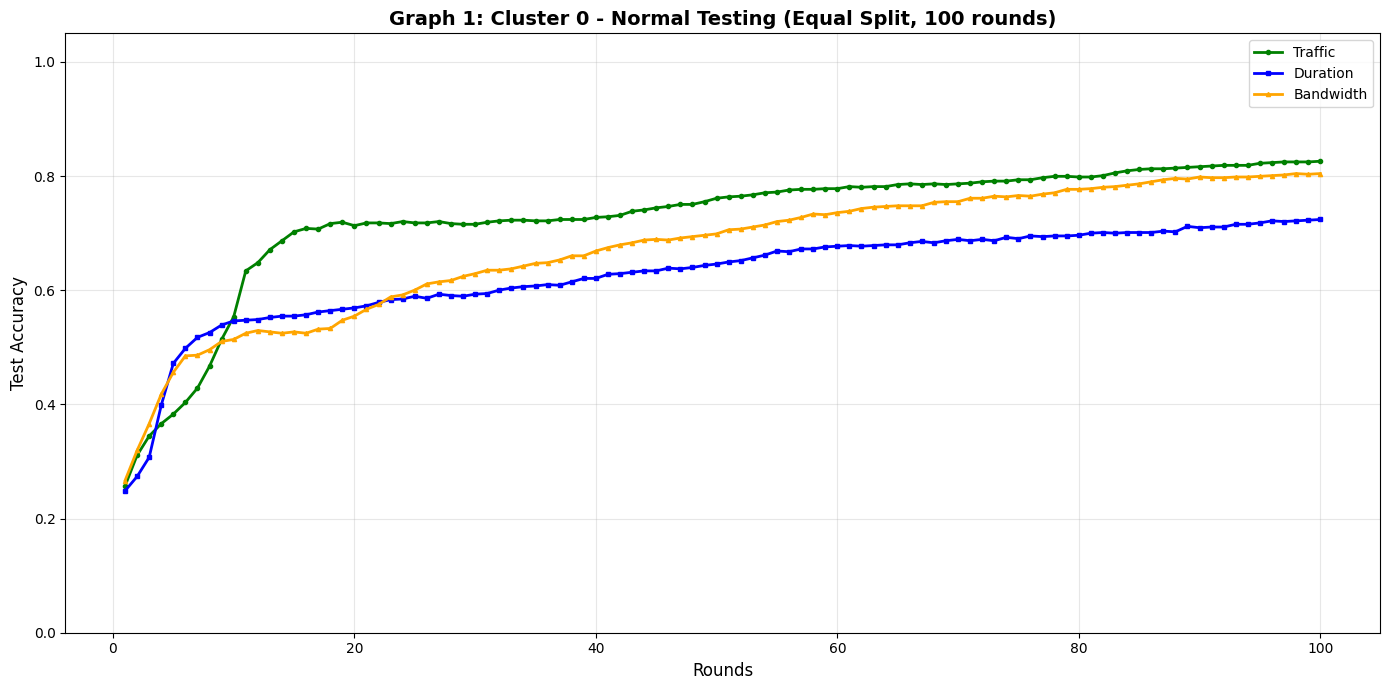


Graph 1: Cluster 0 - Normal Testing (Equal Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.8259, Duration: 0.7239, Bandwidth: 0.8043


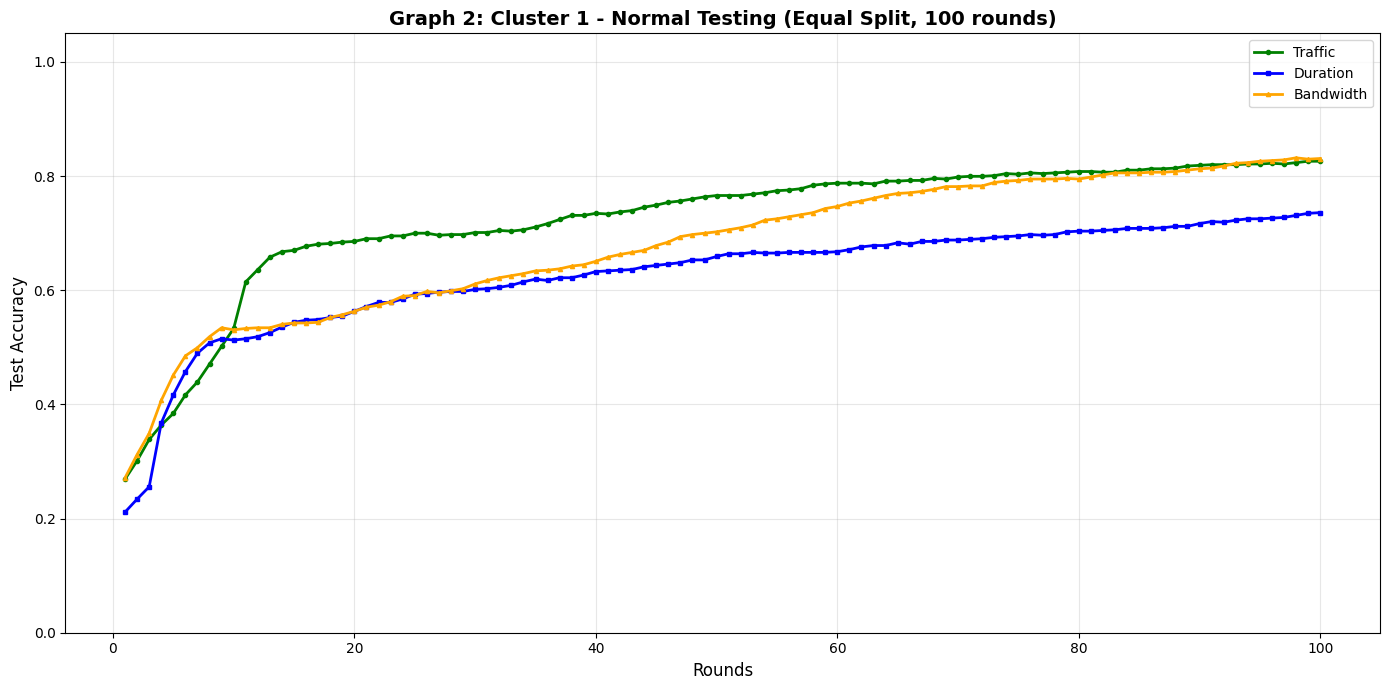


Graph 2: Cluster 1 - Normal Testing (Equal Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.8259, Duration: 0.7359, Bandwidth: 0.8307


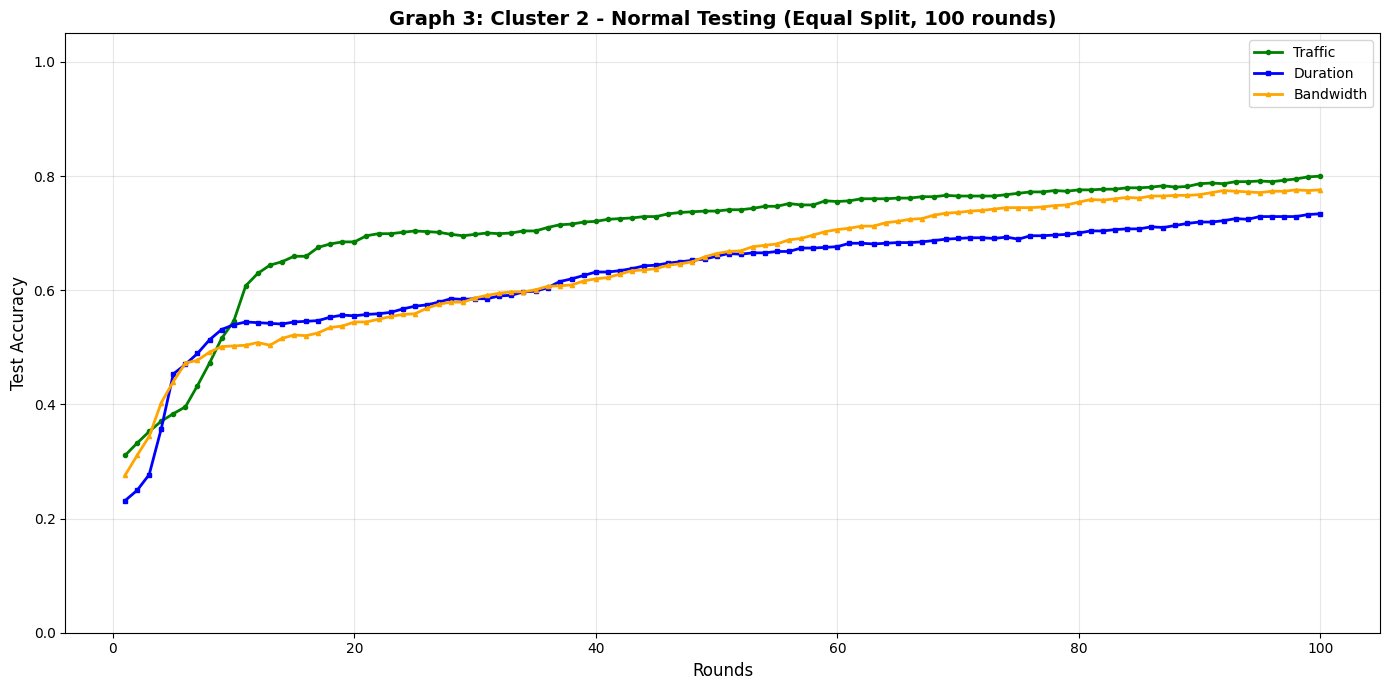


Graph 3: Cluster 2 - Normal Testing (Equal Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.7998, Duration: 0.7338, Bandwidth: 0.7758


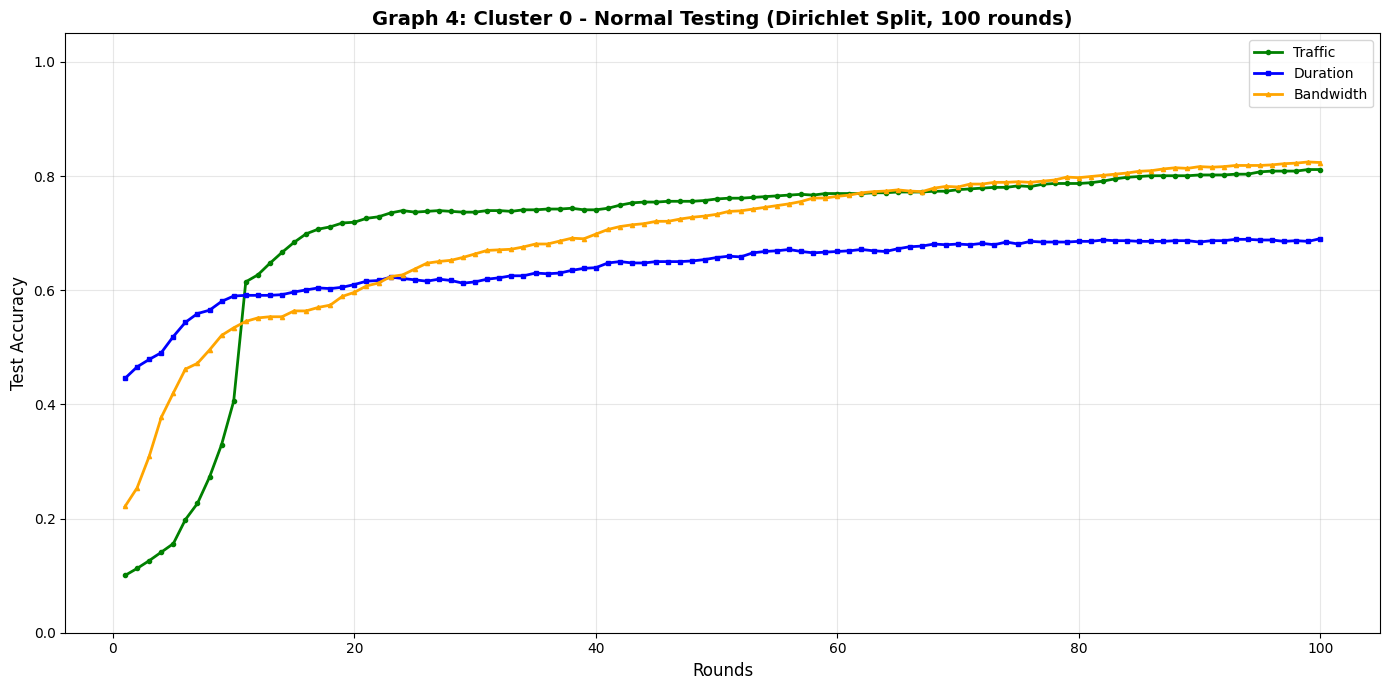


Graph 4: Cluster 0 - Normal Testing (Dirichlet Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.8114, Duration: 0.6903, Bandwidth: 0.8236


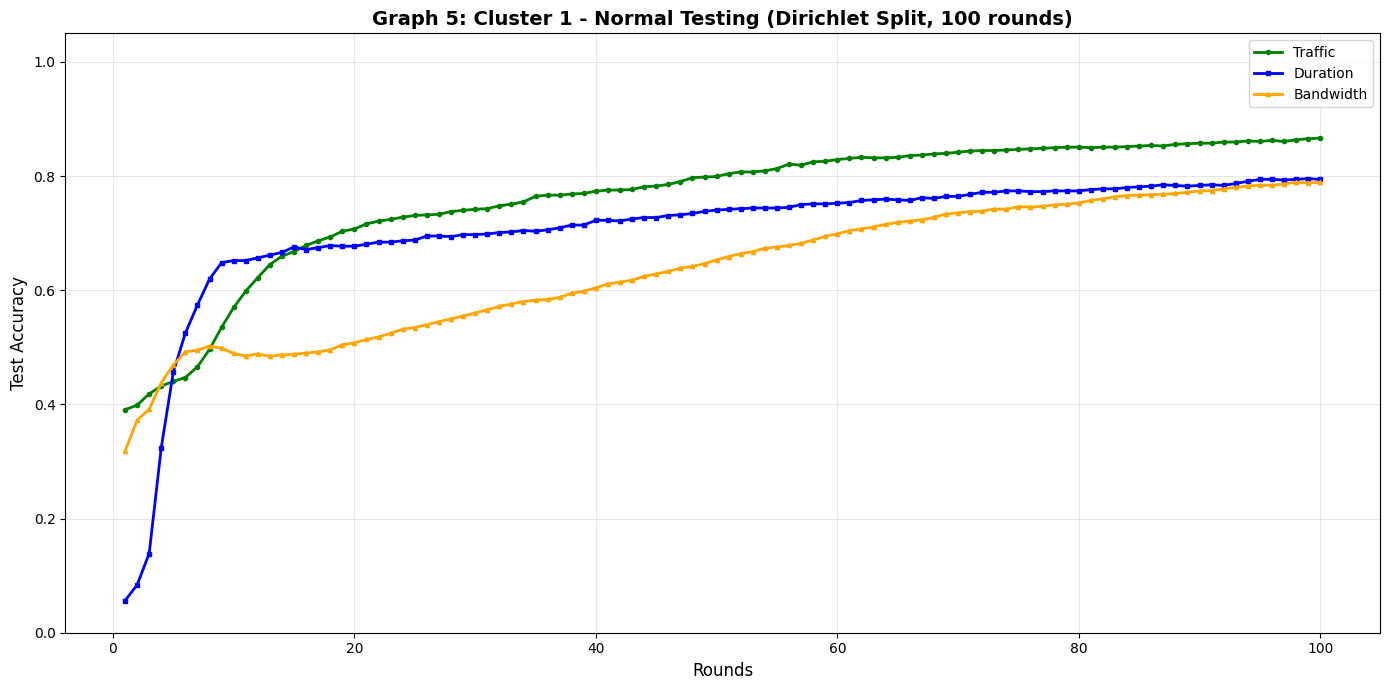


Graph 5: Cluster 1 - Normal Testing (Dirichlet Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.8665, Duration: 0.7943, Bandwidth: 0.7890


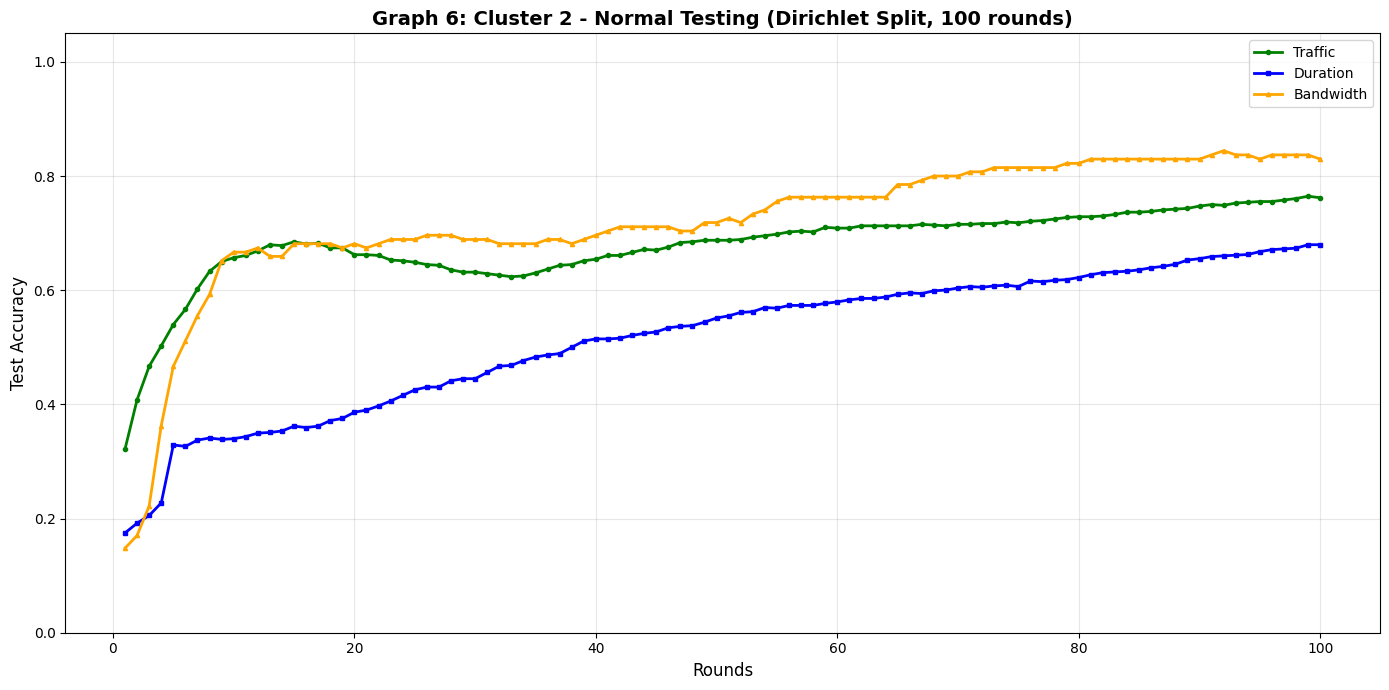


Graph 6: Cluster 2 - Normal Testing (Dirichlet Split, 100 rounds):
  Rounds: 100
  Final - Traffic: 0.7620, Duration: 0.6797, Bandwidth: 0.8296

SECTION 2: OVERALL MULTI-CLUSTER TESTING (100 ROUNDS)


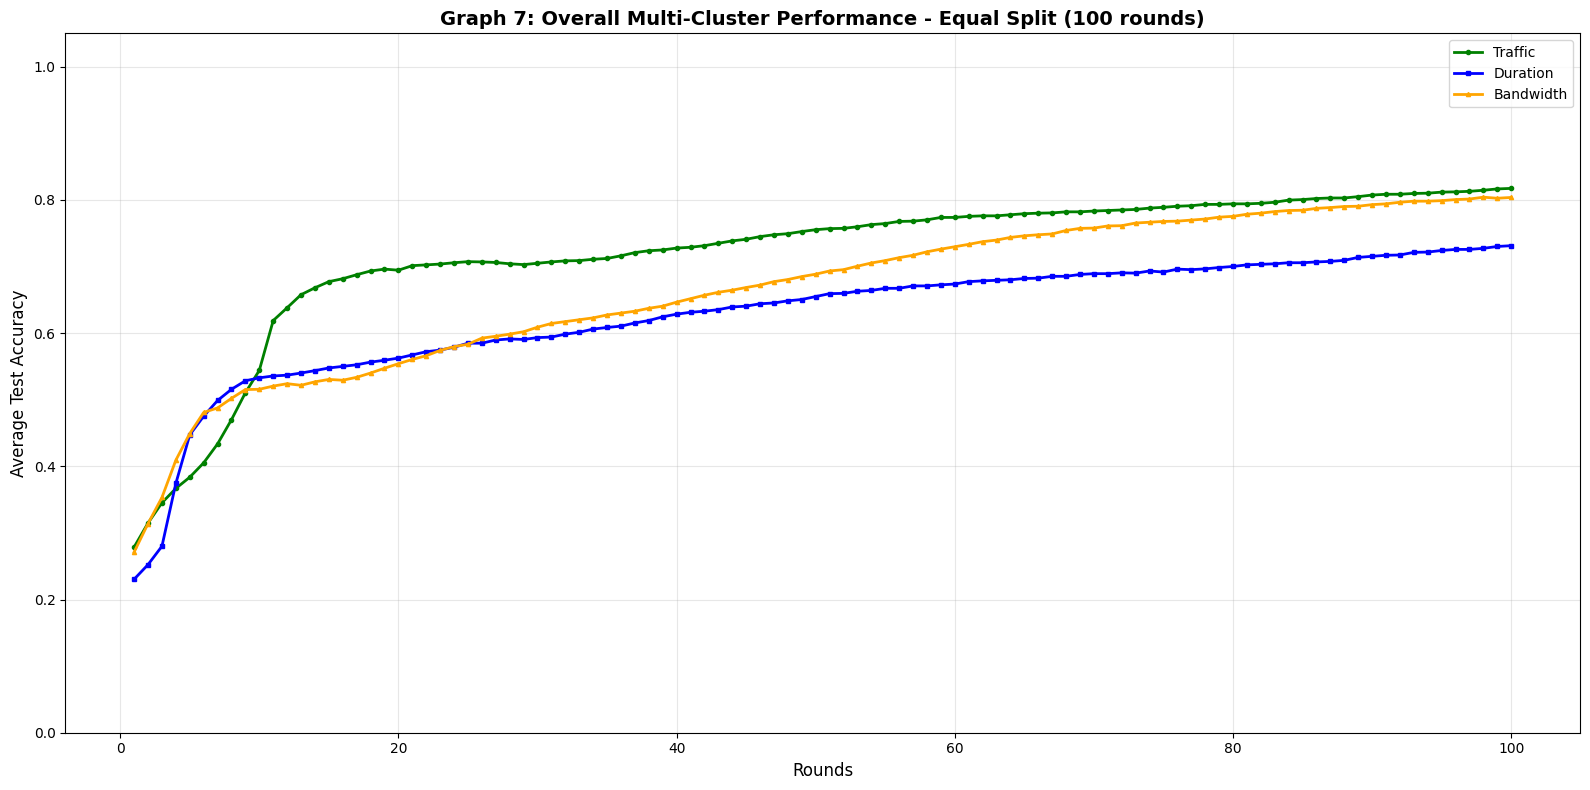


Graph 7: Overall Multi-Cluster Performance - Equal Split (100 rounds):
  Rounds: 100
  Final - Traffic: 0.8172, Duration: 0.7312, Bandwidth: 0.8036


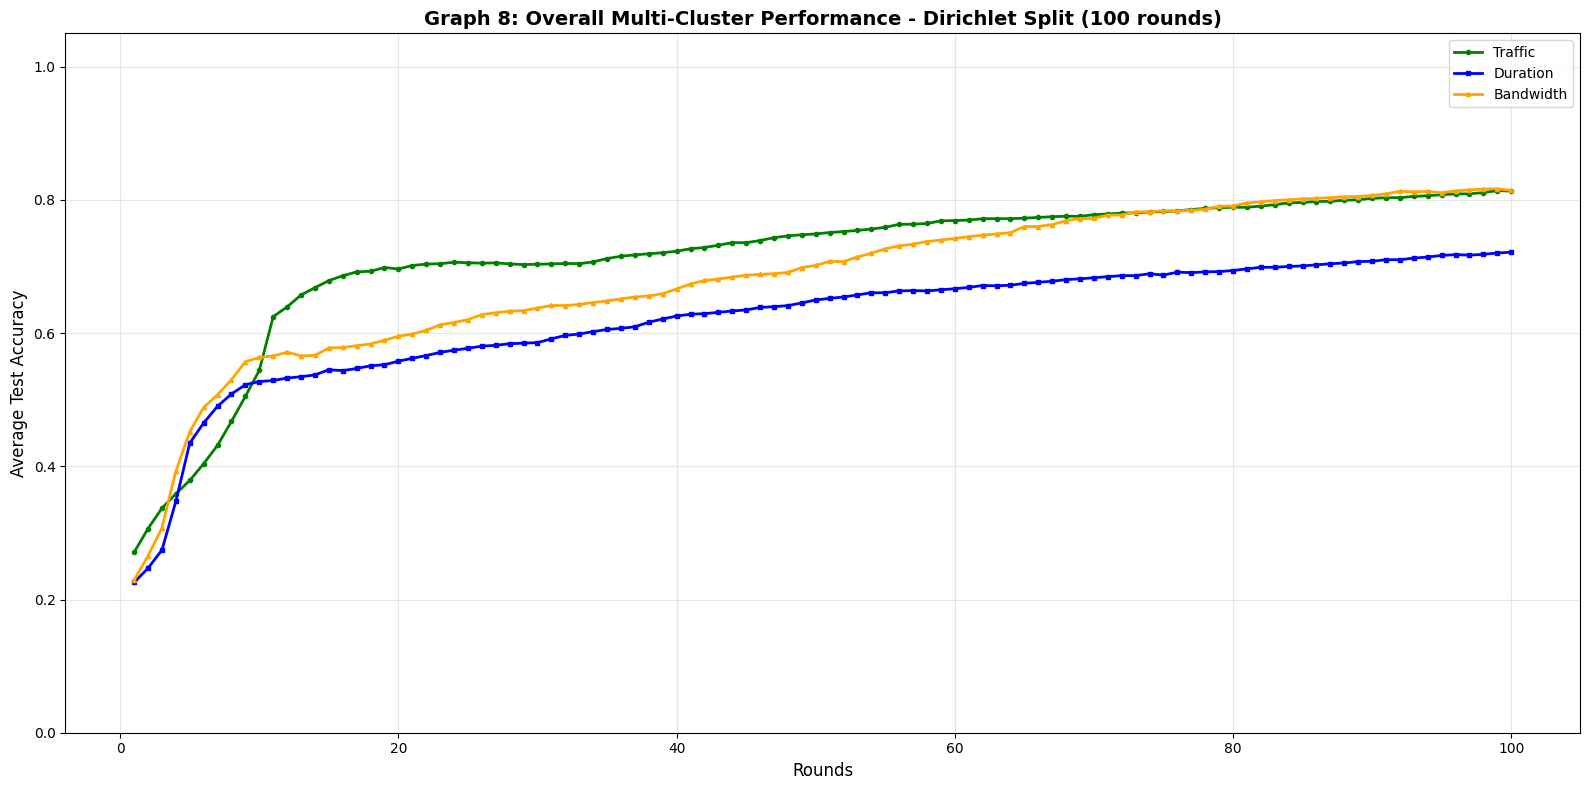


Graph 8: Overall Multi-Cluster Performance - Dirichlet Split (100 rounds):
  Rounds: 100
  Final - Traffic: 0.8133, Duration: 0.7214, Bandwidth: 0.8141

SECTION 3: PER-CLUSTER CONVERGENCE (125 ROUNDS)


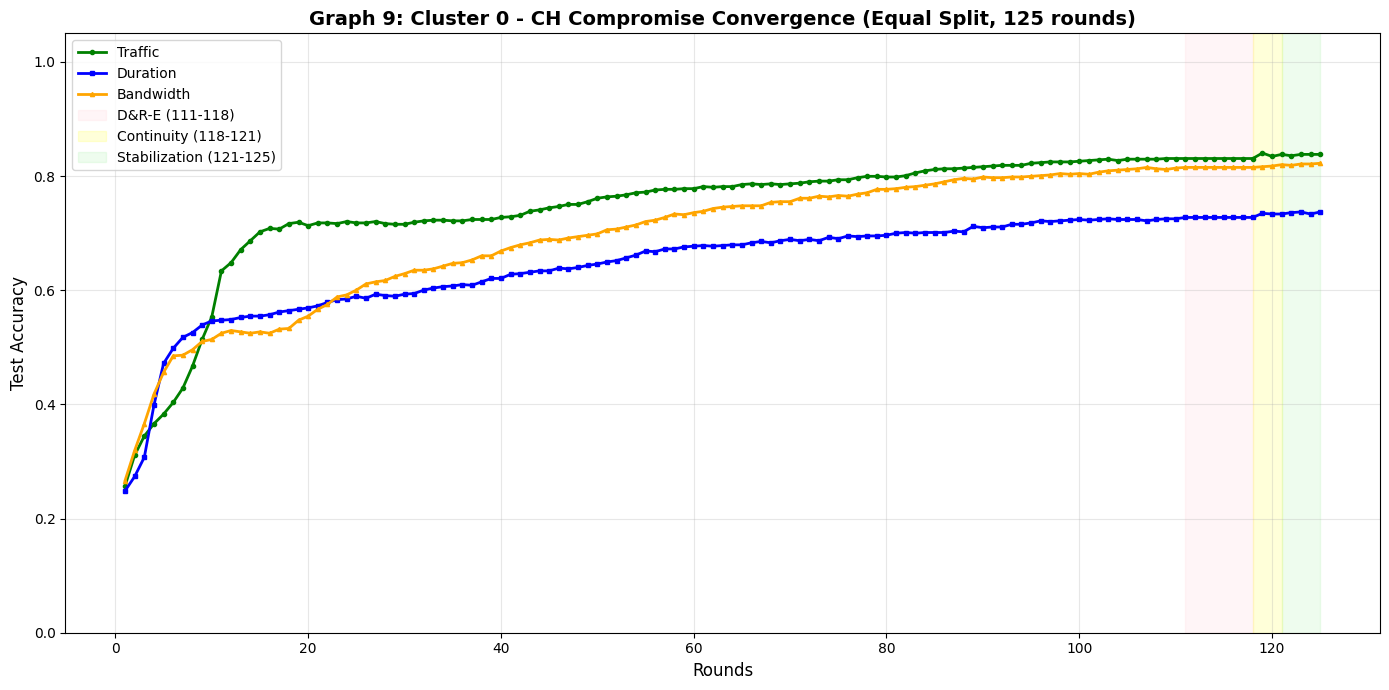


Graph 9: Cluster 0 - CH Compromise Convergence (Equal Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.8379, Duration: 0.7371, Bandwidth: 0.8223


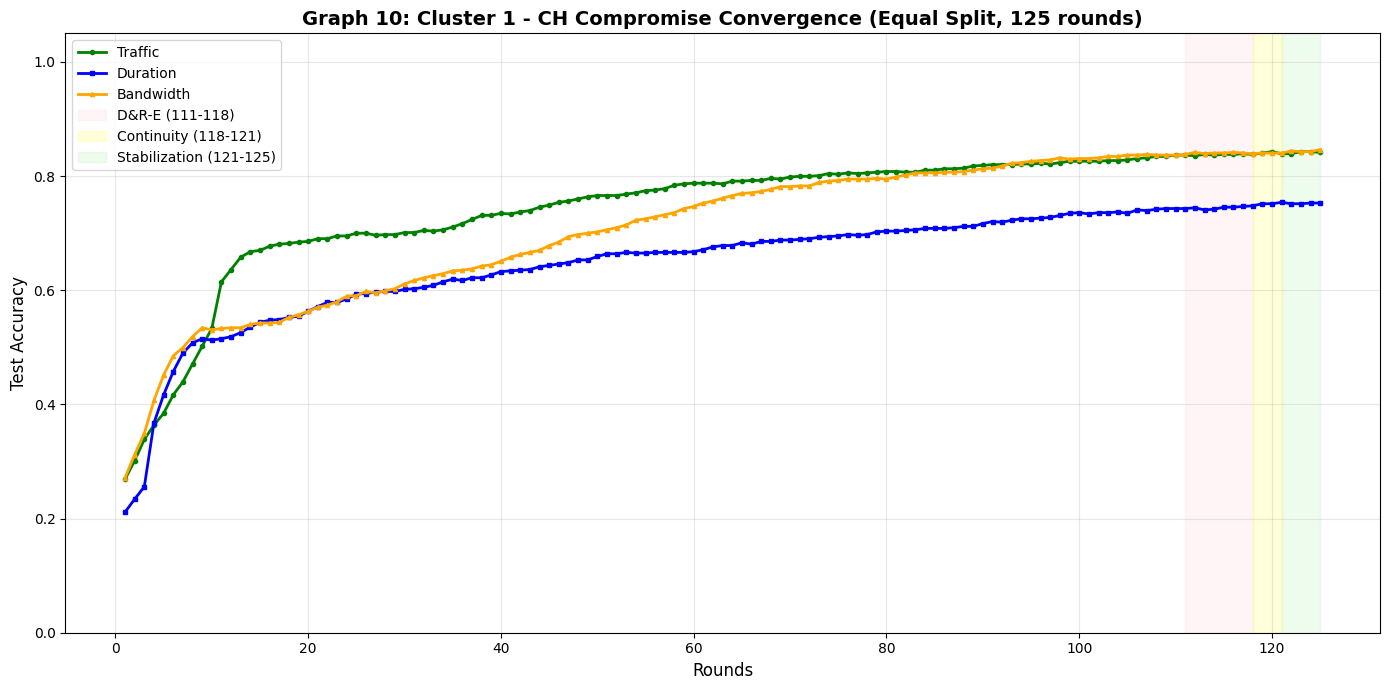


Graph 10: Cluster 1 - CH Compromise Convergence (Equal Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.8415, Duration: 0.7527, Bandwidth: 0.8463


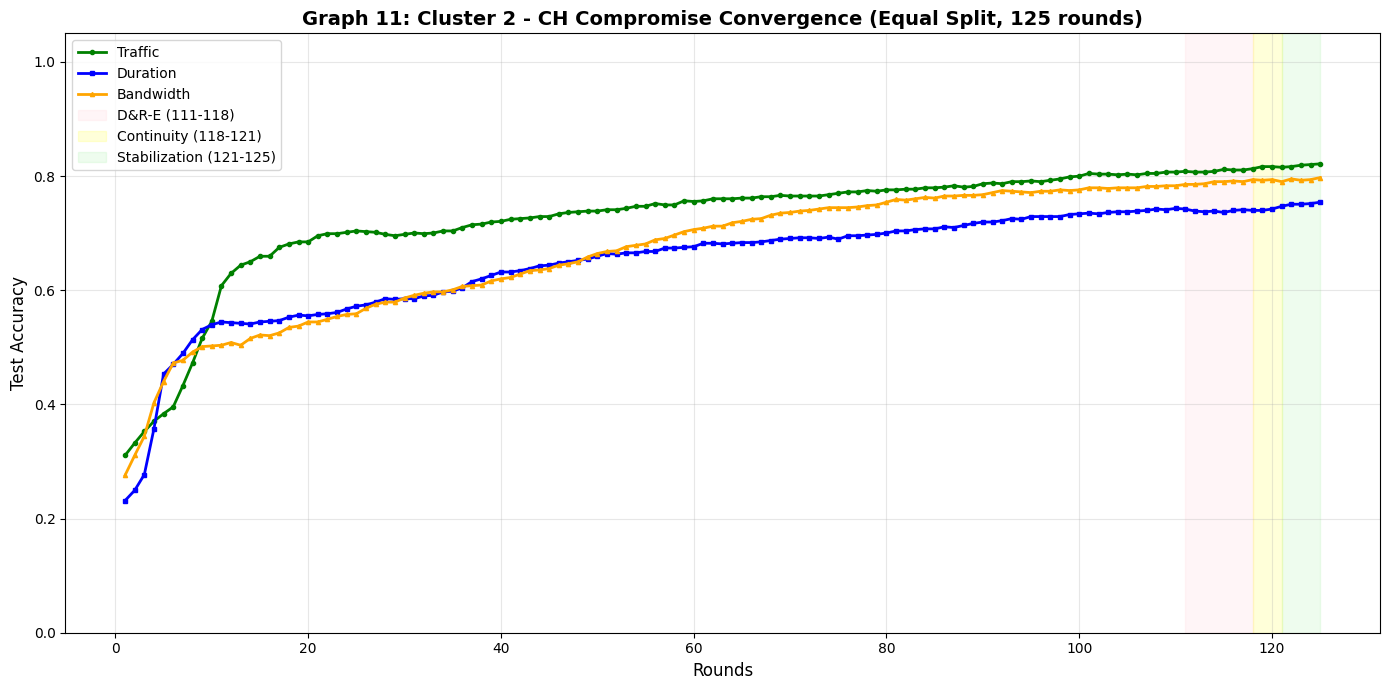


Graph 11: Cluster 2 - CH Compromise Convergence (Equal Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.8213, Duration: 0.7542, Bandwidth: 0.7974


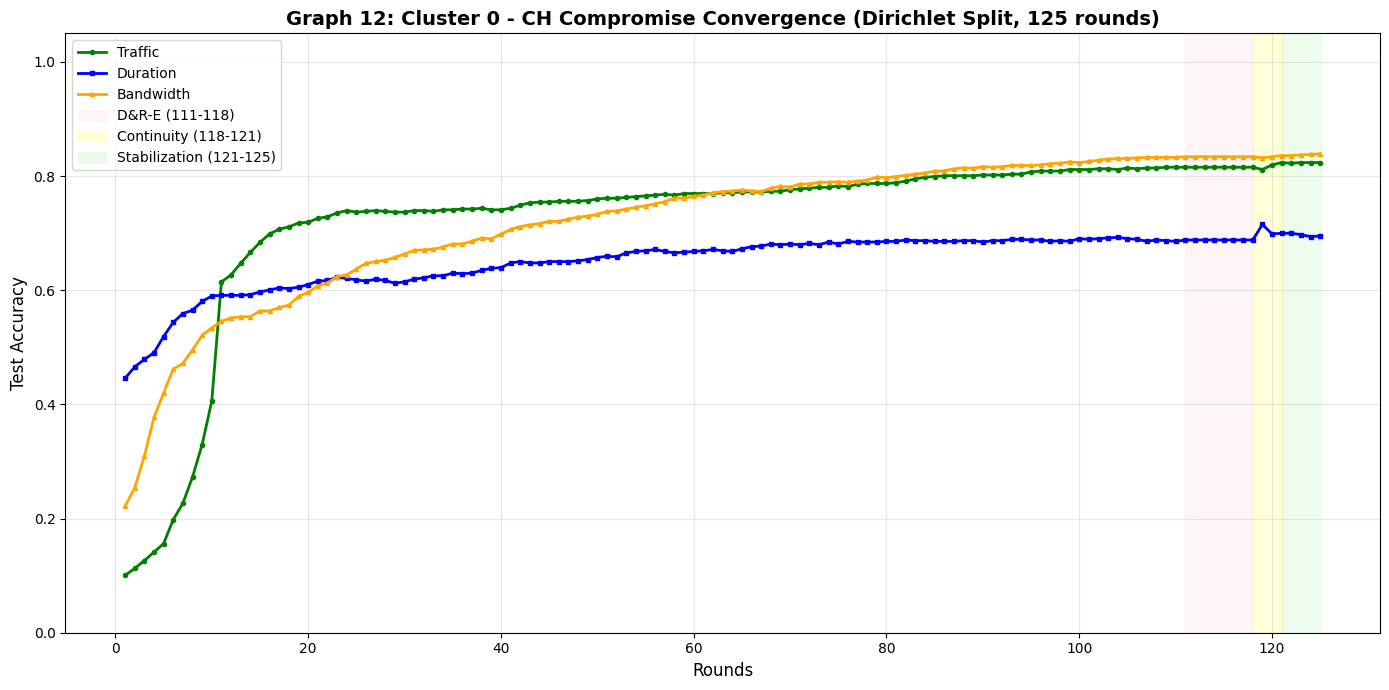


Graph 12: Cluster 0 - CH Compromise Convergence (Dirichlet Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.8236, Duration: 0.6950, Bandwidth: 0.8389


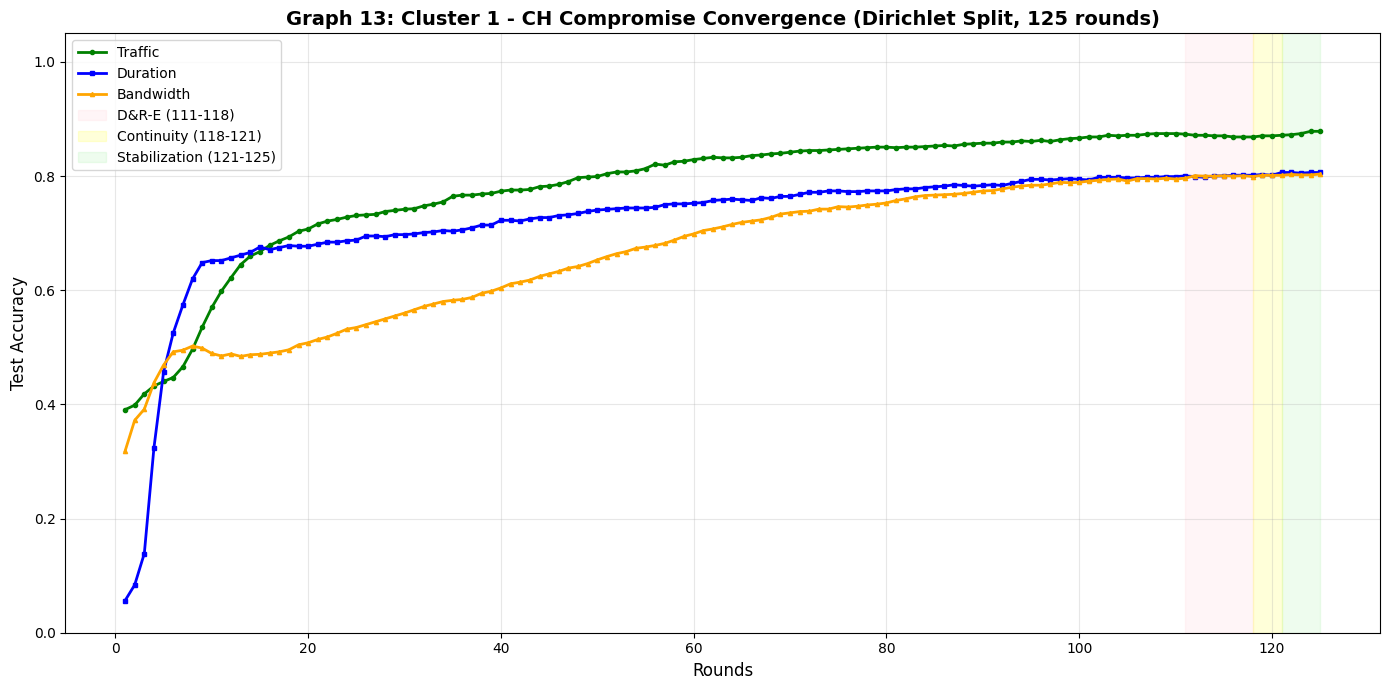


Graph 13: Cluster 1 - CH Compromise Convergence (Dirichlet Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.8783, Duration: 0.8062, Bandwidth: 0.8035


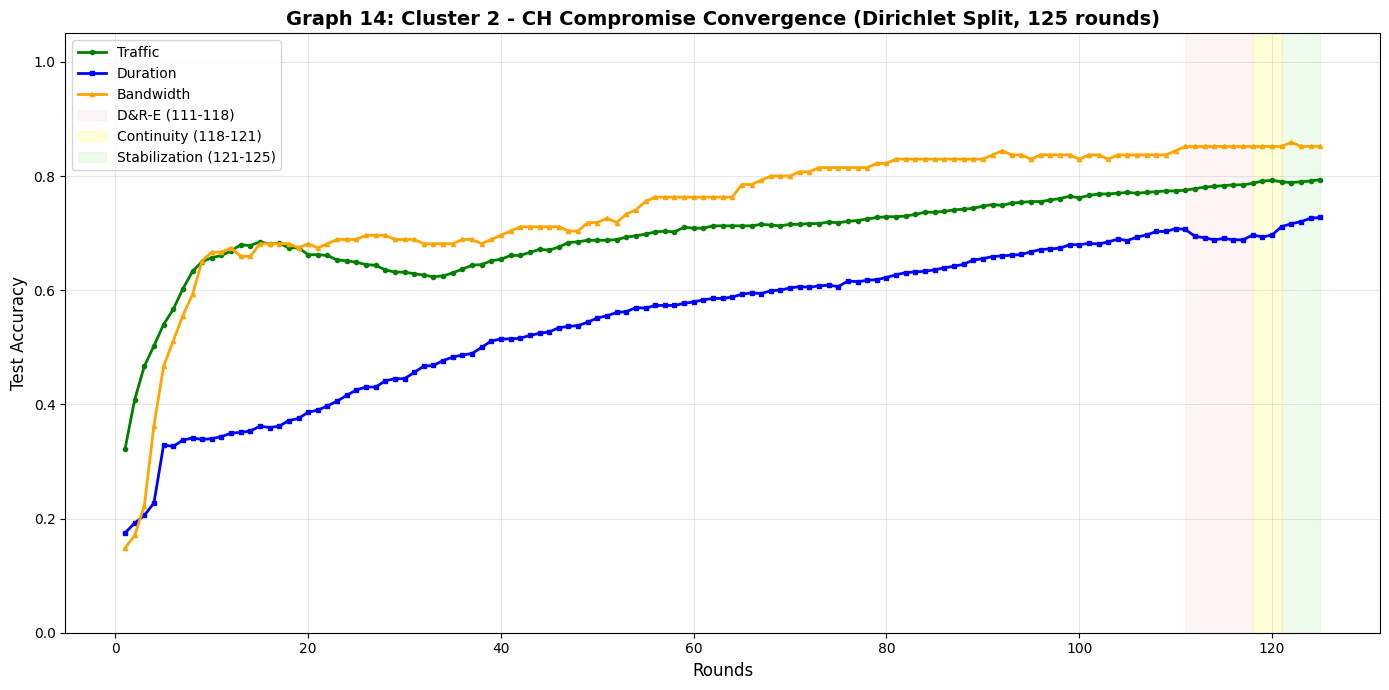


Graph 14: Cluster 2 - CH Compromise Convergence (Dirichlet Split, 125 rounds):
  Rounds: 125
  Final - Traffic: 0.7939, Duration: 0.7274, Bandwidth: 0.8519
SECTION 4: PER-CLUSTER TRANSIENT (30 ROUNDS)


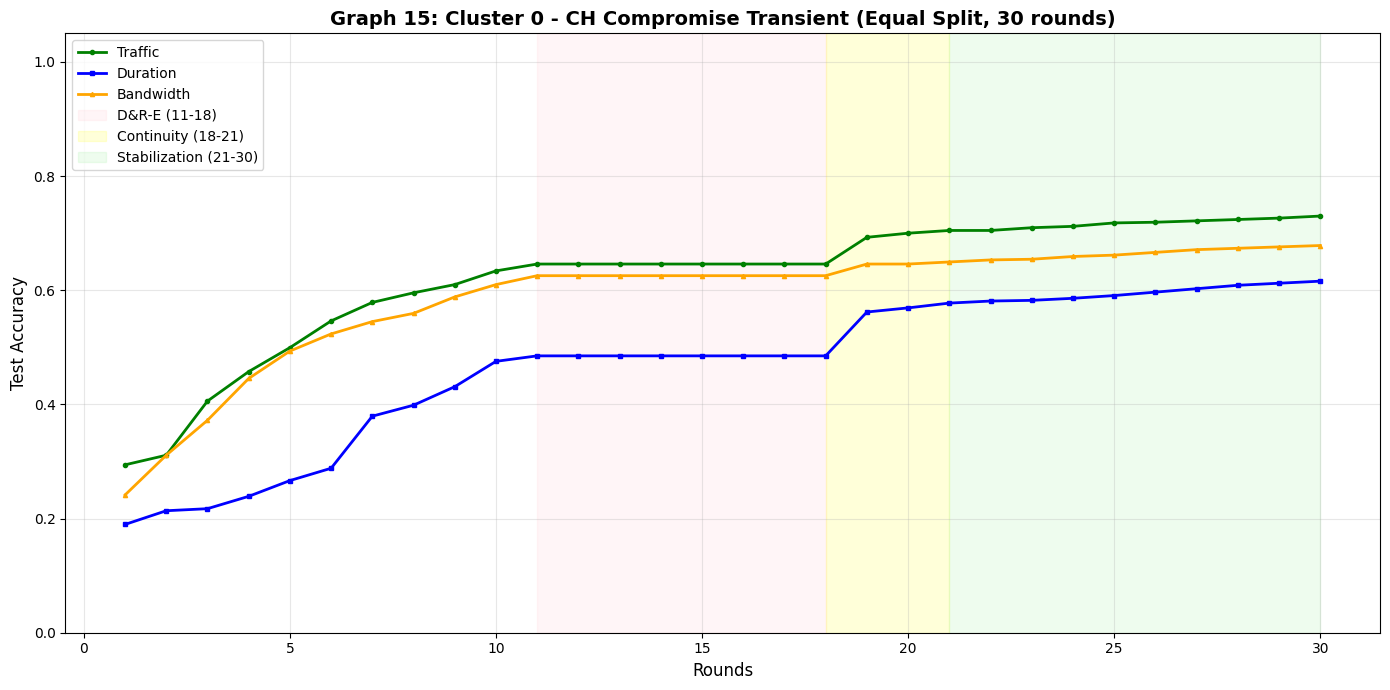


Graph 15: Cluster 0 - CH Compromise Transient (Equal Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.7299, Duration: 0.6158, Bandwidth: 0.6783


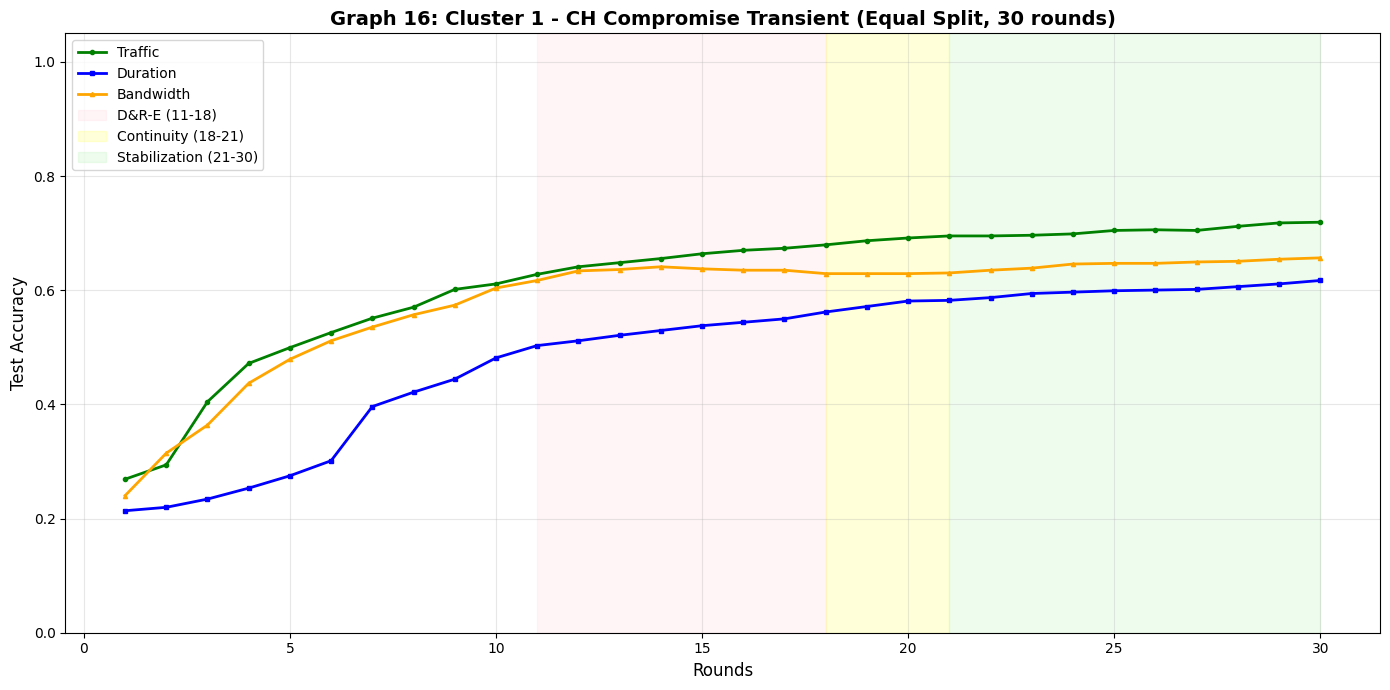


Graph 16: Cluster 1 - CH Compromise Transient (Equal Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.7191, Duration: 0.6170, Bandwidth: 0.6567


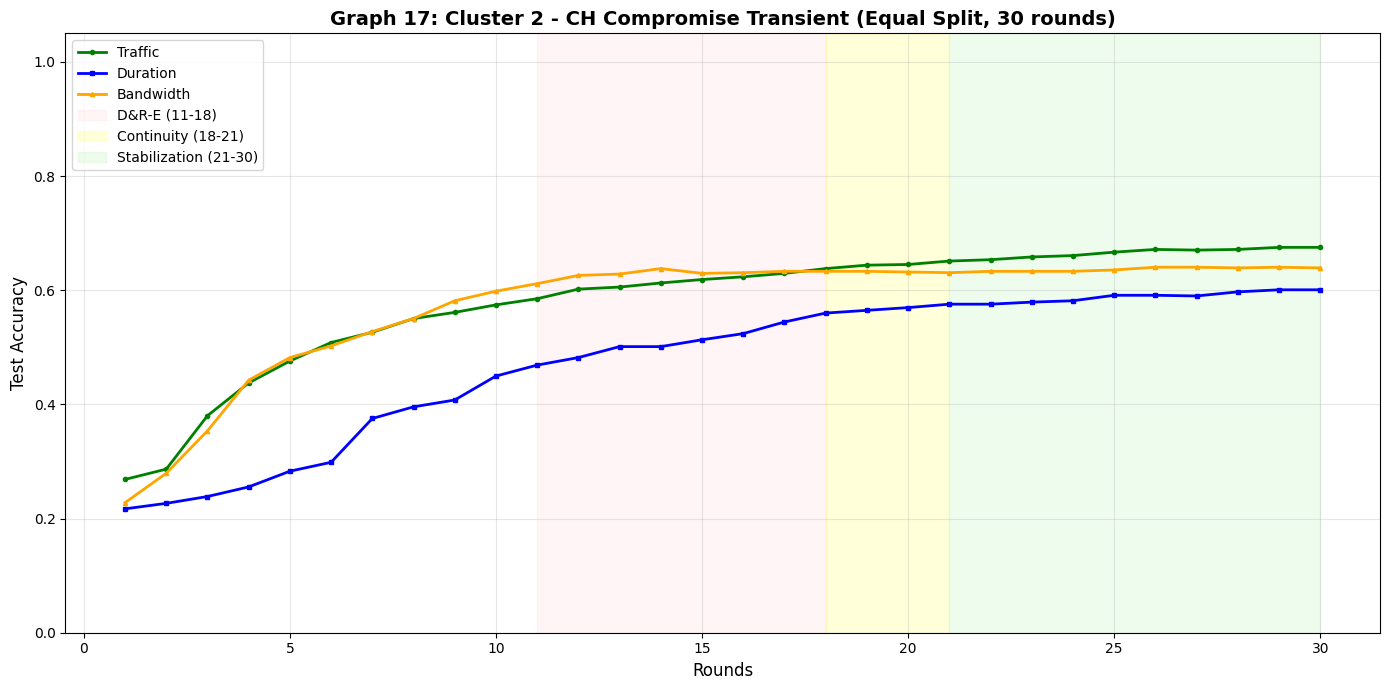


Graph 17: Cluster 2 - CH Compromise Transient (Equal Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.6751, Duration: 0.6007, Bandwidth: 0.6391


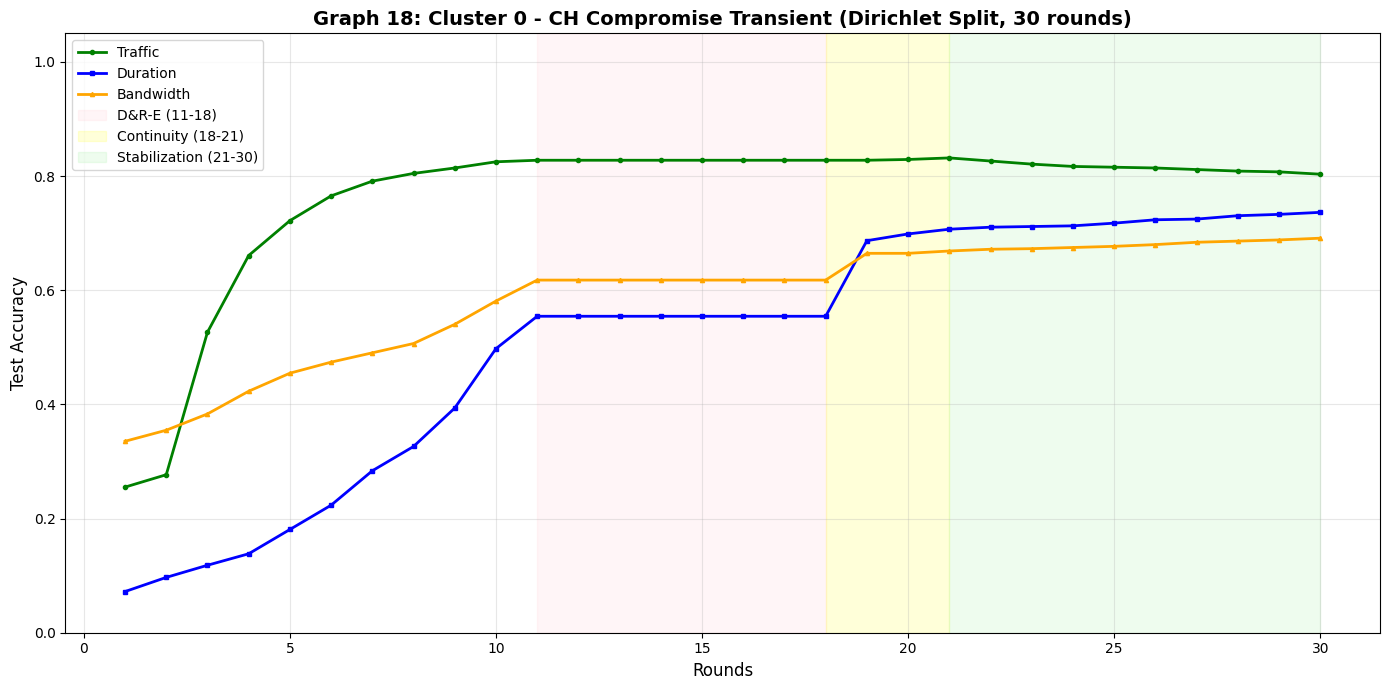


Graph 18: Cluster 0 - CH Compromise Transient (Dirichlet Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.8033, Duration: 0.7364, Bandwidth: 0.6911


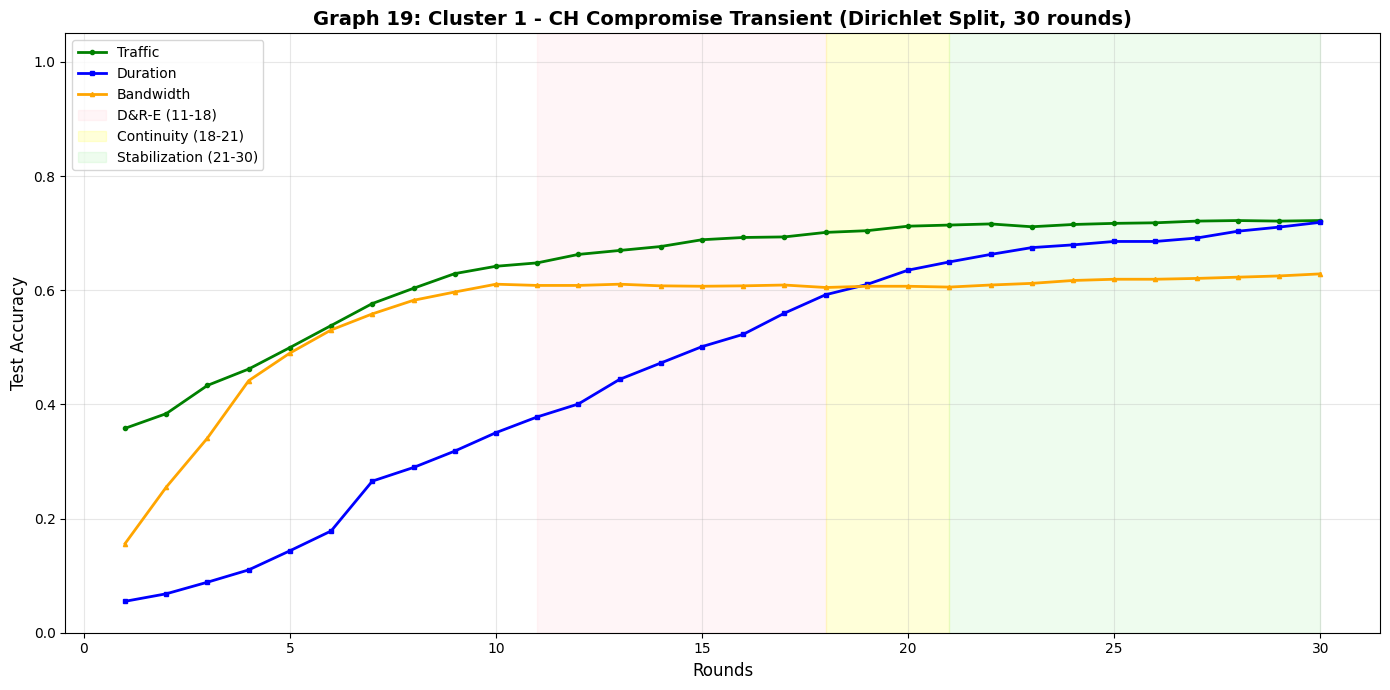


Graph 19: Cluster 1 - CH Compromise Transient (Dirichlet Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.7221, Duration: 0.7189, Bandwidth: 0.6286


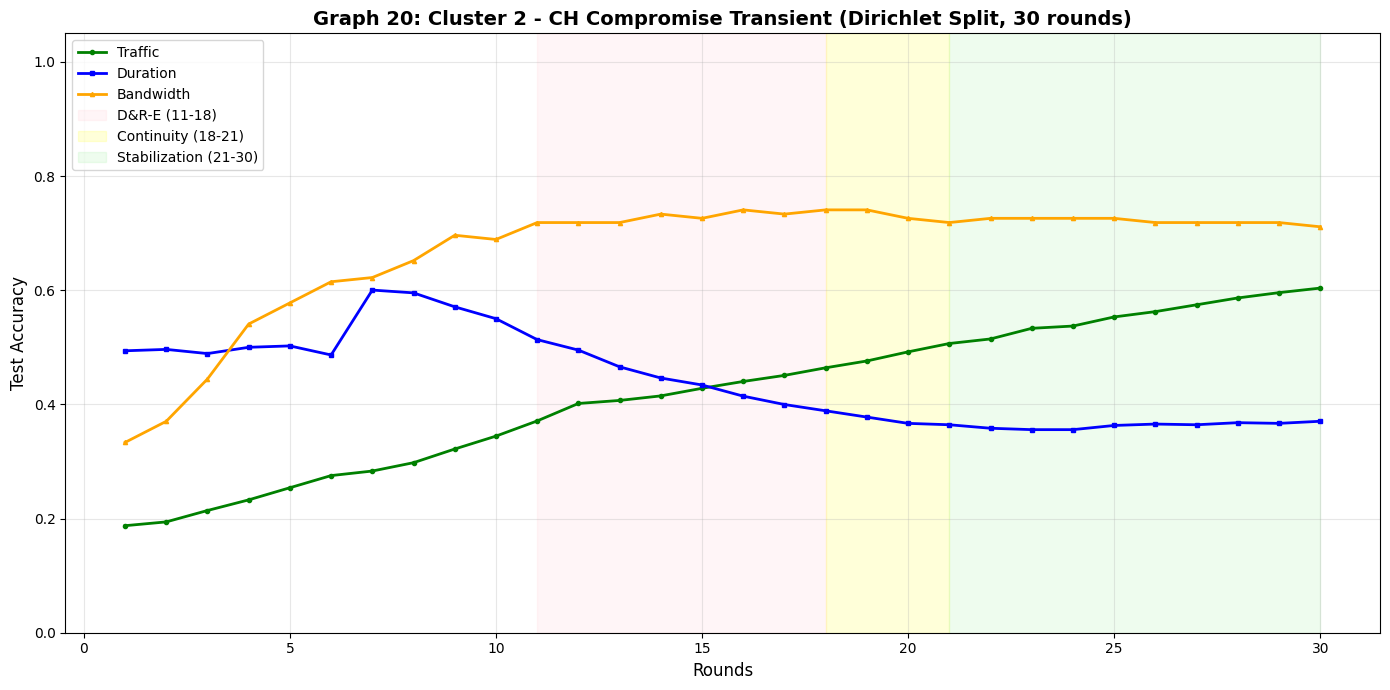


Graph 20: Cluster 2 - CH Compromise Transient (Dirichlet Split, 30 rounds):
  Rounds: 30
  Final - Traffic: 0.6037, Duration: 0.3704, Bandwidth: 0.7111
ALL 20 GRAPHS GENERATED


In [50]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ============================================================================
# LOAD SAVED RESULTS
# ============================================================================

print("="*80)
print("LOADING SAVED INTEGRATED EXPERIMENT RESULTS")
print("="*80)

# Update this with your actual saved file path
results_file = 'experiment_results/integrated_results_20251205_091101.pkl'  # New timestamp

with open(results_file, 'rb') as f:
    results = pickle.load(f)

print(f"Loaded results from: {results_file}")
print(f"   Timestamp: {results['timestamp']}")
print(f"   Convergence rounds: {results['model_metadata']['training_rounds_convergence']}")
print(f"   Transient rounds: {results['model_metadata']['training_rounds_transient']}")

# Extract data with error handling
conv_equal = results['convergence_experiment'].get('per_cluster_equal', {})
conv_dirichlet = results['convergence_experiment'].get('per_cluster_dirichlet', {})
trans_equal = results['transient_experiment'].get('per_cluster_equal', {})
trans_dirichlet = results['transient_experiment'].get('per_cluster_dirichlet', {})

print(f"\nData structure check:")
print(f"   Convergence equal: {type(conv_equal)} - {len(conv_equal)} clusters")
print(f"   Convergence dirichlet: {type(conv_dirichlet)} - {len(conv_dirichlet)} clusters")
print(f"   Transient equal: {type(trans_equal)} - {len(trans_equal)} clusters")
print(f"   Transient dirichlet: {type(trans_dirichlet)} - {len(trans_dirichlet)} clusters")

# Check if convergence data is missing
if not conv_equal or not conv_dirichlet:
    print("\nWARNING: Convergence data missing from saved file!")
    print("This is because the save function has convergence extraction commented out.")
    print("You need to:")
    print("  1. Re-run the save function with convergence data extraction enabled")
    print("  2. Or load convergence data directly from strategy_convergence object")
    
    # Option: Try to load from strategy object if available
    if 'strategy_convergence' in globals():
        print("\nAttempting to use strategy_convergence object...")
        conv_test_data = strategy_convergence.cluster_test_accuracies_by_round
        if 'equal' in conv_test_data and 'dirichlet' in conv_test_data:
            conv_equal = conv_test_data['equal']
            conv_dirichlet = conv_test_data['dirichlet']
            print("   Successfully extracted convergence data from strategy object")
        else:
            print("   ERROR: Strategy object data structure unexpected")
            print(f"   Keys found: {list(conv_test_data.keys())}")
    else:
        print("\nERROR: strategy_convergence object not available in globals()")
        print("Please re-run the convergence training or fix the save function.")
        # Exit early
        import sys
        sys.exit(1)

print("="*80)

# ============================================================================
# HELPER FUNCTIONS FOR PLOTTING
# ============================================================================

def plot_cluster_performance(data, cluster_id, title, phases=None, figsize=(14, 8)):
    """Plot per-cluster performance with phase markers"""
    if not data or cluster_id not in data:
        print(f"No data for cluster {cluster_id}")
        return
    
    cluster_data = data[cluster_id]
    rounds = [item['round'] for item in cluster_data]
    traffic = [item['traffic_accuracy'] for item in cluster_data]
    duration = [item['duration_accuracy'] for item in cluster_data]
    bandwidth = [item['bandwidth_accuracy'] for item in cluster_data]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot accuracy curves
    ax.plot(rounds, traffic, 'green', label='Traffic', linewidth=2, marker='o', markersize=3)
    ax.plot(rounds, duration, 'blue', label='Duration', linewidth=2, marker='s', markersize=3)
    ax.plot(rounds, bandwidth, 'orange', label='Bandwidth', linewidth=2, marker='^', markersize=3)
    
    # Add phase markers
    if phases:
        for start, (end, color, label) in phases.items():
            ax.axvspan(start, end, alpha=0.15, color=color, label=label)
    
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{title}:")
    print(f"  Rounds: {len(rounds)}")
    print(f"  Final - Traffic: {traffic[-1]:.4f}, Duration: {duration[-1]:.4f}, Bandwidth: {bandwidth[-1]:.4f}")

def plot_overall_performance(data, title, phases=None, max_rounds=None, figsize=(16, 8)):
    """Plot overall performance averaging all clusters"""
    if not data:
        print(f"No data available")
        return
    
    # Get all rounds
    all_rounds = set()
    for cluster_id in data.keys():
        all_rounds.update([item['round'] for item in data[cluster_id]])
    rounds = sorted(list(all_rounds))
    
    if max_rounds:
        rounds = [r for r in rounds if r <= max_rounds]
    
    # Average across clusters
    traffic_avg = []
    duration_avg = []
    bandwidth_avg = []
    
    for rnd in rounds:
        traffic_vals = []
        duration_vals = []
        bandwidth_vals = []
        
        for cluster_id in data.keys():
            cluster_data = [item for item in data[cluster_id] if item['round'] == rnd]
            if cluster_data:
                traffic_vals.append(cluster_data[0]['traffic_accuracy'])
                duration_vals.append(cluster_data[0]['duration_accuracy'])
                bandwidth_vals.append(cluster_data[0]['bandwidth_accuracy'])
        
        traffic_avg.append(np.mean(traffic_vals) if traffic_vals else 0)
        duration_avg.append(np.mean(duration_vals) if duration_vals else 0)
        bandwidth_avg.append(np.mean(bandwidth_vals) if bandwidth_vals else 0)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot accuracy curves
    ax.plot(rounds, traffic_avg, 'green', label='Traffic', linewidth=2, marker='o', markersize=3)
    ax.plot(rounds, duration_avg, 'blue', label='Duration', linewidth=2, marker='s', markersize=3)
    ax.plot(rounds, bandwidth_avg, 'orange', label='Bandwidth', linewidth=2, marker='^', markersize=3)
    
    # Add phase markers
    if phases:
        for start, (end, color, label) in phases.items():
            ax.axvspan(start, end, alpha=0.15, color=color, label=label)
    
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel('Average Test Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{title}:")
    print(f"  Rounds: {len(rounds)}")
    print(f"  Final - Traffic: {traffic_avg[-1]:.4f}, Duration: {duration_avg[-1]:.4f}, Bandwidth: {bandwidth_avg[-1]:.4f}")

# ============================================================================
# SECTION 1: PER-CLUSTER NORMAL TESTING (100 ROUNDS) - 6 GRAPHS
# ============================================================================

print("\n" + "="*80)
print("SECTION 1: PER-CLUSTER NORMAL TESTING (100 ROUNDS)")
print("="*80)

for cluster_id in [0, 1, 2]:
    # Equal split
    plot_cluster_performance(
        {cluster_id: [item for item in conv_equal[cluster_id] if item['round'] <= 100]},
        cluster_id,
        f'Graph {cluster_id + 1}: Cluster {cluster_id} - Normal Testing (Equal Split, 100 rounds)',
        figsize=(14, 7)
    )

for cluster_id in [0, 1, 2]:
    # Dirichlet split
    plot_cluster_performance(
        {cluster_id: [item for item in conv_dirichlet[cluster_id] if item['round'] <= 100]},
        cluster_id,
        f'Graph {cluster_id + 4}: Cluster {cluster_id} - Normal Testing (Dirichlet Split, 100 rounds)',
        figsize=(14, 7)
    )

# ============================================================================
# SECTION 2: OVERALL MULTI-CLUSTER TESTING (100 ROUNDS) - 2 GRAPHS
# ============================================================================

print("\n" + "="*80)
print("SECTION 2: OVERALL MULTI-CLUSTER TESTING (100 ROUNDS)")
print("="*80)

# Filter to 100 rounds
conv_equal_100 = {cid: [item for item in conv_equal[cid] if item['round'] <= 100] for cid in conv_equal.keys()}
conv_dirichlet_100 = {cid: [item for item in conv_dirichlet[cid] if item['round'] <= 100] for cid in conv_dirichlet.keys()}

plot_overall_performance(
    conv_equal_100,
    'Graph 7: Overall Multi-Cluster Performance - Equal Split (100 rounds)',
    max_rounds=100,
    figsize=(16, 8)
)

plot_overall_performance(
    conv_dirichlet_100,
    'Graph 8: Overall Multi-Cluster Performance - Dirichlet Split (100 rounds)',
    max_rounds=100,
    figsize=(16, 8)
)

# ============================================================================
# SECTION 3: PER-CLUSTER CONVERGENCE (125 ROUNDS) - 6 GRAPHS
# ============================================================================

print("\n" + "="*80)
print("SECTION 3: PER-CLUSTER CONVERGENCE (125 ROUNDS)")
print("="*80)

# Phase markers for convergence
convergence_phases = {
    111: (118, 'pink', 'D&R-E (111-118)'),
    118: (121, 'yellow', 'Continuity (118-121)'),
    121: (125, 'lightgreen', 'Stabilization (121-125)')
}

for cluster_id in [0, 1, 2]:
    # Equal split
    plot_cluster_performance(
        conv_equal,
        cluster_id,
        f'Graph {cluster_id + 9}: Cluster {cluster_id} - CH Compromise Convergence (Equal Split, 125 rounds)',
        phases=convergence_phases,
        figsize=(14, 7)
    )

for cluster_id in [0, 1, 2]:
    # Dirichlet split
    plot_cluster_performance(
        conv_dirichlet,
        cluster_id,
        f'Graph {cluster_id + 12}: Cluster {cluster_id} - CH Compromise Convergence (Dirichlet Split, 125 rounds)',
        phases=convergence_phases,
        figsize=(14, 7)
    )

# ============================================================================
# SECTION 4: PER-CLUSTER TRANSIENT (30 ROUNDS) - 6 GRAPHS
# ============================================================================


print("SECTION 4: PER-CLUSTER TRANSIENT (30 ROUNDS)")

# Phase markers for transient
transient_phases = {
    11: (18, 'pink', 'D&R-E (11-18)'),
    18: (21, 'yellow', 'Continuity (18-21)'),
    21: (30, 'lightgreen', 'Stabilization (21-30)')
}

for cluster_id in [0, 1, 2]:
    # Equal split
    plot_cluster_performance(
        trans_equal,
        cluster_id,
        f'Graph {cluster_id + 15}: Cluster {cluster_id} - CH Compromise Transient (Equal Split, 30 rounds)',
        phases=transient_phases,
        figsize=(14, 7)
    )

for cluster_id in [0, 1, 2]:
    # Dirichlet split
    plot_cluster_performance(
        trans_dirichlet,
        cluster_id,
        f'Graph {cluster_id + 18}: Cluster {cluster_id} - CH Compromise Transient (Dirichlet Split, 30 rounds)',
        phases=transient_phases,
        figsize=(14, 7)
    )

print("ALL 20 GRAPHS GENERATED")

Available rounds: 30
Sample entry: ['round', 'equal_split', 'dirichlet_split', 'participating_clusters', 'recovery_phase']


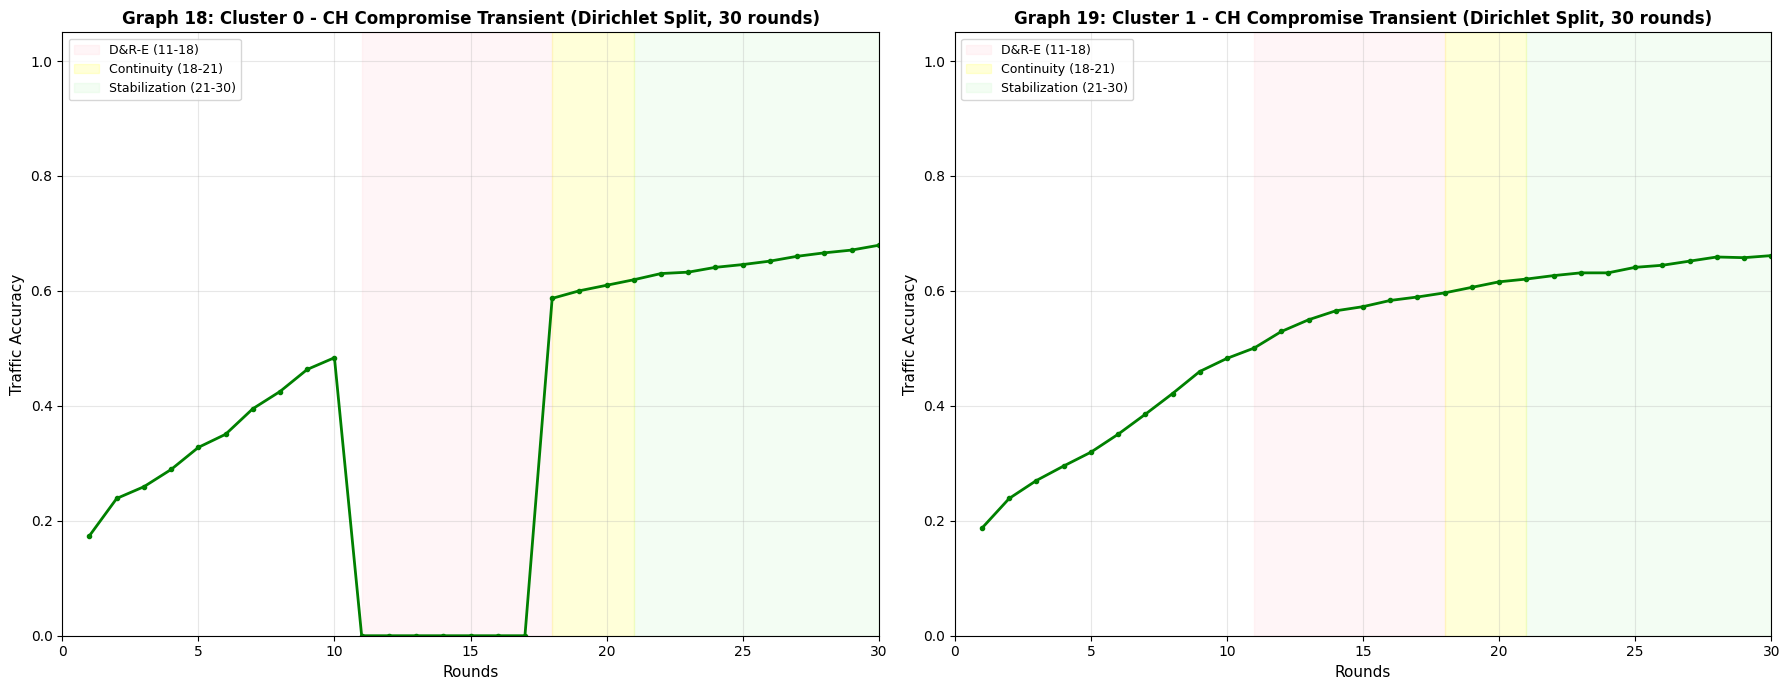


CLUSTER COMPARISON
Cluster 0 (Compromised):
  Before D&R-E (Round 10): 0.4838
  During D&R-E (Round 15): 0.0000
  After recovery (Round 30): 0.6795

Cluster 1 (Healthy):
  Before D&R-E (Round 10): 0.4826
  During D&R-E (Round 15): 0.5726
  After recovery (Round 30): 0.6615


In [41]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load existing results
results_file = 'experiment_results/integrated_results_20251204_204130.pkl'
with open(results_file, 'rb') as f:
    results = pickle.load(f)

# Extract transient data
transient_data = results['transient_experiment']['per_cluster_equal']

# Check structure
print("Available rounds:", len(transient_data))
print("Sample entry:", list(transient_data[0].keys()) if transient_data else "Empty")

# Extract Cluster 0 and Cluster 1 data
cluster_0_traffic = []
cluster_1_traffic = []
rounds_list = []

for entry in transient_data:
    round_num = entry['round']
    rounds_list.append(round_num)
    
    # Cluster 0 data (from equal_split)
    if 'equal_split' in entry and 0 in entry['equal_split']:
        cluster_0_traffic.append(entry['equal_split'][0].get('traffic_accuracy', 0))
    else:
        cluster_0_traffic.append(0)
    
    # Cluster 1 data (from equal_split)
    if 'equal_split' in entry and 1 in entry['equal_split']:
        cluster_1_traffic.append(entry['equal_split'][1].get('traffic_accuracy', 0))
    else:
        cluster_1_traffic.append(0)

# Plot Cluster 0 vs Cluster 1
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Cluster 0
axes[0].plot(rounds_list, cluster_0_traffic, 'green', linewidth=2, marker='o', markersize=3)
axes[0].axvspan(11, 18, alpha=0.15, color='pink', label='D&R-E (11-18)')
axes[0].axvspan(18, 21, alpha=0.15, color='yellow', label='Continuity (18-21)')
axes[0].axvspan(21, 30, alpha=0.10, color='lightgreen', label='Stabilization (21-30)')
axes[0].set_xlabel('Rounds', fontsize=11)
axes[0].set_ylabel('Traffic Accuracy', fontsize=11)
axes[0].set_title('Graph 18: Cluster 0 - CH Compromise Transient (Dirichlet Split, 30 rounds)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.05)
axes[0].set_xlim(0, 30)

# Cluster 1
axes[1].plot(rounds_list, cluster_1_traffic, 'green', linewidth=2, marker='o', markersize=3)
axes[1].axvspan(11, 18, alpha=0.15, color='pink', label='D&R-E (11-18)')
axes[1].axvspan(18, 21, alpha=0.15, color='yellow', label='Continuity (18-21)')
axes[1].axvspan(21, 30, alpha=0.10, color='lightgreen', label='Stabilization (21-30)')
axes[1].set_xlabel('Rounds', fontsize=11)
axes[1].set_ylabel('Traffic Accuracy', fontsize=11)
axes[1].set_title('Graph 19: Cluster 1 - CH Compromise Transient (Dirichlet Split, 30 rounds)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.05)
axes[1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("CLUSTER COMPARISON")
print("="*80)
print(f"Cluster 0 (Compromised):")
print(f"  Before D&R-E (Round 10): {cluster_0_traffic[9]:.4f}")
print(f"  During D&R-E (Round 15): {cluster_0_traffic[14]:.4f}")
print(f"  After recovery (Round 30): {cluster_0_traffic[-1]:.4f}")
print(f"\nCluster 1 (Healthy):")
print(f"  Before D&R-E (Round 10): {cluster_1_traffic[9]:.4f}")
print(f"  During D&R-E (Round 15): {cluster_1_traffic[14]:.4f}")
print(f"  After recovery (Round 30): {cluster_1_traffic[-1]:.4f}")

In [ ]:
import os

print("Checking saved models...")
print("\n1. Convergence scenario:")
conv_dir = 'trained_models/convergence_integrated'
if os.path.exists(conv_dir):
    files = sorted([f for f in os.listdir(conv_dir) if f.endswith('.pkl')])
    print(f"    Found {len(files)} checkpoints")
    print(f"   Rounds: {files[0]} to {files[-1]}")
else:
    print("   ❌ Directory not found - need to run convergence training")

print("\n2. Transient scenario:")
trans_dir = 'trained_models/transient_integrated'
if os.path.exists(trans_dir):
    files = sorted([f for f in os.listdir(trans_dir) if f.endswith('.pkl')])
    print(f"    Found {len(files)} checkpoints")
    print(f"   Rounds: {files[0]} to {files[-1]}")
else:
    print("   ❌ Directory not found - need to run transient training")

print("\n" + "="*80)
if os.path.exists(conv_dir) and os.path.exists(trans_dir):
    print(" BOTH scenarios trained - you can save results directly")
else:
    print(" Missing training data - run the training cells first")